In [13]:
from rllab.algos.trpo import TRPO
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.envs.gym_env import GymEnv
from rllab.envs.normalized_env import normalize
from rllab.policies.gaussian_mlp_policy import GaussianMLPPolicy
from rllab.policies.constant_control_policy import ConstantControlPolicy
import rllab.misc.logger as logger
from rllab.sampler import parallel_sampler
from test import test_const_adv, test_rand_adv, test_learnt_adv, test_rand_step_adv, test_step_adv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import gym
import random
import pickle
import scipy
import argparse

### Default Parameters

In [1]:
env_name = None                     #Name of adversarial environment
path_length = 1000                  #Maximum episode length
layer_size = tuple([100,100,100])   #Layer definition
ifRender = False                    #Should we render?
afterRender = 100                   #After how many to animate
n_exps = 1                          #Number of training instances to run
n_itr = 25                          #Number of iterations of the alternating optimization
n_pro_itr = 1                       #Number of iterations for the protaginist
n_adv_itr = 1                       #Number of interations for the adversary
batch_size = 4000                   #Number of training samples for each iteration
save_every = 100                    #Save checkpoint every save_every iterations
n_process = 1                       #Number of parallel threads for sampling environment
adv_fraction = 0.25                 #Fraction of maximum adversarial force to be applied
step_size = 0.01                    #kl step size for TRPO
gae_lambda = 0.97                   #gae_lambda for learner
save_dir = './results'              #folder to save result in

### Variables for Experiment

In [3]:
env_name = 'HopperAdv-v1'

layer_size = tuple([64,64])
step_size = 0.01
gae_lambda = 1.0
batch_size = 25000

n_itr = 500
save_every = 20
n_process = 4

adv_fraction = 3.0

In [4]:
args = [env_name, path_length, layer_size, ifRender, afterRender, n_exps, n_itr, n_pro_itr, n_adv_itr, 
        batch_size, save_every, n_process, adv_fraction, step_size, gae_lambda, save_dir]

### Adv Policy

In [5]:
filepath = 'results/Hopper/env-HopperAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.01_lam1.0_369983.p'

res_D = pickle.load(open(filepath,'rb'))
pretrained_adv_policy = res_D['adv_policy']

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2018-01-24 16:41:09,820] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Train Loop

In [6]:
## Initializing summaries for the tests ##
const_test_rew_summary = []
rand_test_rew_summary = []
step_test_rew_summary = []
rand_step_test_rew_summary = []
adv_test_rew_summary = []

## Preparing file to save results in ##
save_prefix = 'static_env-{}_Exp{}_Itr{}_BS{}_Adv{}_stp{}_lam{}_{}'.format(env_name, n_exps, n_itr, batch_size, adv_fraction, step_size, gae_lambda, random.randint(0,1000000))
save_name = save_dir+'/'+save_prefix

## Looping over experiments to carry out ##
for ne in range(n_exps):
    ## Environment definition ##
    ## The second argument in GymEnv defines the relative magnitude of adversary. For testing we set this to 1.0.
    env = normalize(GymEnv(env_name, adv_fraction))
    env_orig = normalize(GymEnv(env_name, 1.0))

    ## Protagonist policy definition ##
    pro_policy = GaussianMLPPolicy(
        env_spec=env.spec,
        hidden_sizes=layer_size,
        is_protagonist=True
    )
    pro_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Zero Adversary for the protagonist training ##
    zero_adv_policy = ConstantControlPolicy(
        env_spec=env.spec,
        is_protagonist=False,
        constant_val = 0.0
    )

    ## Adversary policy definition ##
    adv_policy = pretrained_adv_policy
    adv_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Initializing the parallel sampler ##
    parallel_sampler.initialize(n_process)

    ## Optimizer for the Protagonist ##
    pro_algo = TRPO(
        env=env,
        pro_policy=pro_policy,
        adv_policy=adv_policy,
        pro_baseline=pro_baseline,
        adv_baseline=adv_baseline,
        batch_size=batch_size,
        max_path_length=path_length,
        n_itr=n_pro_itr,
        discount=0.995,
        gae_lambda=gae_lambda,
        step_size=step_size,
        is_protagonist=True
    )

    ## Setting up summaries for testing for a specific training instance ##
    pro_rews = []
    adv_rews = []
    all_rews = []
    const_testing_rews = []
    const_testing_rews.append(test_const_adv(env_orig, pro_policy, path_length=path_length))
    rand_testing_rews = []
    rand_testing_rews.append(test_rand_adv(env_orig, pro_policy, path_length=path_length))
    step_testing_rews = []
    step_testing_rews.append(test_step_adv(env_orig, pro_policy, path_length=path_length))
    rand_step_testing_rews = []
    rand_step_testing_rews.append(test_rand_step_adv(env_orig, pro_policy, path_length=path_length))
    adv_testing_rews = []
    adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

    ## Beginning alternating optimization ##
    for ni in range(n_itr):
        logger.log('\n\nExperiment: {} Iteration: {}\n'.format(ne,ni,))
        
        ## Train Protagonist
        pro_algo.train()
        pro_rews += pro_algo.rews; all_rews += pro_algo.rews;
        logger.log('Protag Reward: {}'.format(np.array(pro_algo.rews).mean()))
        
        ## Test the learnt policies
        const_testing_rews.append(test_const_adv(env, pro_policy, path_length=path_length))
        rand_testing_rews.append(test_rand_adv(env, pro_policy, path_length=path_length))
        step_testing_rews.append(test_step_adv(env, pro_policy, path_length=path_length))
        rand_step_testing_rews.append(test_rand_step_adv(env, pro_policy, path_length=path_length))
        adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

        if ni%afterRender==0 and ifRender==True:
            test_const_adv(env, pro_policy, path_length=path_length, n_traj=1, render=True);

        if ni!=0 and ni%save_every==0:
            ## SAVING CHECKPOINT INFO ##
            pickle.dump({'args': args,
                         'pro_policy': pro_policy,
                         'adv_policy': adv_policy,
                         'zero_test': [const_testing_rews],
                         'rand_test': [rand_testing_rews],
                         'step_test': [step_testing_rews],
                         'rand_step_test': [rand_step_testing_rews],
                         'iter_save': ni,
                         'exp_save': ne,
                         'adv_test': [adv_testing_rews]}, open(save_name+'_'+str(ni)+'.p','wb'))

    ## Shutting down the optimizer ##
    pro_algo.shutdown_worker()

    ## Updating the test summaries over all training instances
    const_test_rew_summary.append(const_testing_rews)
    rand_test_rew_summary.append(rand_testing_rews)
    step_test_rew_summary.append(step_testing_rews)
    rand_step_test_rew_summary.append(rand_step_testing_rews)
    adv_test_rew_summary.append(adv_testing_rews)

2018-01-24 16:41:12.065337 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:41:12,067] Making new env: HopperAdv-v1


2018-01-24 16:41:12.358479 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:41:12,365] Making new env: HopperAdv-v1


2018-01-24 16:41:13.099371 EST | Populating workers...
2018-01-24 16:41:13.119927 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:41:13,129] Making new env: HopperAdv-v1


2018-01-24 16:41:13.120027 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-24 16:41:13.125843 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-24 16:41:13.120128 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:41:13,137] Making new env: HopperAdv-v1
[2018-01-24 16:41:13,137] Making new env: HopperAdv-v1
[2018-01-24 16:41:13,147] Making new env: HopperAdv-v1


2018-01-24 16:41:13.789715 EST | Populated
2018-01-24 16:41:14.915121 EST | 

Experiment: 0 Iteration: 0

2018-01-24 16:41:14.916115 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 16:41:24.379545 EST | fitting baseline...



Total time elapsed: 00:00:09


2018-01-24 16:41:24.415426 EST | fitted
=: Compiling function f_loss
done in 0.431 seconds
=: Compiling function constraint
done in 0.223 seconds
2018-01-24 16:41:25.466182 EST | computing loss before
2018-01-24 16:41:25.677209 EST | performing update
2018-01-24 16:41:25.678167 EST | computing descent direction
=: Compiling function f_grad
done in 0.641 seconds
=: Compiling function f_Hx_plain
done in 5.005 seconds
2018-01-24 16:41:39.176774 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.408 seconds
2018-01-24 16:41:40.351673 EST | backtrack iters: 1
2018-01-24 16:41:40.355076 EST | computing loss after
2018-01-24 16:41:40.357981 EST | optimization finished
2018-01-24 16:41:41.382290 EST | Protag Reward: 67.23856056738187
2018-01-24 16:41:42.481208 EST | 

Experiment: 0 Iteration: 1

2018-01-24 16:41:42.482376 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 16:41:50.325724 EST | fitting baseline...
2018-01-24 16:41:50.377169 EST | fitted



Total time elapsed: 00:00:07


2018-01-24 16:41:50.915510 EST | computing loss before
2018-01-24 16:41:51.308531 EST | performing update
2018-01-24 16:41:51.312163 EST | computing descent direction
2018-01-24 16:41:57.002715 EST | descent direction computed
2018-01-24 16:41:58.008343 EST | backtrack iters: 1
2018-01-24 16:41:58.014005 EST | computing loss after
2018-01-24 16:41:58.020502 EST | optimization finished
2018-01-24 16:41:58.623288 EST | Protag Reward: 98.98117494083264
2018-01-24 16:42:01.395602 EST | 

Experiment: 0 Iteration: 2

2018-01-24 16:42:01.396911 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 16:42:14.315815 EST | fitting baseline...
2018-01-24 16:42:14.351897 EST | fitted



Total time elapsed: 00:00:12


2018-01-24 16:42:14.886998 EST | computing loss before
2018-01-24 16:42:15.207721 EST | performing update
2018-01-24 16:42:15.209592 EST | computing descent direction
2018-01-24 16:42:27.979265 EST | descent direction computed
2018-01-24 16:42:28.812235 EST | backtrack iters: 1
2018-01-24 16:42:28.818523 EST | computing loss after
2018-01-24 16:42:28.826530 EST | optimization finished
2018-01-24 16:42:29.407675 EST | Protag Reward: 137.07344622033153
2018-01-24 16:42:33.423605 EST | 

Experiment: 0 Iteration: 3

2018-01-24 16:42:33.424781 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:42:44.211734 EST | fitting baseline...
2018-01-24 16:42:44.313874 EST | fitted
2018-01-24 16:42:45.226613 EST | computing loss before
2018-01-24 16:42:45.477891 EST | performing update
2018-01-24 16:42:45.478799 EST | computing descent direction
2018-01-24 16:42:54.872831 EST | descent direction computed
2018-01-24 16:42:55.558223 EST | backtrack iters: 1
2018-01-24 16:42:55.562298 EST | computing loss after
2018-01-24 16:42:55.572757 EST | optimization finished
2018-01-24 16:42:56.892682 EST | Protag Reward: 165.04599682225256
2018-01-24 16:43:01.639899 EST | 

Experiment: 0 Iteration: 4

2018-01-24 16:43:01.641185 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 16:43:15.896416 EST | fitting baseline...
2018-01-24 16:43:15.958213 EST | fitted
2018-01-24 16:43:16.732335 EST | computing loss before
2018-01-24 16:43:17.043715 EST | performing update
2018-01-24 16:43:17.048671 EST | computing descent direction
2018-01-24 16:43:30.093842 EST | descent direction computed
2018-01-24 16:43:30.734664 EST | backtrack iters: 1
2018-01-24 16:43:30.742377 EST | computing loss after
2018-01-24 16:43:30.747203 EST | optimization finished
2018-01-24 16:43:31.537171 EST | Protag Reward: 201.80018195931063
2018-01-24 16:43:39.126842 EST | 

Experiment: 0 Iteration: 5

2018-01-24 16:43:39.129810 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 16:43:55.978778 EST | fitting baseline...
2018-01-24 16:43:56.089841 EST | fitted
2018-01-24 16:43:56.922231 EST | computing loss before
2018-01-24 16:43:57.328877 EST | performing update
2018-01-24 16:43:57.333965 EST | computing descent direction
2018-01-24 16:44:09.964671 EST | descent direction computed
2018-01-24 16:44:10.821923 EST | backtrack iters: 1
2018-01-24 16:44:10.832460 EST | computing loss after
2018-01-24 16:44:10.838330 EST | optimization finished
2018-01-24 16:44:11.617854 EST | Protag Reward: 224.81809580343764
2018-01-24 16:44:20.536653 EST | 

Experiment: 0 Iteration: 6

2018-01-24 16:44:20.543965 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:44:31.634614 EST | fitting baseline...
2018-01-24 16:44:31.674941 EST | fitted
2018-01-24 16:44:32.368122 EST | computing loss before
2018-01-24 16:44:32.695963 EST | performing update
2018-01-24 16:44:32.697930 EST | computing descent direction
2018-01-24 16:44:42.579217 EST | descent direction computed
2018-01-24 16:44:43.395904 EST | backtrack iters: 1
2018-01-24 16:44:43.404768 EST | computing loss after
2018-01-24 16:44:43.412101 EST | optimization finished
2018-01-24 16:44:44.157050 EST | Protag Reward: 251.89248777676727
2018-01-24 16:44:51.438321 EST | 

Experiment: 0 Iteration: 7

2018-01-24 16:44:51.446060 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 16:45:05.658683 EST | fitting baseline...
2018-01-24 16:45:05.771212 EST | fitted
2018-01-24 16:45:07.083383 EST | computing loss before
2018-01-24 16:45:07.669298 EST | performing update
2018-01-24 16:45:07.672662 EST | computing descent direction
2018-01-24 16:45:17.972870 EST | descent direction computed
2018-01-24 16:45:19.452741 EST | backtrack iters: 1
2018-01-24 16:45:19.456326 EST | computing loss after
2018-01-24 16:45:19.461086 EST | optimization finished
2018-01-24 16:45:20.137199 EST | Protag Reward: 265.5916089047243
2018-01-24 16:45:28.508994 EST | 

Experiment: 0 Iteration: 8

2018-01-24 16:45:28.510993 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 16:45:44.186109 EST | fitting baseline...



Total time elapsed: 00:00:15


2018-01-24 16:45:44.220918 EST | fitted
2018-01-24 16:45:44.644469 EST | computing loss before
2018-01-24 16:45:44.886422 EST | performing update
2018-01-24 16:45:44.895153 EST | computing descent direction
2018-01-24 16:45:53.846422 EST | descent direction computed
2018-01-24 16:45:55.129657 EST | backtrack iters: 1
2018-01-24 16:45:55.134651 EST | computing loss after
2018-01-24 16:45:55.139442 EST | optimization finished
2018-01-24 16:45:55.940964 EST | Protag Reward: 291.93283594395143
2018-01-24 16:46:06.158181 EST | 

Experiment: 0 Iteration: 9

2018-01-24 16:46:06.159536 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:46:18.257451 EST | fitting baseline...
2018-01-24 16:46:18.281343 EST | fitted
2018-01-24 16:46:19.539850 EST | computing loss before
2018-01-24 16:46:19.881365 EST | performing update
2018-01-24 16:46:19.890586 EST | computing descent direction
2018-01-24 16:46:30.009594 EST | descent direction computed
2018-01-24 16:46:30.280419 EST | backtrack iters: 0
2018-01-24 16:46:30.283134 EST | computing loss after
2018-01-24 16:46:30.287222 EST | optimization finished
2018-01-24 16:46:30.874563 EST | Protag Reward: 304.6387231146337
2018-01-24 16:46:38.959647 EST | 

Experiment: 0 Iteration: 10

2018-01-24 16:46:38.964200 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:46:48.907848 EST | fitting baseline...
2018-01-24 16:46:48.945719 EST | fitted
2018-01-24 16:46:49.581330 EST | computing loss before
2018-01-24 16:46:49.889932 EST | performing update
2018-01-24 16:46:49.891908 EST | computing descent direction
2018-01-24 16:46:58.332559 EST | descent direction computed
2018-01-24 16:46:59.064479 EST | backtrack iters: 1
2018-01-24 16:46:59.079600 EST | computing loss after
2018-01-24 16:46:59.095050 EST | optimization finished
2018-01-24 16:46:59.794988 EST | Protag Reward: 315.91568675252864
2018-01-24 16:47:07.395473 EST | 

Experiment: 0 Iteration: 11

2018-01-24 16:47:07.397804 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:47:17.200738 EST | fitting baseline...
2018-01-24 16:47:17.242712 EST | fitted
2018-01-24 16:47:18.042582 EST | computing loss before
2018-01-24 16:47:18.305750 EST | performing update
2018-01-24 16:47:18.309654 EST | computing descent direction
2018-01-24 16:47:25.535726 EST | descent direction computed
2018-01-24 16:47:26.052321 EST | backtrack iters: 1
2018-01-24 16:47:26.053712 EST | computing loss after
2018-01-24 16:47:26.055052 EST | optimization finished
2018-01-24 16:47:26.550258 EST | Protag Reward: 326.8184610691378
2018-01-24 16:47:34.044315 EST | 

Experiment: 0 Iteration: 12

2018-01-24 16:47:34.047860 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:47:44.728279 EST | fitting baseline...
2018-01-24 16:47:44.812380 EST | fitted
2018-01-24 16:47:45.663657 EST | computing loss before
2018-01-24 16:47:45.970457 EST | performing update
2018-01-24 16:47:45.976398 EST | computing descent direction
2018-01-24 16:47:54.948738 EST | descent direction computed
2018-01-24 16:47:55.697799 EST | backtrack iters: 1
2018-01-24 16:47:55.703028 EST | computing loss after
2018-01-24 16:47:55.711897 EST | optimization finished
2018-01-24 16:47:56.425536 EST | Protag Reward: 347.28813644395717
2018-01-24 16:48:07.233961 EST | 

Experiment: 0 Iteration: 13

2018-01-24 16:48:07.238735 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:48:18.761556 EST | fitting baseline...
2018-01-24 16:48:18.794793 EST | fitted
2018-01-24 16:48:19.664467 EST | computing loss before
2018-01-24 16:48:19.971330 EST | performing update
2018-01-24 16:48:19.972876 EST | computing descent direction
2018-01-24 16:48:30.505408 EST | descent direction computed
2018-01-24 16:48:30.901008 EST | backtrack iters: 0
2018-01-24 16:48:30.906168 EST | computing loss after
2018-01-24 16:48:30.919647 EST | optimization finished
2018-01-24 16:48:31.642084 EST | Protag Reward: 324.14112058324883
2018-01-24 16:48:44.523011 EST | 

Experiment: 0 Iteration: 14

2018-01-24 16:48:44.527331 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:48:56.741538 EST | fitting baseline...
2018-01-24 16:48:56.857284 EST | fitted
2018-01-24 16:48:57.779983 EST | computing loss before
2018-01-24 16:48:58.172590 EST | performing update
2018-01-24 16:48:58.176157 EST | computing descent direction
2018-01-24 16:49:08.282732 EST | descent direction computed
2018-01-24 16:49:08.789327 EST | backtrack iters: 0
2018-01-24 16:49:08.800235 EST | computing loss after
2018-01-24 16:49:08.810920 EST | optimization finished
2018-01-24 16:49:09.583160 EST | Protag Reward: 365.3029478607941
2018-01-24 16:49:22.815304 EST | 

Experiment: 0 Iteration: 15

2018-01-24 16:49:22.817448 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:49:32.779577 EST | fitting baseline...
2018-01-24 16:49:32.799343 EST | fitted
2018-01-24 16:49:33.376780 EST | computing loss before
2018-01-24 16:49:33.625966 EST | performing update
2018-01-24 16:49:33.627379 EST | computing descent direction
2018-01-24 16:49:39.999146 EST | descent direction computed
2018-01-24 16:49:40.188471 EST | backtrack iters: 0
2018-01-24 16:49:40.193320 EST | computing loss after
2018-01-24 16:49:40.198015 EST | optimization finished
2018-01-24 16:49:40.637743 EST | Protag Reward: 390.1504188684295
2018-01-24 16:49:53.527746 EST | 

Experiment: 0 Iteration: 16

2018-01-24 16:49:53.530067 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:50:06.210127 EST | fitting baseline...
2018-01-24 16:50:06.311510 EST | fitted
2018-01-24 16:50:07.223280 EST | computing loss before
2018-01-24 16:50:07.634296 EST | performing update
2018-01-24 16:50:07.641697 EST | computing descent direction
2018-01-24 16:50:17.706376 EST | descent direction computed
2018-01-24 16:50:18.003614 EST | backtrack iters: 0
2018-01-24 16:50:18.004734 EST | computing loss after
2018-01-24 16:50:18.005590 EST | optimization finished
2018-01-24 16:50:18.519739 EST | Protag Reward: 411.9252328891246
2018-01-24 16:50:28.711013 EST | 

Experiment: 0 Iteration: 17

2018-01-24 16:50:28.712202 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 16:50:43.155901 EST | fitting baseline...
2018-01-24 16:50:43.261277 EST | fitted
2018-01-24 16:50:44.833566 EST | computing loss before
2018-01-24 16:50:45.467424 EST | performing update
2018-01-24 16:50:45.475446 EST | computing descent direction
2018-01-24 16:50:58.106258 EST | descent direction computed
2018-01-24 16:50:58.905664 EST | backtrack iters: 1
2018-01-24 16:50:58.907809 EST | computing loss after
2018-01-24 16:50:58.909685 EST | optimization finished
2018-01-24 16:50:59.531193 EST | Protag Reward: 415.64789971817754
2018-01-24 16:51:09.861562 EST | 

Experiment: 0 Iteration: 18

2018-01-24 16:51:09.864153 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:51:20.770715 EST | fitting baseline...
2018-01-24 16:51:20.819687 EST | fitted
2018-01-24 16:51:21.505868 EST | computing loss before
2018-01-24 16:51:21.733981 EST | performing update
2018-01-24 16:51:21.735622 EST | computing descent direction
2018-01-24 16:51:36.343308 EST | descent direction computed
2018-01-24 16:51:36.770650 EST | backtrack iters: 1
2018-01-24 16:51:36.772557 EST | computing loss after
2018-01-24 16:51:36.774541 EST | optimization finished
2018-01-24 16:51:37.455040 EST | Protag Reward: 415.7358915675695
2018-01-24 16:51:50.496980 EST | 

Experiment: 0 Iteration: 19

2018-01-24 16:51:50.498282 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:51:59.304877 EST | fitting baseline...
2018-01-24 16:51:59.374602 EST | fitted
2018-01-24 16:51:59.872952 EST | computing loss before
2018-01-24 16:52:00.169627 EST | performing update
2018-01-24 16:52:00.170807 EST | computing descent direction
2018-01-24 16:52:08.727606 EST | descent direction computed
2018-01-24 16:52:09.308855 EST | backtrack iters: 0
2018-01-24 16:52:09.319679 EST | computing loss after
2018-01-24 16:52:09.323996 EST | optimization finished
2018-01-24 16:52:10.275018 EST | Protag Reward: 433.38007369963333
2018-01-24 16:52:27.846775 EST | 

Experiment: 0 Iteration: 20

2018-01-24 16:52:27.851713 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:52:40.202464 EST | fitting baseline...
2018-01-24 16:52:40.252356 EST | fitted
2018-01-24 16:52:40.944475 EST | computing loss before
2018-01-24 16:52:41.197124 EST | performing update
2018-01-24 16:52:41.198399 EST | computing descent direction
2018-01-24 16:52:48.773834 EST | descent direction computed
2018-01-24 16:52:49.103558 EST | backtrack iters: 0
2018-01-24 16:52:49.108356 EST | computing loss after
2018-01-24 16:52:49.113119 EST | optimization finished
2018-01-24 16:52:49.560113 EST | Protag Reward: 453.2870338159104
2018-01-24 16:53:05.250945 EST | 

Experiment: 0 Iteration: 21

2018-01-24 16:53:05.260043 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 16:53:19.881601 EST | fitting baseline...
2018-01-24 16:53:19.911543 EST | fitted
2018-01-24 16:53:20.869732 EST | computing loss before
2018-01-24 16:53:21.320147 EST | performing update
2018-01-24 16:53:21.332020 EST | computing descent direction
2018-01-24 16:53:29.086025 EST | descent direction computed
2018-01-24 16:53:29.381477 EST | backtrack iters: 0
2018-01-24 16:53:29.382849 EST | computing loss after
2018-01-24 16:53:29.384412 EST | optimization finished
2018-01-24 16:53:29.862995 EST | Protag Reward: 476.99702957245694
2018-01-24 16:53:38.610626 EST | 

Experiment: 0 Iteration: 22

2018-01-24 16:53:38.613614 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:53:51.945854 EST | fitting baseline...
2018-01-24 16:53:51.986830 EST | fitted
2018-01-24 16:53:52.857449 EST | computing loss before
2018-01-24 16:53:53.153899 EST | performing update
2018-01-24 16:53:53.158537 EST | computing descent direction
2018-01-24 16:54:05.221666 EST | descent direction computed
2018-01-24 16:54:05.856758 EST | backtrack iters: 1
2018-01-24 16:54:05.859086 EST | computing loss after
2018-01-24 16:54:05.861258 EST | optimization finished
2018-01-24 16:54:06.520669 EST | Protag Reward: 475.5048183158505
2018-01-24 16:54:17.591308 EST | 

Experiment: 0 Iteration: 23

2018-01-24 16:54:17.596645 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:54:27.737172 EST | fitting baseline...
2018-01-24 16:54:27.771772 EST | fitted
2018-01-24 16:54:28.494694 EST | computing loss before
2018-01-24 16:54:28.806131 EST | performing update
2018-01-24 16:54:28.807407 EST | computing descent direction
2018-01-24 16:54:42.008048 EST | descent direction computed
2018-01-24 16:54:42.916564 EST | backtrack iters: 1
2018-01-24 16:54:42.918531 EST | computing loss after
2018-01-24 16:54:42.920316 EST | optimization finished
2018-01-24 16:54:43.654518 EST | Protag Reward: 502.880086337511
2018-01-24 16:54:57.069968 EST | 

Experiment: 0 Iteration: 24

2018-01-24 16:54:57.071082 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:55:05.813078 EST | fitting baseline...
2018-01-24 16:55:05.838593 EST | fitted
2018-01-24 16:55:06.287611 EST | computing loss before
2018-01-24 16:55:06.486280 EST | performing update
2018-01-24 16:55:06.491187 EST | computing descent direction
2018-01-24 16:55:15.920459 EST | descent direction computed
2018-01-24 16:55:16.280970 EST | backtrack iters: 0
2018-01-24 16:55:16.282155 EST | computing loss after
2018-01-24 16:55:16.287334 EST | optimization finished
2018-01-24 16:55:16.957826 EST | Protag Reward: 499.72783882874717
2018-01-24 16:55:34.473788 EST | 

Experiment: 0 Iteration: 25

2018-01-24 16:55:34.475323 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:55:45.416153 EST | fitting baseline...
2018-01-24 16:55:45.440712 EST | fitted
2018-01-24 16:55:46.043948 EST | computing loss before
2018-01-24 16:55:46.300985 EST | performing update
2018-01-24 16:55:46.302270 EST | computing descent direction
2018-01-24 16:55:52.881928 EST | descent direction computed
2018-01-24 16:55:53.359708 EST | backtrack iters: 1
2018-01-24 16:55:53.363523 EST | computing loss after
2018-01-24 16:55:53.367396 EST | optimization finished
2018-01-24 16:55:53.882290 EST | Protag Reward: 539.2653065201243
2018-01-24 16:56:08.412843 EST | 

Experiment: 0 Iteration: 26

2018-01-24 16:56:08.415115 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:56:21.525143 EST | fitting baseline...
2018-01-24 16:56:21.558453 EST | fitted
2018-01-24 16:56:22.334777 EST | computing loss before
2018-01-24 16:56:22.682503 EST | performing update
2018-01-24 16:56:22.686930 EST | computing descent direction
2018-01-24 16:56:29.951695 EST | descent direction computed
2018-01-24 16:56:30.224340 EST | backtrack iters: 0
2018-01-24 16:56:30.225969 EST | computing loss after
2018-01-24 16:56:30.227748 EST | optimization finished
2018-01-24 16:56:30.716075 EST | Protag Reward: 532.8761637549719
2018-01-24 16:56:40.877548 EST | 

Experiment: 0 Iteration: 27

2018-01-24 16:56:40.879315 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 16:56:54.774547 EST | fitting baseline...
2018-01-24 16:56:54.814712 EST | fitted
2018-01-24 16:56:55.565391 EST | computing loss before
2018-01-24 16:56:55.915808 EST | performing update
2018-01-24 16:56:55.922040 EST | computing descent direction
2018-01-24 16:57:06.299707 EST | descent direction computed
2018-01-24 16:57:07.148605 EST | backtrack iters: 1
2018-01-24 16:57:07.167164 EST | computing loss after
2018-01-24 16:57:07.171648 EST | optimization finished
2018-01-24 16:57:07.787747 EST | Protag Reward: 554.5943046846494
2018-01-24 16:57:19.505868 EST | 

Experiment: 0 Iteration: 28

2018-01-24 16:57:19.507200 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:57:30.735761 EST | fitting baseline...
2018-01-24 16:57:30.791958 EST | fitted
2018-01-24 16:57:31.634949 EST | computing loss before
2018-01-24 16:57:31.994576 EST | performing update
2018-01-24 16:57:31.997160 EST | computing descent direction
2018-01-24 16:57:44.514907 EST | descent direction computed
2018-01-24 16:57:44.953583 EST | backtrack iters: 0
2018-01-24 16:57:44.956329 EST | computing loss after
2018-01-24 16:57:44.958947 EST | optimization finished
2018-01-24 16:57:45.810338 EST | Protag Reward: 535.1730828484127
2018-01-24 16:57:59.924980 EST | 

Experiment: 0 Iteration: 29

2018-01-24 16:57:59.930030 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:58:09.570179 EST | fitting baseline...
2018-01-24 16:58:09.616083 EST | fitted
2018-01-24 16:58:10.143382 EST | computing loss before
2018-01-24 16:58:10.365732 EST | performing update
2018-01-24 16:58:10.367284 EST | computing descent direction
2018-01-24 16:58:19.907805 EST | descent direction computed
2018-01-24 16:58:20.494393 EST | backtrack iters: 1
2018-01-24 16:58:20.496983 EST | computing loss after
2018-01-24 16:58:20.498762 EST | optimization finished
2018-01-24 16:58:21.384845 EST | Protag Reward: 587.8387878335275
2018-01-24 16:58:36.142954 EST | 

Experiment: 0 Iteration: 30

2018-01-24 16:58:36.144826 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:58:46.861452 EST | fitting baseline...
2018-01-24 16:58:46.882257 EST | fitted
2018-01-24 16:58:47.460981 EST | computing loss before
2018-01-24 16:58:47.767012 EST | performing update
2018-01-24 16:58:47.774810 EST | computing descent direction
2018-01-24 16:58:54.180162 EST | descent direction computed
2018-01-24 16:58:54.651108 EST | backtrack iters: 1
2018-01-24 16:58:54.652521 EST | computing loss after
2018-01-24 16:58:54.653842 EST | optimization finished
2018-01-24 16:58:55.173202 EST | Protag Reward: 615.6720387523886
2018-01-24 16:59:07.676108 EST | 

Experiment: 0 Iteration: 31

2018-01-24 16:59:07.678252 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 16:59:22.183271 EST | fitting baseline...
2018-01-24 16:59:22.267099 EST | fitted
2018-01-24 16:59:23.064948 EST | computing loss before
2018-01-24 16:59:23.394830 EST | performing update
2018-01-24 16:59:23.398510 EST | computing descent direction
2018-01-24 16:59:31.110304 EST | descent direction computed
2018-01-24 16:59:31.316712 EST | backtrack iters: 0
2018-01-24 16:59:31.322207 EST | computing loss after
2018-01-24 16:59:31.325601 EST | optimization finished
2018-01-24 16:59:31.847428 EST | Protag Reward: 583.794318412638
2018-01-24 16:59:41.395978 EST | 

Experiment: 0 Iteration: 32

2018-01-24 16:59:41.397696 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 16:59:54.838186 EST | fitting baseline...
2018-01-24 16:59:54.935867 EST | fitted
2018-01-24 16:59:56.059038 EST | computing loss before
2018-01-24 16:59:56.649517 EST | performing update
2018-01-24 16:59:56.652210 EST | computing descent direction
2018-01-24 17:00:08.385673 EST | descent direction computed
2018-01-24 17:00:09.165155 EST | backtrack iters: 1
2018-01-24 17:00:09.167289 EST | computing loss after
2018-01-24 17:00:09.169104 EST | optimization finished
2018-01-24 17:00:09.695160 EST | Protag Reward: 610.7447434865722
2018-01-24 17:00:20.784223 EST | 

Experiment: 0 Iteration: 33

2018-01-24 17:00:20.785459 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:00:31.579736 EST | fitting baseline...
2018-01-24 17:00:31.616206 EST | fitted
2018-01-24 17:00:32.294076 EST | computing loss before
2018-01-24 17:00:32.665217 EST | performing update
2018-01-24 17:00:32.667096 EST | computing descent direction
2018-01-24 17:00:44.652998 EST | descent direction computed
2018-01-24 17:00:45.123200 EST | backtrack iters: 0
2018-01-24 17:00:45.125908 EST | computing loss after
2018-01-24 17:00:45.128205 EST | optimization finished
2018-01-24 17:00:45.865834 EST | Protag Reward: 666.6058005516282
2018-01-24 17:01:00.482459 EST | 

Experiment: 0 Iteration: 34

2018-01-24 17:01:00.483790 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:01:09.777943 EST | fitting baseline...
2018-01-24 17:01:09.801435 EST | fitted
2018-01-24 17:01:10.261619 EST | computing loss before
2018-01-24 17:01:10.581530 EST | performing update
2018-01-24 17:01:10.583496 EST | computing descent direction
2018-01-24 17:01:22.069314 EST | descent direction computed
2018-01-24 17:01:22.555858 EST | backtrack iters: 0
2018-01-24 17:01:22.557897 EST | computing loss after
2018-01-24 17:01:22.559424 EST | optimization finished
2018-01-24 17:01:23.381280 EST | Protag Reward: 695.6513848714436
2018-01-24 17:01:40.712175 EST | 

Experiment: 0 Iteration: 35

2018-01-24 17:01:40.714086 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:01:50.526499 EST | fitting baseline...
2018-01-24 17:01:50.584789 EST | fitted
2018-01-24 17:01:51.118921 EST | computing loss before
2018-01-24 17:01:51.426291 EST | performing update
2018-01-24 17:01:51.427719 EST | computing descent direction
2018-01-24 17:02:00.934856 EST | descent direction computed
2018-01-24 17:02:01.753072 EST | backtrack iters: 1
2018-01-24 17:02:01.755611 EST | computing loss after
2018-01-24 17:02:01.757811 EST | optimization finished
2018-01-24 17:02:02.411928 EST | Protag Reward: 897.5530312853388
2018-01-24 17:02:24.427317 EST | 

Experiment: 0 Iteration: 36

2018-01-24 17:02:24.430044 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:02:36.111731 EST | fitting baseline...
2018-01-24 17:02:36.156256 EST | fitted
2018-01-24 17:02:36.842195 EST | computing loss before
2018-01-24 17:02:37.053139 EST | performing update
2018-01-24 17:02:37.054612 EST | computing descent direction
2018-01-24 17:02:43.363619 EST | descent direction computed
2018-01-24 17:02:43.659713 EST | backtrack iters: 0
2018-01-24 17:02:43.665064 EST | computing loss after
2018-01-24 17:02:43.669123 EST | optimization finished
2018-01-24 17:02:44.156092 EST | Protag Reward: 1018.1252118294689
2018-01-24 17:03:03.224414 EST | 

Experiment: 0 Iteration: 37

2018-01-24 17:03:03.230255 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:03:16.486133 EST | fitting baseline...
2018-01-24 17:03:16.515460 EST | fitted
2018-01-24 17:03:17.349890 EST | computing loss before
2018-01-24 17:03:17.772375 EST | performing update
2018-01-24 17:03:17.775174 EST | computing descent direction
2018-01-24 17:03:24.564742 EST | descent direction computed
2018-01-24 17:03:24.829464 EST | backtrack iters: 0
2018-01-24 17:03:24.830487 EST | computing loss after
2018-01-24 17:03:24.831625 EST | optimization finished
2018-01-24 17:03:25.296011 EST | Protag Reward: 944.3343545533131
2018-01-24 17:03:39.601903 EST | 

Experiment: 0 Iteration: 38

2018-01-24 17:03:39.609094 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:03:55.505848 EST | fitting baseline...
2018-01-24 17:03:55.567520 EST | fitted
2018-01-24 17:03:56.379544 EST | computing loss before
2018-01-24 17:03:56.877390 EST | performing update
2018-01-24 17:03:56.881177 EST | computing descent direction
2018-01-24 17:04:06.026722 EST | descent direction computed
2018-01-24 17:04:06.337117 EST | backtrack iters: 0
2018-01-24 17:04:06.338162 EST | computing loss after
2018-01-24 17:04:06.339072 EST | optimization finished
2018-01-24 17:04:06.918083 EST | Protag Reward: 915.9469976694819
2018-01-24 17:04:18.669609 EST | 

Experiment: 0 Iteration: 39

2018-01-24 17:04:18.674264 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:04:32.882335 EST | fitting baseline...
2018-01-24 17:04:32.934298 EST | fitted
2018-01-24 17:04:33.828509 EST | computing loss before
2018-01-24 17:04:34.256765 EST | performing update
2018-01-24 17:04:34.260774 EST | computing descent direction
2018-01-24 17:04:46.789189 EST | descent direction computed
2018-01-24 17:04:47.604410 EST | backtrack iters: 1
2018-01-24 17:04:47.607655 EST | computing loss after
2018-01-24 17:04:47.610176 EST | optimization finished
2018-01-24 17:04:48.431132 EST | Protag Reward: 896.5617166260007
2018-01-24 17:05:05.791892 EST | 

Experiment: 0 Iteration: 40

2018-01-24 17:05:05.796499 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:05:21.228600 EST | fitting baseline...
2018-01-24 17:05:21.256111 EST | fitted
2018-01-24 17:05:21.953557 EST | computing loss before
2018-01-24 17:05:22.322005 EST | performing update
2018-01-24 17:05:22.328523 EST | computing descent direction
2018-01-24 17:05:37.013314 EST | descent direction computed
2018-01-24 17:05:37.839297 EST | backtrack iters: 1
2018-01-24 17:05:37.851860 EST | computing loss after
2018-01-24 17:05:37.853378 EST | optimization finished
2018-01-24 17:05:38.685149 EST | Protag Reward: 1118.5519583717792
2018-01-24 17:05:50.745958 EST | 

Experiment: 0 Iteration: 41

2018-01-24 17:05:50.747113 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:06:00.965297 EST | fitting baseline...
2018-01-24 17:06:00.995759 EST | fitted
2018-01-24 17:06:01.641418 EST | computing loss before
2018-01-24 17:06:02.013482 EST | performing update
2018-01-24 17:06:02.015425 EST | computing descent direction
2018-01-24 17:06:12.660232 EST | descent direction computed
2018-01-24 17:06:13.084739 EST | backtrack iters: 0
2018-01-24 17:06:13.086473 EST | computing loss after
2018-01-24 17:06:13.091057 EST | optimization finished
2018-01-24 17:06:13.968703 EST | Protag Reward: 1053.158945408469
2018-01-24 17:06:26.123232 EST | 

Experiment: 0 Iteration: 42

2018-01-24 17:06:26.125548 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:06:38.340825 EST | fitting baseline...
2018-01-24 17:06:38.386432 EST | fitted
2018-01-24 17:06:38.982384 EST | computing loss before
2018-01-24 17:06:39.257699 EST | performing update
2018-01-24 17:06:39.258878 EST | computing descent direction
2018-01-24 17:06:46.412118 EST | descent direction computed
2018-01-24 17:06:47.104857 EST | backtrack iters: 1
2018-01-24 17:06:47.106206 EST | computing loss after
2018-01-24 17:06:47.107278 EST | optimization finished
2018-01-24 17:06:47.640871 EST | Protag Reward: 1191.5111361444826
2018-01-24 17:06:57.729403 EST | 

Experiment: 0 Iteration: 43

2018-01-24 17:06:57.731906 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:07:12.544425 EST | fitting baseline...
2018-01-24 17:07:12.569287 EST | fitted
2018-01-24 17:07:13.427032 EST | computing loss before
2018-01-24 17:07:13.837518 EST | performing update
2018-01-24 17:07:13.839914 EST | computing descent direction
2018-01-24 17:07:24.020109 EST | descent direction computed
2018-01-24 17:07:25.077103 EST | backtrack iters: 1
2018-01-24 17:07:25.078868 EST | computing loss after
2018-01-24 17:07:25.080358 EST | optimization finished
2018-01-24 17:07:25.782009 EST | Protag Reward: 1034.4026108534222
2018-01-24 17:07:35.204548 EST | 

Experiment: 0 Iteration: 44

2018-01-24 17:07:35.205870 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:07:47.465444 EST | fitting baseline...
2018-01-24 17:07:47.495959 EST | fitted
2018-01-24 17:07:48.170132 EST | computing loss before
2018-01-24 17:07:48.512774 EST | performing update
2018-01-24 17:07:48.515046 EST | computing descent direction
2018-01-24 17:08:01.064347 EST | descent direction computed
2018-01-24 17:08:01.495474 EST | backtrack iters: 0
2018-01-24 17:08:01.503257 EST | computing loss after
2018-01-24 17:08:01.506702 EST | optimization finished
2018-01-24 17:08:02.201508 EST | Protag Reward: 988.4911609275164
2018-01-24 17:08:15.886721 EST | 

Experiment: 0 Iteration: 45

2018-01-24 17:08:15.888409 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:08:25.837800 EST | fitting baseline...
2018-01-24 17:08:25.875487 EST | fitted
2018-01-24 17:08:26.698987 EST | computing loss before
2018-01-24 17:08:27.061533 EST | performing update
2018-01-24 17:08:27.063931 EST | computing descent direction
2018-01-24 17:08:37.384761 EST | descent direction computed
2018-01-24 17:08:37.860017 EST | backtrack iters: 0
2018-01-24 17:08:37.871847 EST | computing loss after
2018-01-24 17:08:37.878759 EST | optimization finished
2018-01-24 17:08:38.506912 EST | Protag Reward: 1095.2871635104175
2018-01-24 17:08:55.224082 EST | 

Experiment: 0 Iteration: 46

2018-01-24 17:08:55.225621 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:09:05.302719 EST | fitting baseline...
2018-01-24 17:09:05.349828 EST | fitted
2018-01-24 17:09:06.146127 EST | computing loss before
2018-01-24 17:09:06.514520 EST | performing update
2018-01-24 17:09:06.521463 EST | computing descent direction
2018-01-24 17:09:16.602783 EST | descent direction computed
2018-01-24 17:09:17.476618 EST | backtrack iters: 1
2018-01-24 17:09:17.491976 EST | computing loss after
2018-01-24 17:09:17.498505 EST | optimization finished
2018-01-24 17:09:18.306576 EST | Protag Reward: 1310.1686321366765
2018-01-24 17:09:39.614528 EST | 

Experiment: 0 Iteration: 47

2018-01-24 17:09:39.615957 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:09:50.972147 EST | fitting baseline...
2018-01-24 17:09:51.080640 EST | fitted
2018-01-24 17:09:51.940106 EST | computing loss before
2018-01-24 17:09:52.316999 EST | performing update
2018-01-24 17:09:52.319328 EST | computing descent direction
2018-01-24 17:10:02.965964 EST | descent direction computed
2018-01-24 17:10:03.804211 EST | backtrack iters: 1
2018-01-24 17:10:03.805649 EST | computing loss after
2018-01-24 17:10:03.810155 EST | optimization finished
2018-01-24 17:10:04.795235 EST | Protag Reward: 1243.6944443023306
2018-01-24 17:10:30.564341 EST | 

Experiment: 0 Iteration: 48

2018-01-24 17:10:30.574309 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:10:44.528244 EST | fitting baseline...
2018-01-24 17:10:44.556566 EST | fitted
2018-01-24 17:10:45.239632 EST | computing loss before
2018-01-24 17:10:45.563192 EST | performing update
2018-01-24 17:10:45.568567 EST | computing descent direction
2018-01-24 17:10:56.382246 EST | descent direction computed
2018-01-24 17:10:57.176858 EST | backtrack iters: 1
2018-01-24 17:10:57.179155 EST | computing loss after
2018-01-24 17:10:57.184431 EST | optimization finished
2018-01-24 17:10:57.945688 EST | Protag Reward: 1043.3358415776243
2018-01-24 17:11:18.548929 EST | 

Experiment: 0 Iteration: 49

2018-01-24 17:11:18.552061 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:11:28.865013 EST | fitting baseline...
2018-01-24 17:11:28.891331 EST | fitted
2018-01-24 17:11:29.506579 EST | computing loss before
2018-01-24 17:11:29.755386 EST | performing update
2018-01-24 17:11:29.756885 EST | computing descent direction
2018-01-24 17:11:42.262182 EST | descent direction computed
2018-01-24 17:11:43.190942 EST | backtrack iters: 1
2018-01-24 17:11:43.194430 EST | computing loss after
2018-01-24 17:11:43.205209 EST | optimization finished
2018-01-24 17:11:44.039060 EST | Protag Reward: 1232.5512032559764
2018-01-24 17:12:10.493662 EST | 

Experiment: 0 Iteration: 50

2018-01-24 17:12:10.495634 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:12:21.338769 EST | fitting baseline...
2018-01-24 17:12:21.363128 EST | fitted
2018-01-24 17:12:21.940039 EST | computing loss before
2018-01-24 17:12:22.229668 EST | performing update
2018-01-24 17:12:22.231167 EST | computing descent direction
2018-01-24 17:12:34.303108 EST | descent direction computed
2018-01-24 17:12:34.634498 EST | backtrack iters: 0
2018-01-24 17:12:34.636367 EST | computing loss after
2018-01-24 17:12:34.638115 EST | optimization finished
2018-01-24 17:12:35.505579 EST | Protag Reward: 1122.8380693705465
2018-01-24 17:13:00.294867 EST | 

Experiment: 0 Iteration: 51

2018-01-24 17:13:00.299678 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:13:08.958031 EST | fitting baseline...
2018-01-24 17:13:08.985367 EST | fitted
2018-01-24 17:13:09.559251 EST | computing loss before
2018-01-24 17:13:09.832293 EST | performing update
2018-01-24 17:13:09.833735 EST | computing descent direction
2018-01-24 17:13:19.724367 EST | descent direction computed
2018-01-24 17:13:20.609004 EST | backtrack iters: 1
2018-01-24 17:13:20.611148 EST | computing loss after
2018-01-24 17:13:20.613474 EST | optimization finished
2018-01-24 17:13:21.493314 EST | Protag Reward: 1335.130979862447
2018-01-24 17:13:46.511789 EST | 

Experiment: 0 Iteration: 52

2018-01-24 17:13:46.519514 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:13:56.925413 EST | fitting baseline...
2018-01-24 17:13:56.955408 EST | fitted
2018-01-24 17:13:57.457360 EST | computing loss before
2018-01-24 17:13:57.727078 EST | performing update
2018-01-24 17:13:57.728401 EST | computing descent direction
2018-01-24 17:14:08.533963 EST | descent direction computed
2018-01-24 17:14:09.373664 EST | backtrack iters: 1
2018-01-24 17:14:09.375065 EST | computing loss after
2018-01-24 17:14:09.381204 EST | optimization finished
2018-01-24 17:14:10.187403 EST | Protag Reward: 1339.7894431783177
2018-01-24 17:14:34.165807 EST | 

Experiment: 0 Iteration: 53

2018-01-24 17:14:34.170734 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:14:46.437664 EST | fitting baseline...
2018-01-24 17:14:46.464942 EST | fitted
2018-01-24 17:14:47.202026 EST | computing loss before
2018-01-24 17:14:47.561443 EST | performing update
2018-01-24 17:14:47.563390 EST | computing descent direction
2018-01-24 17:14:59.457444 EST | descent direction computed
2018-01-24 17:15:00.282329 EST | backtrack iters: 1
2018-01-24 17:15:00.288157 EST | computing loss after
2018-01-24 17:15:00.293377 EST | optimization finished
2018-01-24 17:15:01.204766 EST | Protag Reward: 1342.322473883052
2018-01-24 17:15:26.181304 EST | 

Experiment: 0 Iteration: 54

2018-01-24 17:15:26.183447 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:15:37.238357 EST | fitting baseline...
2018-01-24 17:15:37.257310 EST | fitted
2018-01-24 17:15:37.813621 EST | computing loss before
2018-01-24 17:15:38.140978 EST | performing update
2018-01-24 17:15:38.142247 EST | computing descent direction
2018-01-24 17:15:44.744071 EST | descent direction computed
2018-01-24 17:15:45.434122 EST | backtrack iters: 1
2018-01-24 17:15:45.435904 EST | computing loss after
2018-01-24 17:15:45.437547 EST | optimization finished
2018-01-24 17:15:46.180388 EST | Protag Reward: 1419.9641614759541
2018-01-24 17:16:08.176762 EST | 

Experiment: 0 Iteration: 55

2018-01-24 17:16:08.179224 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:16:19.820553 EST | fitting baseline...
2018-01-24 17:16:19.847461 EST | fitted
2018-01-24 17:16:20.424750 EST | computing loss before
2018-01-24 17:16:20.672864 EST | performing update
2018-01-24 17:16:20.674162 EST | computing descent direction
2018-01-24 17:16:28.654782 EST | descent direction computed
2018-01-24 17:16:29.257805 EST | backtrack iters: 1
2018-01-24 17:16:29.259010 EST | computing loss after
2018-01-24 17:16:29.261619 EST | optimization finished
2018-01-24 17:16:29.797576 EST | Protag Reward: 1399.964825108836
2018-01-24 17:16:53.513396 EST | 

Experiment: 0 Iteration: 56

2018-01-24 17:16:53.526381 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:17:05.636482 EST | fitting baseline...
2018-01-24 17:17:05.656752 EST | fitted
2018-01-24 17:17:06.376459 EST | computing loss before
2018-01-24 17:17:06.716371 EST | performing update
2018-01-24 17:17:06.717997 EST | computing descent direction
2018-01-24 17:17:14.894770 EST | descent direction computed
2018-01-24 17:17:15.467660 EST | backtrack iters: 1
2018-01-24 17:17:15.469537 EST | computing loss after
2018-01-24 17:17:15.471029 EST | optimization finished
2018-01-24 17:17:16.217595 EST | Protag Reward: 1374.2395059012747
2018-01-24 17:17:36.851794 EST | 

Experiment: 0 Iteration: 57

2018-01-24 17:17:36.853996 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 17:17:53.620339 EST | fitting baseline...
2018-01-24 17:17:53.651964 EST | fitted
2018-01-24 17:17:54.518086 EST | computing loss before
2018-01-24 17:17:54.978146 EST | performing update
2018-01-24 17:17:54.979748 EST | computing descent direction
2018-01-24 17:18:06.548934 EST | descent direction computed
2018-01-24 17:18:07.186181 EST | backtrack iters: 1
2018-01-24 17:18:07.191446 EST | computing loss after
2018-01-24 17:18:07.197724 EST | optimization finished
2018-01-24 17:18:07.901946 EST | Protag Reward: 1353.4844573278176
2018-01-24 17:18:26.571577 EST | 

Experiment: 0 Iteration: 58

2018-01-24 17:18:26.578944 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 17:18:44.113798 EST | fitting baseline...
2018-01-24 17:18:44.149599 EST | fitted
2018-01-24 17:18:44.961764 EST | computing loss before
2018-01-24 17:18:45.210316 EST | performing update
2018-01-24 17:18:45.215430 EST | computing descent direction
2018-01-24 17:18:56.260810 EST | descent direction computed
2018-01-24 17:18:57.079212 EST | backtrack iters: 1
2018-01-24 17:18:57.084620 EST | computing loss after
2018-01-24 17:18:57.086366 EST | optimization finished
2018-01-24 17:18:57.675511 EST | Protag Reward: 1515.6666695941697
2018-01-24 17:19:18.746524 EST | 

Experiment: 0 Iteration: 59

2018-01-24 17:19:18.748555 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:19:36.437600 EST | fitting baseline...
2018-01-24 17:19:36.467549 EST | fitted
2018-01-24 17:19:37.523734 EST | computing loss before
2018-01-24 17:19:37.957664 EST | performing update
2018-01-24 17:19:37.964145 EST | computing descent direction
2018-01-24 17:19:48.207863 EST | descent direction computed
2018-01-24 17:19:49.095575 EST | backtrack iters: 1
2018-01-24 17:19:49.097482 EST | computing loss after
2018-01-24 17:19:49.099194 EST | optimization finished
2018-01-24 17:19:49.979583 EST | Protag Reward: 1583.6448252164153
2018-01-24 17:20:11.511797 EST | 

Experiment: 0 Iteration: 60

2018-01-24 17:20:11.513578 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:20:27.061176 EST | fitting baseline...
2018-01-24 17:20:27.116179 EST | fitted
2018-01-24 17:20:28.162065 EST | computing loss before
2018-01-24 17:20:28.598994 EST | performing update
2018-01-24 17:20:28.605713 EST | computing descent direction
2018-01-24 17:20:38.882774 EST | descent direction computed
2018-01-24 17:20:39.507766 EST | backtrack iters: 1
2018-01-24 17:20:39.519466 EST | computing loss after
2018-01-24 17:20:39.542102 EST | optimization finished
2018-01-24 17:20:40.298285 EST | Protag Reward: 1672.9971912458966
2018-01-24 17:21:07.192976 EST | 

Experiment: 0 Iteration: 61

2018-01-24 17:21:07.194736 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:21:23.706265 EST | fitting baseline...
2018-01-24 17:21:23.731964 EST | fitted
2018-01-24 17:21:24.453328 EST | computing loss before
2018-01-24 17:21:24.850240 EST | performing update
2018-01-24 17:21:24.854245 EST | computing descent direction
2018-01-24 17:21:33.749133 EST | descent direction computed
2018-01-24 17:21:34.049172 EST | backtrack iters: 0
2018-01-24 17:21:34.050271 EST | computing loss after
2018-01-24 17:21:34.051239 EST | optimization finished
2018-01-24 17:21:34.853110 EST | Protag Reward: 1693.9261972872446
2018-01-24 17:21:59.478078 EST | 

Experiment: 0 Iteration: 62

2018-01-24 17:21:59.480269 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:22:14.859266 EST | fitting baseline...
2018-01-24 17:22:14.880677 EST | fitted
2018-01-24 17:22:15.550875 EST | computing loss before
2018-01-24 17:22:15.950385 EST | performing update
2018-01-24 17:22:15.956132 EST | computing descent direction
2018-01-24 17:22:25.852299 EST | descent direction computed
2018-01-24 17:22:26.158378 EST | backtrack iters: 0
2018-01-24 17:22:26.159808 EST | computing loss after
2018-01-24 17:22:26.169061 EST | optimization finished
2018-01-24 17:22:26.723653 EST | Protag Reward: 1823.7714160984838
2018-01-24 17:22:54.070506 EST | 

Experiment: 0 Iteration: 63

2018-01-24 17:22:54.072282 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:23:06.899981 EST | fitting baseline...
2018-01-24 17:23:06.954396 EST | fitted
2018-01-24 17:23:07.786565 EST | computing loss before
2018-01-24 17:23:08.157708 EST | performing update
2018-01-24 17:23:08.159981 EST | computing descent direction
2018-01-24 17:23:18.740607 EST | descent direction computed
2018-01-24 17:23:19.179330 EST | backtrack iters: 0
2018-01-24 17:23:19.185011 EST | computing loss after
2018-01-24 17:23:19.189971 EST | optimization finished
2018-01-24 17:23:19.895493 EST | Protag Reward: 1618.2348371019132
2018-01-24 17:23:45.523459 EST | 

Experiment: 0 Iteration: 64

2018-01-24 17:23:45.525434 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:24:02.243102 EST | fitting baseline...
2018-01-24 17:24:02.323921 EST | fitted
2018-01-24 17:24:03.177881 EST | computing loss before
2018-01-24 17:24:03.575815 EST | performing update
2018-01-24 17:24:03.578688 EST | computing descent direction
2018-01-24 17:24:16.913893 EST | descent direction computed
2018-01-24 17:24:17.731810 EST | backtrack iters: 1
2018-01-24 17:24:17.736727 EST | computing loss after
2018-01-24 17:24:17.761278 EST | optimization finished
2018-01-24 17:24:18.682469 EST | Protag Reward: 1677.590326784699
2018-01-24 17:24:43.894690 EST | 

Experiment: 0 Iteration: 65

2018-01-24 17:24:43.900101 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:24:57.608743 EST | fitting baseline...
2018-01-24 17:24:57.721347 EST | fitted
2018-01-24 17:24:58.651823 EST | computing loss before
2018-01-24 17:24:59.116252 EST | performing update
2018-01-24 17:24:59.122509 EST | computing descent direction
2018-01-24 17:25:12.526454 EST | descent direction computed
2018-01-24 17:25:13.299389 EST | backtrack iters: 1
2018-01-24 17:25:13.301255 EST | computing loss after
2018-01-24 17:25:13.305859 EST | optimization finished
2018-01-24 17:25:14.044375 EST | Protag Reward: 1803.740932422616
2018-01-24 17:25:44.476785 EST | 

Experiment: 0 Iteration: 66

2018-01-24 17:25:44.478843 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:26:01.171058 EST | fitting baseline...
2018-01-24 17:26:01.255893 EST | fitted
2018-01-24 17:26:02.192633 EST | computing loss before
2018-01-24 17:26:02.624065 EST | performing update
2018-01-24 17:26:02.625611 EST | computing descent direction
2018-01-24 17:26:11.888175 EST | descent direction computed
2018-01-24 17:26:12.579379 EST | backtrack iters: 1
2018-01-24 17:26:12.580977 EST | computing loss after
2018-01-24 17:26:12.599417 EST | optimization finished
2018-01-24 17:26:13.248422 EST | Protag Reward: 1617.4027140404773
2018-01-24 17:26:42.818666 EST | 

Experiment: 0 Iteration: 67

2018-01-24 17:26:42.821019 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 17:27:00.290681 EST | fitting baseline...
2018-01-24 17:27:00.317063 EST | fitted
2018-01-24 17:27:01.305170 EST | computing loss before
2018-01-24 17:27:01.695166 EST | performing update
2018-01-24 17:27:01.699718 EST | computing descent direction
2018-01-24 17:27:12.991527 EST | descent direction computed
2018-01-24 17:27:13.480290 EST | backtrack iters: 0
2018-01-24 17:27:13.485364 EST | computing loss after
2018-01-24 17:27:13.498487 EST | optimization finished
2018-01-24 17:27:14.013024 EST | Protag Reward: 1583.4134230470281
2018-01-24 17:27:39.508601 EST | 

Experiment: 0 Iteration: 68

2018-01-24 17:27:39.510974 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:27:53.379769 EST | fitting baseline...
2018-01-24 17:27:53.463741 EST | fitted
2018-01-24 17:27:54.303186 EST | computing loss before
2018-01-24 17:27:54.677696 EST | performing update
2018-01-24 17:27:54.679555 EST | computing descent direction
2018-01-24 17:28:03.545846 EST | descent direction computed
2018-01-24 17:28:03.846931 EST | backtrack iters: 0
2018-01-24 17:28:03.847991 EST | computing loss after
2018-01-24 17:28:03.849239 EST | optimization finished
2018-01-24 17:28:04.488874 EST | Protag Reward: 1590.4343916365813
2018-01-24 17:28:31.007950 EST | 

Experiment: 0 Iteration: 69

2018-01-24 17:28:31.009909 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:28:46.417424 EST | fitting baseline...
2018-01-24 17:28:46.515877 EST | fitted
2018-01-24 17:28:47.509597 EST | computing loss before
2018-01-24 17:28:47.854950 EST | performing update
2018-01-24 17:28:47.859982 EST | computing descent direction
2018-01-24 17:28:56.889171 EST | descent direction computed
2018-01-24 17:28:57.650305 EST | backtrack iters: 1
2018-01-24 17:28:57.653940 EST | computing loss after
2018-01-24 17:28:57.657455 EST | optimization finished
2018-01-24 17:28:58.430851 EST | Protag Reward: 1550.6412015823596
2018-01-24 17:29:25.757790 EST | 

Experiment: 0 Iteration: 70

2018-01-24 17:29:25.765397 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:19


2018-01-24 17:29:47.192983 EST | fitting baseline...
2018-01-24 17:29:47.253574 EST | fitted
2018-01-24 17:29:48.018278 EST | computing loss before
2018-01-24 17:29:48.393177 EST | performing update
2018-01-24 17:29:48.395846 EST | computing descent direction
2018-01-24 17:29:59.245560 EST | descent direction computed
2018-01-24 17:29:59.657169 EST | backtrack iters: 0
2018-01-24 17:29:59.661818 EST | computing loss after
2018-01-24 17:29:59.674717 EST | optimization finished
2018-01-24 17:30:00.404404 EST | Protag Reward: 1689.2709152211892
2018-01-24 17:30:22.210288 EST | 

Experiment: 0 Iteration: 71

2018-01-24 17:30:22.212478 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:30:39.087710 EST | fitting baseline...
2018-01-24 17:30:39.115644 EST | fitted
2018-01-24 17:30:40.219775 EST | computing loss before
2018-01-24 17:30:40.551079 EST | performing update
2018-01-24 17:30:40.553122 EST | computing descent direction
2018-01-24 17:30:48.175329 EST | descent direction computed
2018-01-24 17:30:48.507061 EST | backtrack iters: 0
2018-01-24 17:30:48.508696 EST | computing loss after
2018-01-24 17:30:48.511179 EST | optimization finished
2018-01-24 17:30:49.169351 EST | Protag Reward: 1570.7007596235303
2018-01-24 17:31:09.623197 EST | 

Experiment: 0 Iteration: 72

2018-01-24 17:31:09.626271 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:31:26.057516 EST | fitting baseline...
2018-01-24 17:31:26.135714 EST | fitted
2018-01-24 17:31:27.004096 EST | computing loss before
2018-01-24 17:31:27.404961 EST | performing update
2018-01-24 17:31:27.406586 EST | computing descent direction
2018-01-24 17:31:34.877896 EST | descent direction computed
2018-01-24 17:31:35.174245 EST | backtrack iters: 0
2018-01-24 17:31:35.175577 EST | computing loss after
2018-01-24 17:31:35.176605 EST | optimization finished
2018-01-24 17:31:35.767984 EST | Protag Reward: 1581.21109037567
2018-01-24 17:31:51.769987 EST | 

Experiment: 0 Iteration: 73

2018-01-24 17:31:51.772781 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:32:06.925227 EST | fitting baseline...
2018-01-24 17:32:07.004360 EST | fitted
2018-01-24 17:32:07.981094 EST | computing loss before
2018-01-24 17:32:08.273386 EST | performing update
2018-01-24 17:32:08.282710 EST | computing descent direction
2018-01-24 17:32:17.910938 EST | descent direction computed
2018-01-24 17:32:18.278397 EST | backtrack iters: 0
2018-01-24 17:32:18.280072 EST | computing loss after
2018-01-24 17:32:18.281384 EST | optimization finished
2018-01-24 17:32:18.886949 EST | Protag Reward: 1647.073446306612
2018-01-24 17:32:36.585178 EST | 

Experiment: 0 Iteration: 74

2018-01-24 17:32:36.587913 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:19


2018-01-24 17:32:56.826079 EST | fitting baseline...
2018-01-24 17:32:56.863349 EST | fitted
2018-01-24 17:32:58.096513 EST | computing loss before
2018-01-24 17:32:58.678909 EST | performing update
2018-01-24 17:32:58.684011 EST | computing descent direction
2018-01-24 17:33:07.972970 EST | descent direction computed
2018-01-24 17:33:08.358466 EST | backtrack iters: 0
2018-01-24 17:33:08.361852 EST | computing loss after
2018-01-24 17:33:08.363709 EST | optimization finished
2018-01-24 17:33:09.011622 EST | Protag Reward: 1561.9668687402109
2018-01-24 17:33:28.969266 EST | 

Experiment: 0 Iteration: 75

2018-01-24 17:33:28.971292 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:33:45.693249 EST | fitting baseline...
2018-01-24 17:33:45.737314 EST | fitted
2018-01-24 17:33:46.482329 EST | computing loss before
2018-01-24 17:33:46.865018 EST | performing update
2018-01-24 17:33:46.866866 EST | computing descent direction
2018-01-24 17:33:55.649849 EST | descent direction computed
2018-01-24 17:33:56.115478 EST | backtrack iters: 0
2018-01-24 17:33:56.117096 EST | computing loss after
2018-01-24 17:33:56.121168 EST | optimization finished
2018-01-24 17:33:56.949180 EST | Protag Reward: 1509.8509691099048
2018-01-24 17:34:12.661737 EST | 

Experiment: 0 Iteration: 76

2018-01-24 17:34:12.664986 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:19


2018-01-24 17:34:33.996073 EST | fitting baseline...
2018-01-24 17:34:34.152853 EST | fitted
2018-01-24 17:34:35.283985 EST | computing loss before
2018-01-24 17:34:35.770913 EST | performing update
2018-01-24 17:34:35.773782 EST | computing descent direction
2018-01-24 17:34:52.333869 EST | descent direction computed
2018-01-24 17:34:52.932497 EST | backtrack iters: 0
2018-01-24 17:34:52.937097 EST | computing loss after
2018-01-24 17:34:52.943724 EST | optimization finished
2018-01-24 17:34:53.899369 EST | Protag Reward: 1707.6946726728645
2018-01-24 17:35:16.706923 EST | 

Experiment: 0 Iteration: 77

2018-01-24 17:35:16.711067 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 17:35:34.709157 EST | fitting baseline...
2018-01-24 17:35:34.876939 EST | fitted
2018-01-24 17:35:35.911071 EST | computing loss before
2018-01-24 17:35:36.282096 EST | performing update
2018-01-24 17:35:36.284062 EST | computing descent direction
2018-01-24 17:35:48.498862 EST | descent direction computed
2018-01-24 17:35:49.450866 EST | backtrack iters: 1
2018-01-24 17:35:49.461292 EST | computing loss after
2018-01-24 17:35:49.465626 EST | optimization finished
2018-01-24 17:35:50.424326 EST | Protag Reward: 1905.5431237927921
2018-01-24 17:36:19.270419 EST | 

Experiment: 0 Iteration: 78

2018-01-24 17:36:19.272942 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 17:36:38.847770 EST | fitting baseline...
2018-01-24 17:36:38.926398 EST | fitted
2018-01-24 17:36:39.839467 EST | computing loss before
2018-01-24 17:36:40.240155 EST | performing update
2018-01-24 17:36:40.241984 EST | computing descent direction
2018-01-24 17:36:51.369466 EST | descent direction computed
2018-01-24 17:36:52.215925 EST | backtrack iters: 1
2018-01-24 17:36:52.217593 EST | computing loss after
2018-01-24 17:36:52.222517 EST | optimization finished
2018-01-24 17:36:52.821442 EST | Protag Reward: 1573.7382877608677
2018-01-24 17:37:10.414501 EST | 

Experiment: 0 Iteration: 79

2018-01-24 17:37:10.415825 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:37:23.475495 EST | fitting baseline...
2018-01-24 17:37:23.501089 EST | fitted
2018-01-24 17:37:24.169914 EST | computing loss before
2018-01-24 17:37:24.601533 EST | performing update
2018-01-24 17:37:24.603308 EST | computing descent direction
2018-01-24 17:37:33.274964 EST | descent direction computed
2018-01-24 17:37:33.655843 EST | backtrack iters: 0
2018-01-24 17:37:33.657327 EST | computing loss after
2018-01-24 17:37:33.658509 EST | optimization finished
2018-01-24 17:37:34.252624 EST | Protag Reward: 1502.3114577998808
2018-01-24 17:37:55.694668 EST | 

Experiment: 0 Iteration: 80

2018-01-24 17:37:55.698637 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 17:38:13.898240 EST | fitting baseline...
2018-01-24 17:38:13.955309 EST | fitted
2018-01-24 17:38:15.194075 EST | computing loss before
2018-01-24 17:38:15.663992 EST | performing update
2018-01-24 17:38:15.671588 EST | computing descent direction
2018-01-24 17:38:28.181200 EST | descent direction computed
2018-01-24 17:38:28.653024 EST | backtrack iters: 0
2018-01-24 17:38:28.662650 EST | computing loss after
2018-01-24 17:38:28.666972 EST | optimization finished
2018-01-24 17:38:29.585298 EST | Protag Reward: 1903.7354753079017
2018-01-24 17:39:07.809872 EST | 

Experiment: 0 Iteration: 81

2018-01-24 17:39:07.811436 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 17:39:27.459553 EST | fitting baseline...
2018-01-24 17:39:27.566313 EST | fitted
2018-01-24 17:39:29.090199 EST | computing loss before
2018-01-24 17:39:29.848565 EST | performing update
2018-01-24 17:39:29.856655 EST | computing descent direction
2018-01-24 17:39:40.814862 EST | descent direction computed
2018-01-24 17:39:41.263756 EST | backtrack iters: 0
2018-01-24 17:39:41.265544 EST | computing loss after
2018-01-24 17:39:41.267284 EST | optimization finished
2018-01-24 17:39:42.167977 EST | Protag Reward: 1928.2210110713258
2018-01-24 17:40:02.030700 EST | 

Experiment: 0 Iteration: 82

2018-01-24 17:40:02.032233 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:40:15.297805 EST | fitting baseline...
2018-01-24 17:40:15.340031 EST | fitted
2018-01-24 17:40:16.541666 EST | computing loss before
2018-01-24 17:40:16.913128 EST | performing update
2018-01-24 17:40:16.915315 EST | computing descent direction
2018-01-24 17:40:25.809101 EST | descent direction computed
2018-01-24 17:40:26.132038 EST | backtrack iters: 0
2018-01-24 17:40:26.133759 EST | computing loss after
2018-01-24 17:40:26.135515 EST | optimization finished
2018-01-24 17:40:26.921695 EST | Protag Reward: 1738.4927272594534
2018-01-24 17:40:43.377168 EST | 

Experiment: 0 Iteration: 83

2018-01-24 17:40:43.379480 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:40:56.198582 EST | fitting baseline...
2018-01-24 17:40:56.260386 EST | fitted
2018-01-24 17:40:57.113224 EST | computing loss before
2018-01-24 17:40:57.525847 EST | performing update
2018-01-24 17:40:57.535765 EST | computing descent direction
2018-01-24 17:41:07.080211 EST | descent direction computed
2018-01-24 17:41:07.804564 EST | backtrack iters: 1
2018-01-24 17:41:07.806390 EST | computing loss after
2018-01-24 17:41:07.807680 EST | optimization finished
2018-01-24 17:41:08.565767 EST | Protag Reward: 1824.0466246701296
2018-01-24 17:41:26.426563 EST | 

Experiment: 0 Iteration: 84

2018-01-24 17:41:26.428820 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:41:38.794769 EST | fitting baseline...
2018-01-24 17:41:38.852784 EST | fitted
2018-01-24 17:41:39.825543 EST | computing loss before
2018-01-24 17:41:40.229289 EST | performing update
2018-01-24 17:41:40.240231 EST | computing descent direction
2018-01-24 17:41:50.094096 EST | descent direction computed
2018-01-24 17:41:50.821217 EST | backtrack iters: 1
2018-01-24 17:41:50.823404 EST | computing loss after
2018-01-24 17:41:50.825307 EST | optimization finished
2018-01-24 17:41:51.579663 EST | Protag Reward: 1829.2880800604735
2018-01-24 17:42:19.040299 EST | 

Experiment: 0 Iteration: 85

2018-01-24 17:42:19.041987 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:42:31.046567 EST | fitting baseline...
2018-01-24 17:42:31.138726 EST | fitted
2018-01-24 17:42:31.853216 EST | computing loss before
2018-01-24 17:42:32.348476 EST | performing update
2018-01-24 17:42:32.350775 EST | computing descent direction
2018-01-24 17:42:41.141715 EST | descent direction computed
2018-01-24 17:42:41.673287 EST | backtrack iters: 1
2018-01-24 17:42:41.674817 EST | computing loss after
2018-01-24 17:42:41.676059 EST | optimization finished
2018-01-24 17:42:42.162306 EST | Protag Reward: 1564.9407946450174
2018-01-24 17:42:59.754650 EST | 

Experiment: 0 Iteration: 86

2018-01-24 17:42:59.759755 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:43:12.777129 EST | fitting baseline...
2018-01-24 17:43:12.861914 EST | fitted
2018-01-24 17:43:13.832939 EST | computing loss before
2018-01-24 17:43:14.324008 EST | performing update
2018-01-24 17:43:14.325600 EST | computing descent direction
2018-01-24 17:43:23.830618 EST | descent direction computed
2018-01-24 17:43:24.129201 EST | backtrack iters: 0
2018-01-24 17:43:24.130674 EST | computing loss after
2018-01-24 17:43:24.132027 EST | optimization finished
2018-01-24 17:43:24.822154 EST | Protag Reward: 1736.6498748683953
2018-01-24 17:43:41.829959 EST | 

Experiment: 0 Iteration: 87

2018-01-24 17:43:41.832136 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:18


2018-01-24 17:44:00.960447 EST | fitting baseline...
2018-01-24 17:44:01.041687 EST | fitted
2018-01-24 17:44:02.045324 EST | computing loss before
2018-01-24 17:44:02.528707 EST | performing update
2018-01-24 17:44:02.533959 EST | computing descent direction
2018-01-24 17:44:12.179589 EST | descent direction computed
2018-01-24 17:44:12.488910 EST | backtrack iters: 0
2018-01-24 17:44:12.490942 EST | computing loss after
2018-01-24 17:44:12.492812 EST | optimization finished
2018-01-24 17:44:13.475326 EST | Protag Reward: 1602.1723968071642
2018-01-24 17:44:32.614347 EST | 

Experiment: 0 Iteration: 88

2018-01-24 17:44:32.616046 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:44:48.354840 EST | fitting baseline...
2018-01-24 17:44:48.464329 EST | fitted
2018-01-24 17:44:49.648364 EST | computing loss before
2018-01-24 17:44:50.162183 EST | performing update
2018-01-24 17:44:50.174383 EST | computing descent direction
2018-01-24 17:45:02.974188 EST | descent direction computed
2018-01-24 17:45:03.840380 EST | backtrack iters: 1
2018-01-24 17:45:03.846279 EST | computing loss after
2018-01-24 17:45:03.852181 EST | optimization finished
2018-01-24 17:45:04.649583 EST | Protag Reward: 1820.252641966745
2018-01-24 17:45:34.169626 EST | 

Experiment: 0 Iteration: 89

2018-01-24 17:45:34.171398 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:45:51.244618 EST | fitting baseline...
2018-01-24 17:45:51.303768 EST | fitted
2018-01-24 17:45:52.275772 EST | computing loss before
2018-01-24 17:45:52.656310 EST | performing update
2018-01-24 17:45:52.665298 EST | computing descent direction
2018-01-24 17:46:03.279335 EST | descent direction computed
2018-01-24 17:46:03.679822 EST | backtrack iters: 0
2018-01-24 17:46:03.683148 EST | computing loss after
2018-01-24 17:46:03.686393 EST | optimization finished
2018-01-24 17:46:04.462254 EST | Protag Reward: 1714.3918862164826
2018-01-24 17:46:32.709472 EST | 

Experiment: 0 Iteration: 90

2018-01-24 17:46:32.711111 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 17:46:50.048480 EST | fitting baseline...
2018-01-24 17:46:50.103187 EST | fitted
2018-01-24 17:46:51.038295 EST | computing loss before
2018-01-24 17:46:51.424674 EST | performing update
2018-01-24 17:46:51.429941 EST | computing descent direction
2018-01-24 17:46:59.888950 EST | descent direction computed
2018-01-24 17:47:00.258781 EST | backtrack iters: 0
2018-01-24 17:47:00.260409 EST | computing loss after
2018-01-24 17:47:00.264825 EST | optimization finished
2018-01-24 17:47:00.880783 EST | Protag Reward: 1642.8092989247948
2018-01-24 17:47:23.868952 EST | 

Experiment: 0 Iteration: 91

2018-01-24 17:47:23.870270 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:47:40.877213 EST | fitting baseline...
2018-01-24 17:47:41.003803 EST | fitted
2018-01-24 17:47:42.797570 EST | computing loss before
2018-01-24 17:47:43.257015 EST | performing update
2018-01-24 17:47:43.262222 EST | computing descent direction
2018-01-24 17:47:52.291721 EST | descent direction computed
2018-01-24 17:47:52.634514 EST | backtrack iters: 0
2018-01-24 17:47:52.639315 EST | computing loss after
2018-01-24 17:47:52.641020 EST | optimization finished
2018-01-24 17:47:53.280990 EST | Protag Reward: 1718.038608193383
2018-01-24 17:48:10.191765 EST | 

Experiment: 0 Iteration: 92

2018-01-24 17:48:10.193178 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:48:24.874986 EST | fitting baseline...
2018-01-24 17:48:24.908798 EST | fitted
2018-01-24 17:48:25.807613 EST | computing loss before
2018-01-24 17:48:26.173789 EST | performing update
2018-01-24 17:48:26.175227 EST | computing descent direction
2018-01-24 17:48:34.661652 EST | descent direction computed
2018-01-24 17:48:35.015165 EST | backtrack iters: 0
2018-01-24 17:48:35.018412 EST | computing loss after
2018-01-24 17:48:35.019746 EST | optimization finished
2018-01-24 17:48:35.684509 EST | Protag Reward: 2032.1200412153416
2018-01-24 17:48:52.929751 EST | 

Experiment: 0 Iteration: 93

2018-01-24 17:48:52.931669 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:49:06.064981 EST | fitting baseline...
2018-01-24 17:49:06.100106 EST | fitted
2018-01-24 17:49:06.871494 EST | computing loss before
2018-01-24 17:49:07.222310 EST | performing update
2018-01-24 17:49:07.224131 EST | computing descent direction
2018-01-24 17:49:15.533692 EST | descent direction computed
2018-01-24 17:49:16.283893 EST | backtrack iters: 1
2018-01-24 17:49:16.285482 EST | computing loss after
2018-01-24 17:49:16.286903 EST | optimization finished
2018-01-24 17:49:16.822842 EST | Protag Reward: 1837.876756829146
2018-01-24 17:49:36.475396 EST | 

Experiment: 0 Iteration: 94

2018-01-24 17:49:36.477102 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:49:48.203980 EST | fitting baseline...
2018-01-24 17:49:48.234634 EST | fitted
2018-01-24 17:49:48.977143 EST | computing loss before
2018-01-24 17:49:49.332163 EST | performing update
2018-01-24 17:49:49.333758 EST | computing descent direction
2018-01-24 17:49:58.517181 EST | descent direction computed
2018-01-24 17:49:59.194389 EST | backtrack iters: 1
2018-01-24 17:49:59.198371 EST | computing loss after
2018-01-24 17:49:59.200969 EST | optimization finished
2018-01-24 17:49:59.726827 EST | Protag Reward: 1786.8417723681825
2018-01-24 17:50:19.583276 EST | 

Experiment: 0 Iteration: 95

2018-01-24 17:50:19.587273 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:50:30.996817 EST | fitting baseline...
2018-01-24 17:50:31.052505 EST | fitted
2018-01-24 17:50:31.898120 EST | computing loss before
2018-01-24 17:50:32.346754 EST | performing update
2018-01-24 17:50:32.349217 EST | computing descent direction
2018-01-24 17:50:40.339161 EST | descent direction computed
2018-01-24 17:50:41.092223 EST | backtrack iters: 1
2018-01-24 17:50:41.094498 EST | computing loss after
2018-01-24 17:50:41.097032 EST | optimization finished
2018-01-24 17:50:41.712620 EST | Protag Reward: 1862.4192252341818
2018-01-24 17:51:00.858832 EST | 

Experiment: 0 Iteration: 96

2018-01-24 17:51:00.860767 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:51:11.705511 EST | fitting baseline...
2018-01-24 17:51:11.762702 EST | fitted
2018-01-24 17:51:12.627722 EST | computing loss before
2018-01-24 17:51:12.936181 EST | performing update
2018-01-24 17:51:12.937726 EST | computing descent direction
2018-01-24 17:51:23.040912 EST | descent direction computed
2018-01-24 17:51:23.770862 EST | backtrack iters: 1
2018-01-24 17:51:23.772103 EST | computing loss after
2018-01-24 17:51:23.773260 EST | optimization finished
2018-01-24 17:51:24.476097 EST | Protag Reward: 1730.8213168810007
2018-01-24 17:51:42.145320 EST | 

Experiment: 0 Iteration: 97

2018-01-24 17:51:42.147199 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:51:54.248057 EST | fitting baseline...
2018-01-24 17:51:54.332097 EST | fitted
2018-01-24 17:51:55.269503 EST | computing loss before
2018-01-24 17:51:55.640991 EST | performing update
2018-01-24 17:51:55.642979 EST | computing descent direction
2018-01-24 17:52:06.893614 EST | descent direction computed
2018-01-24 17:52:07.280213 EST | backtrack iters: 0
2018-01-24 17:52:07.283025 EST | computing loss after
2018-01-24 17:52:07.284404 EST | optimization finished
2018-01-24 17:52:07.949096 EST | Protag Reward: 1971.766484945877
2018-01-24 17:52:29.474914 EST | 

Experiment: 0 Iteration: 98

2018-01-24 17:52:29.476594 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:52:46.167613 EST | fitting baseline...
2018-01-24 17:52:46.291644 EST | fitted
2018-01-24 17:52:47.195438 EST | computing loss before
2018-01-24 17:52:47.529965 EST | performing update
2018-01-24 17:52:47.532850 EST | computing descent direction
2018-01-24 17:53:00.097999 EST | descent direction computed
2018-01-24 17:53:00.482099 EST | backtrack iters: 0
2018-01-24 17:53:00.483943 EST | computing loss after
2018-01-24 17:53:00.485452 EST | optimization finished
2018-01-24 17:53:01.107796 EST | Protag Reward: 1895.4159506798396
2018-01-24 17:53:22.967458 EST | 

Experiment: 0 Iteration: 99

2018-01-24 17:53:22.977423 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 17:53:40.615937 EST | fitting baseline...
2018-01-24 17:53:40.681314 EST | fitted
2018-01-24 17:53:41.756820 EST | computing loss before
2018-01-24 17:53:42.227550 EST | performing update
2018-01-24 17:53:42.231601 EST | computing descent direction
2018-01-24 17:53:52.184841 EST | descent direction computed
2018-01-24 17:53:52.541807 EST | backtrack iters: 0
2018-01-24 17:53:52.543019 EST | computing loss after
2018-01-24 17:53:52.544124 EST | optimization finished
2018-01-24 17:53:53.089704 EST | Protag Reward: 1819.8529456057695
2018-01-24 17:54:22.581961 EST | 

Experiment: 0 Iteration: 100

2018-01-24 17:54:22.588403 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:20


2018-01-24 17:54:44.601745 EST | fitting baseline...
2018-01-24 17:54:44.715265 EST | fitted
2018-01-24 17:54:45.683844 EST | computing loss before
2018-01-24 17:54:46.028634 EST | performing update
2018-01-24 17:54:46.030093 EST | computing descent direction
2018-01-24 17:54:58.404165 EST | descent direction computed
2018-01-24 17:54:59.112633 EST | backtrack iters: 1
2018-01-24 17:54:59.115922 EST | computing loss after
2018-01-24 17:54:59.117878 EST | optimization finished
2018-01-24 17:54:59.723468 EST | Protag Reward: 1882.421689359281
2018-01-24 17:55:30.772844 EST | 

Experiment: 0 Iteration: 101

2018-01-24 17:55:30.784692 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 17:55:49.580292 EST | fitting baseline...
2018-01-24 17:55:49.675716 EST | fitted
2018-01-24 17:55:50.751849 EST | computing loss before
2018-01-24 17:55:51.099466 EST | performing update
2018-01-24 17:55:51.101302 EST | computing descent direction
2018-01-24 17:56:00.765450 EST | descent direction computed
2018-01-24 17:56:01.050294 EST | backtrack iters: 0
2018-01-24 17:56:01.051578 EST | computing loss after
2018-01-24 17:56:01.052774 EST | optimization finished
2018-01-24 17:56:01.656261 EST | Protag Reward: 2113.8435130469998
2018-01-24 17:56:27.713586 EST | 

Experiment: 0 Iteration: 102

2018-01-24 17:56:27.715178 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:56:41.785618 EST | fitting baseline...
2018-01-24 17:56:41.886472 EST | fitted
2018-01-24 17:56:43.002598 EST | computing loss before
2018-01-24 17:56:43.313534 EST | performing update
2018-01-24 17:56:43.315550 EST | computing descent direction
2018-01-24 17:56:51.836156 EST | descent direction computed
2018-01-24 17:56:52.168474 EST | backtrack iters: 0
2018-01-24 17:56:52.169867 EST | computing loss after
2018-01-24 17:56:52.171359 EST | optimization finished
2018-01-24 17:56:52.713579 EST | Protag Reward: 1834.8869003552402
2018-01-24 17:57:17.989996 EST | 

Experiment: 0 Iteration: 103

2018-01-24 17:57:17.992647 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:57:33.918510 EST | fitting baseline...
2018-01-24 17:57:33.990677 EST | fitted
2018-01-24 17:57:35.050678 EST | computing loss before
2018-01-24 17:57:35.425181 EST | performing update
2018-01-24 17:57:35.426619 EST | computing descent direction
2018-01-24 17:57:44.218718 EST | descent direction computed
2018-01-24 17:57:44.807540 EST | backtrack iters: 1
2018-01-24 17:57:44.809008 EST | computing loss after
2018-01-24 17:57:44.810541 EST | optimization finished
2018-01-24 17:57:45.467717 EST | Protag Reward: 1940.2758271422047
2018-01-24 17:58:17.244756 EST | 

Experiment: 0 Iteration: 104

2018-01-24 17:58:17.253739 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:58:32.889495 EST | fitting baseline...
2018-01-24 17:58:32.971775 EST | fitted
2018-01-24 17:58:33.773761 EST | computing loss before
2018-01-24 17:58:34.201081 EST | performing update
2018-01-24 17:58:34.203834 EST | computing descent direction
2018-01-24 17:58:46.308210 EST | descent direction computed
2018-01-24 17:58:46.795198 EST | backtrack iters: 1
2018-01-24 17:58:46.796844 EST | computing loss after
2018-01-24 17:58:46.803575 EST | optimization finished
2018-01-24 17:58:47.368807 EST | Protag Reward: 1766.2051817397319
2018-01-24 17:59:22.659967 EST | 

Experiment: 0 Iteration: 105

2018-01-24 17:59:22.673322 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:59:36.789805 EST | fitting baseline...
2018-01-24 17:59:36.817627 EST | fitted
2018-01-24 17:59:37.592321 EST | computing loss before
2018-01-24 17:59:38.026785 EST | performing update
2018-01-24 17:59:38.032189 EST | computing descent direction
2018-01-24 17:59:44.924455 EST | descent direction computed
2018-01-24 17:59:45.436721 EST | backtrack iters: 1
2018-01-24 17:59:45.438350 EST | computing loss after
2018-01-24 17:59:45.439767 EST | optimization finished
2018-01-24 17:59:45.922803 EST | Protag Reward: 2028.8773365756356
2018-01-24 18:00:06.950657 EST | 

Experiment: 0 Iteration: 106

2018-01-24 18:00:06.952608 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:00:21.270772 EST | fitting baseline...
2018-01-24 18:00:21.320899 EST | fitted
2018-01-24 18:00:22.241868 EST | computing loss before
2018-01-24 18:00:22.561477 EST | performing update
2018-01-24 18:00:22.563517 EST | computing descent direction
2018-01-24 18:00:30.117161 EST | descent direction computed
2018-01-24 18:00:30.372087 EST | backtrack iters: 0
2018-01-24 18:00:30.373343 EST | computing loss after
2018-01-24 18:00:30.374846 EST | optimization finished
2018-01-24 18:00:30.939467 EST | Protag Reward: 2047.6396859446054
2018-01-24 18:00:52.060110 EST | 

Experiment: 0 Iteration: 107

2018-01-24 18:00:52.062715 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:01:06.155084 EST | fitting baseline...
2018-01-24 18:01:06.216143 EST | fitted
2018-01-24 18:01:07.275865 EST | computing loss before
2018-01-24 18:01:07.619008 EST | performing update
2018-01-24 18:01:07.623466 EST | computing descent direction
2018-01-24 18:01:17.854146 EST | descent direction computed
2018-01-24 18:01:18.673028 EST | backtrack iters: 1
2018-01-24 18:01:18.683218 EST | computing loss after
2018-01-24 18:01:18.689372 EST | optimization finished
2018-01-24 18:01:19.470864 EST | Protag Reward: 1874.400939541745
2018-01-24 18:01:56.375855 EST | 

Experiment: 0 Iteration: 108

2018-01-24 18:01:56.385308 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:02:14.489891 EST | fitting baseline...
2018-01-24 18:02:14.562119 EST | fitted
2018-01-24 18:02:15.805222 EST | computing loss before
2018-01-24 18:02:16.040455 EST | performing update
2018-01-24 18:02:16.044041 EST | computing descent direction
2018-01-24 18:02:26.781946 EST | descent direction computed
2018-01-24 18:02:27.274666 EST | backtrack iters: 1
2018-01-24 18:02:27.275802 EST | computing loss after
2018-01-24 18:02:27.277119 EST | optimization finished
2018-01-24 18:02:27.873822 EST | Protag Reward: 1875.9253389916253
2018-01-24 18:02:58.388167 EST | 

Experiment: 0 Iteration: 109

2018-01-24 18:02:58.392387 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 18:03:13.951702 EST | fitting baseline...
2018-01-24 18:03:13.983918 EST | fitted
2018-01-24 18:03:14.918591 EST | computing loss before
2018-01-24 18:03:15.404163 EST | performing update
2018-01-24 18:03:15.408415 EST | computing descent direction
2018-01-24 18:03:28.219279 EST | descent direction computed
2018-01-24 18:03:28.545450 EST | backtrack iters: 0
2018-01-24 18:03:28.549991 EST | computing loss after
2018-01-24 18:03:28.552545 EST | optimization finished
2018-01-24 18:03:29.219166 EST | Protag Reward: 2118.1715483460334
2018-01-24 18:04:02.089842 EST | 

Experiment: 0 Iteration: 110

2018-01-24 18:04:02.095589 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:04:14.576840 EST | fitting baseline...
2018-01-24 18:04:14.631614 EST | fitted
2018-01-24 18:04:15.372101 EST | computing loss before
2018-01-24 18:04:15.745446 EST | performing update
2018-01-24 18:04:15.749279 EST | computing descent direction
2018-01-24 18:04:23.706421 EST | descent direction computed
2018-01-24 18:04:24.094742 EST | backtrack iters: 0
2018-01-24 18:04:24.096665 EST | computing loss after
2018-01-24 18:04:24.098232 EST | optimization finished
2018-01-24 18:04:24.754823 EST | Protag Reward: 2017.8678476574635
2018-01-24 18:04:49.925360 EST | 

Experiment: 0 Iteration: 111

2018-01-24 18:04:49.927449 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:05:00.863843 EST | fitting baseline...
2018-01-24 18:05:00.887344 EST | fitted
2018-01-24 18:05:01.736250 EST | computing loss before
2018-01-24 18:05:02.100178 EST | performing update
2018-01-24 18:05:02.101752 EST | computing descent direction
2018-01-24 18:05:12.162345 EST | descent direction computed
2018-01-24 18:05:12.547035 EST | backtrack iters: 0
2018-01-24 18:05:12.555625 EST | computing loss after
2018-01-24 18:05:12.565900 EST | optimization finished
2018-01-24 18:05:13.296180 EST | Protag Reward: 2043.2094899771553
2018-01-24 18:05:33.951517 EST | 

Experiment: 0 Iteration: 112

2018-01-24 18:05:33.953479 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:05:46.109869 EST | fitting baseline...
2018-01-24 18:05:46.217035 EST | fitted
2018-01-24 18:05:47.156299 EST | computing loss before
2018-01-24 18:05:47.563615 EST | performing update
2018-01-24 18:05:47.573995 EST | computing descent direction
2018-01-24 18:05:57.565827 EST | descent direction computed
2018-01-24 18:05:58.307136 EST | backtrack iters: 1
2018-01-24 18:05:58.312238 EST | computing loss after
2018-01-24 18:05:58.315301 EST | optimization finished
2018-01-24 18:05:59.030842 EST | Protag Reward: 1966.5256858389437
2018-01-24 18:06:23.707287 EST | 

Experiment: 0 Iteration: 113

2018-01-24 18:06:23.709112 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:18


2018-01-24 18:06:43.777685 EST | fitting baseline...
2018-01-24 18:06:43.876908 EST | fitted
2018-01-24 18:06:44.718069 EST | computing loss before
2018-01-24 18:06:45.096561 EST | performing update
2018-01-24 18:06:45.099514 EST | computing descent direction
2018-01-24 18:06:59.201746 EST | descent direction computed
2018-01-24 18:07:00.177464 EST | backtrack iters: 1
2018-01-24 18:07:00.181250 EST | computing loss after
2018-01-24 18:07:00.184581 EST | optimization finished
2018-01-24 18:07:01.035537 EST | Protag Reward: 1884.7794465854313
2018-01-24 18:07:26.657295 EST | 

Experiment: 0 Iteration: 114

2018-01-24 18:07:26.659355 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:19


2018-01-24 18:07:47.026254 EST | fitting baseline...
2018-01-24 18:07:47.057908 EST | fitted
2018-01-24 18:07:47.824021 EST | computing loss before
2018-01-24 18:07:48.265037 EST | performing update
2018-01-24 18:07:48.266526 EST | computing descent direction
2018-01-24 18:08:00.885286 EST | descent direction computed
2018-01-24 18:08:01.274159 EST | backtrack iters: 0
2018-01-24 18:08:01.281379 EST | computing loss after
2018-01-24 18:08:01.285991 EST | optimization finished
2018-01-24 18:08:01.993084 EST | Protag Reward: 2216.627518360257
2018-01-24 18:08:24.664736 EST | 

Experiment: 0 Iteration: 115

2018-01-24 18:08:24.666704 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:08:39.221339 EST | fitting baseline...
2018-01-24 18:08:39.255409 EST | fitted
2018-01-24 18:08:40.150026 EST | computing loss before
2018-01-24 18:08:40.552008 EST | performing update
2018-01-24 18:08:40.557840 EST | computing descent direction
2018-01-24 18:08:52.736752 EST | descent direction computed
2018-01-24 18:08:53.018692 EST | backtrack iters: 0
2018-01-24 18:08:53.020233 EST | computing loss after
2018-01-24 18:08:53.024257 EST | optimization finished
2018-01-24 18:08:53.601550 EST | Protag Reward: 2099.9019367666792
2018-01-24 18:09:19.085522 EST | 

Experiment: 0 Iteration: 116

2018-01-24 18:09:19.090256 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:09:37.582260 EST | fitting baseline...
2018-01-24 18:09:37.688165 EST | fitted
2018-01-24 18:09:38.762212 EST | computing loss before
2018-01-24 18:09:39.141783 EST | performing update
2018-01-24 18:09:39.143358 EST | computing descent direction
2018-01-24 18:09:48.933572 EST | descent direction computed
2018-01-24 18:09:49.332463 EST | backtrack iters: 0
2018-01-24 18:09:49.334810 EST | computing loss after
2018-01-24 18:09:49.339019 EST | optimization finished
2018-01-24 18:09:50.044781 EST | Protag Reward: 1861.3171083613493
2018-01-24 18:10:19.167779 EST | 

Experiment: 0 Iteration: 117

2018-01-24 18:10:19.171198 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 18:10:34.658150 EST | fitting baseline...
2018-01-24 18:10:34.819571 EST | fitted
2018-01-24 18:10:35.971620 EST | computing loss before
2018-01-24 18:10:36.516411 EST | performing update
2018-01-24 18:10:36.518598 EST | computing descent direction
2018-01-24 18:10:44.815009 EST | descent direction computed
2018-01-24 18:10:45.089506 EST | backtrack iters: 0
2018-01-24 18:10:45.090770 EST | computing loss after
2018-01-24 18:10:45.092127 EST | optimization finished
2018-01-24 18:10:45.604085 EST | Protag Reward: 2004.360512525434
2018-01-24 18:11:07.091112 EST | 

Experiment: 0 Iteration: 118

2018-01-24 18:11:07.099953 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 18:11:22.926589 EST | fitting baseline...
2018-01-24 18:11:22.963601 EST | fitted
2018-01-24 18:11:23.972280 EST | computing loss before
2018-01-24 18:11:24.390422 EST | performing update
2018-01-24 18:11:24.393618 EST | computing descent direction
2018-01-24 18:11:31.818754 EST | descent direction computed
2018-01-24 18:11:32.420432 EST | backtrack iters: 1
2018-01-24 18:11:32.422350 EST | computing loss after
2018-01-24 18:11:32.423685 EST | optimization finished
2018-01-24 18:11:33.135324 EST | Protag Reward: 1809.8381706314183
2018-01-24 18:11:56.235055 EST | 

Experiment: 0 Iteration: 119

2018-01-24 18:11:56.236905 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:12:10.217979 EST | fitting baseline...
2018-01-24 18:12:10.275116 EST | fitted
2018-01-24 18:12:11.095391 EST | computing loss before
2018-01-24 18:12:11.435661 EST | performing update
2018-01-24 18:12:11.438619 EST | computing descent direction
2018-01-24 18:12:18.438330 EST | descent direction computed
2018-01-24 18:12:19.092565 EST | backtrack iters: 1
2018-01-24 18:12:19.093920 EST | computing loss after
2018-01-24 18:12:19.095222 EST | optimization finished
2018-01-24 18:12:19.640232 EST | Protag Reward: 2253.3366477237046
2018-01-24 18:12:48.373562 EST | 

Experiment: 0 Iteration: 120

2018-01-24 18:12:48.376633 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:13:06.527346 EST | fitting baseline...
2018-01-24 18:13:06.583025 EST | fitted
2018-01-24 18:13:07.143533 EST | computing loss before
2018-01-24 18:13:07.362757 EST | performing update
2018-01-24 18:13:07.363963 EST | computing descent direction
2018-01-24 18:13:13.057868 EST | descent direction computed
2018-01-24 18:13:13.673285 EST | backtrack iters: 1
2018-01-24 18:13:13.674773 EST | computing loss after
2018-01-24 18:13:13.675999 EST | optimization finished
2018-01-24 18:13:14.146367 EST | Protag Reward: 1901.5770327802607
2018-01-24 18:13:35.840148 EST | 

Experiment: 0 Iteration: 121

2018-01-24 18:13:35.845821 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:13:49.644803 EST | fitting baseline...
2018-01-24 18:13:49.722374 EST | fitted
2018-01-24 18:13:50.669988 EST | computing loss before
2018-01-24 18:13:51.087664 EST | performing update
2018-01-24 18:13:51.095361 EST | computing descent direction
2018-01-24 18:13:59.569157 EST | descent direction computed
2018-01-24 18:13:59.830641 EST | backtrack iters: 0
2018-01-24 18:13:59.832194 EST | computing loss after
2018-01-24 18:13:59.833482 EST | optimization finished
2018-01-24 18:14:00.377026 EST | Protag Reward: 2389.4684934558545
2018-01-24 18:14:29.511972 EST | 

Experiment: 0 Iteration: 122

2018-01-24 18:14:29.514131 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:14:47.714355 EST | fitting baseline...
2018-01-24 18:14:47.767005 EST | fitted
2018-01-24 18:14:48.796384 EST | computing loss before
2018-01-24 18:14:49.204681 EST | performing update
2018-01-24 18:14:49.209958 EST | computing descent direction
2018-01-24 18:15:00.348575 EST | descent direction computed
2018-01-24 18:15:00.659375 EST | backtrack iters: 0
2018-01-24 18:15:00.660712 EST | computing loss after
2018-01-24 18:15:00.662025 EST | optimization finished
2018-01-24 18:15:01.114169 EST | Protag Reward: 2316.609102753579
2018-01-24 18:15:31.191033 EST | 

Experiment: 0 Iteration: 123

2018-01-24 18:15:31.196830 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 18:15:49.104778 EST | fitting baseline...
2018-01-24 18:15:49.235901 EST | fitted
2018-01-24 18:15:50.054007 EST | computing loss before
2018-01-24 18:15:50.528364 EST | performing update
2018-01-24 18:15:50.530070 EST | computing descent direction
2018-01-24 18:15:58.632145 EST | descent direction computed
2018-01-24 18:15:59.261052 EST | backtrack iters: 1
2018-01-24 18:15:59.262429 EST | computing loss after
2018-01-24 18:15:59.263672 EST | optimization finished
2018-01-24 18:15:59.781562 EST | Protag Reward: 1899.0109781078384
2018-01-24 18:16:27.525938 EST | 

Experiment: 0 Iteration: 124

2018-01-24 18:16:27.528389 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 18:16:44.000988 EST | fitting baseline...
2018-01-24 18:16:44.055398 EST | fitted
2018-01-24 18:16:45.154344 EST | computing loss before
2018-01-24 18:16:45.679897 EST | performing update
2018-01-24 18:16:45.694604 EST | computing descent direction
2018-01-24 18:16:59.599880 EST | descent direction computed
2018-01-24 18:16:59.970924 EST | backtrack iters: 0
2018-01-24 18:16:59.972385 EST | computing loss after
2018-01-24 18:16:59.973797 EST | optimization finished
2018-01-24 18:17:00.595989 EST | Protag Reward: 2129.076378326614
2018-01-24 18:17:27.668558 EST | 

Experiment: 0 Iteration: 125

2018-01-24 18:17:27.676575 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:17:41.060803 EST | fitting baseline...
2018-01-24 18:17:41.162279 EST | fitted
2018-01-24 18:17:42.002289 EST | computing loss before
2018-01-24 18:17:42.380653 EST | performing update
2018-01-24 18:17:42.382280 EST | computing descent direction
2018-01-24 18:17:52.359657 EST | descent direction computed
2018-01-24 18:17:52.697415 EST | backtrack iters: 0
2018-01-24 18:17:52.701716 EST | computing loss after
2018-01-24 18:17:52.708794 EST | optimization finished
2018-01-24 18:17:53.362057 EST | Protag Reward: 2226.227735403519
2018-01-24 18:18:23.550817 EST | 

Experiment: 0 Iteration: 126

2018-01-24 18:18:23.553823 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 18:18:39.158465 EST | fitting baseline...
2018-01-24 18:18:39.234465 EST | fitted
2018-01-24 18:18:40.077441 EST | computing loss before
2018-01-24 18:18:40.414952 EST | performing update
2018-01-24 18:18:40.417073 EST | computing descent direction
2018-01-24 18:18:50.954523 EST | descent direction computed
2018-01-24 18:18:51.737186 EST | backtrack iters: 1
2018-01-24 18:18:51.740930 EST | computing loss after
2018-01-24 18:18:51.744451 EST | optimization finished
2018-01-24 18:18:52.447077 EST | Protag Reward: 2256.462616686215
2018-01-24 18:19:23.340685 EST | 

Experiment: 0 Iteration: 127

2018-01-24 18:19:23.342544 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:19:36.391880 EST | fitting baseline...
2018-01-24 18:19:36.419304 EST | fitted
2018-01-24 18:19:37.356336 EST | computing loss before
2018-01-24 18:19:37.772405 EST | performing update
2018-01-24 18:19:37.774457 EST | computing descent direction
2018-01-24 18:19:50.820289 EST | descent direction computed
2018-01-24 18:19:51.174392 EST | backtrack iters: 0
2018-01-24 18:19:51.181920 EST | computing loss after
2018-01-24 18:19:51.183585 EST | optimization finished
2018-01-24 18:19:51.952470 EST | Protag Reward: 2312.7821603029574
2018-01-24 18:20:14.033814 EST | 

Experiment: 0 Iteration: 128

2018-01-24 18:20:14.035637 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:20:32.243327 EST | fitting baseline...
2018-01-24 18:20:32.324060 EST | fitted
2018-01-24 18:20:33.423221 EST | computing loss before
2018-01-24 18:20:33.870233 EST | performing update
2018-01-24 18:20:33.872893 EST | computing descent direction
2018-01-24 18:20:46.706086 EST | descent direction computed
2018-01-24 18:20:47.597629 EST | backtrack iters: 1
2018-01-24 18:20:47.599592 EST | computing loss after
2018-01-24 18:20:47.608238 EST | optimization finished
2018-01-24 18:20:48.569054 EST | Protag Reward: 2129.029704651912
2018-01-24 18:21:14.635660 EST | 

Experiment: 0 Iteration: 129

2018-01-24 18:21:14.639024 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 18:21:30.427287 EST | fitting baseline...
2018-01-24 18:21:30.454660 EST | fitted
2018-01-24 18:21:31.238295 EST | computing loss before
2018-01-24 18:21:31.618190 EST | performing update
2018-01-24 18:21:31.623745 EST | computing descent direction
2018-01-24 18:21:43.660634 EST | descent direction computed
2018-01-24 18:21:44.370185 EST | backtrack iters: 1
2018-01-24 18:21:44.372569 EST | computing loss after
2018-01-24 18:21:44.375073 EST | optimization finished
2018-01-24 18:21:45.113309 EST | Protag Reward: 2031.3604825516863
2018-01-24 18:22:06.220936 EST | 

Experiment: 0 Iteration: 130

2018-01-24 18:22:06.223346 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:18


2018-01-24 18:22:26.743866 EST | fitting baseline...
2018-01-24 18:22:26.855705 EST | fitted
2018-01-24 18:22:27.919463 EST | computing loss before
2018-01-24 18:22:28.318837 EST | performing update
2018-01-24 18:22:28.322076 EST | computing descent direction
2018-01-24 18:22:37.057496 EST | descent direction computed
2018-01-24 18:22:37.357491 EST | backtrack iters: 0
2018-01-24 18:22:37.359047 EST | computing loss after
2018-01-24 18:22:37.360744 EST | optimization finished
2018-01-24 18:22:37.967590 EST | Protag Reward: 2162.0136150957496
2018-01-24 18:23:01.305693 EST | 

Experiment: 0 Iteration: 131

2018-01-24 18:23:01.307806 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:20


2018-01-24 18:23:22.331455 EST | fitting baseline...
2018-01-24 18:23:22.363753 EST | fitted
2018-01-24 18:23:23.418395 EST | computing loss before
2018-01-24 18:23:23.787546 EST | performing update
2018-01-24 18:23:23.789541 EST | computing descent direction
2018-01-24 18:23:33.605660 EST | descent direction computed
2018-01-24 18:23:34.180283 EST | backtrack iters: 1
2018-01-24 18:23:34.181935 EST | computing loss after
2018-01-24 18:23:34.183308 EST | optimization finished
2018-01-24 18:23:34.887526 EST | Protag Reward: 2021.8004196550387
2018-01-24 18:24:04.234921 EST | 

Experiment: 0 Iteration: 132

2018-01-24 18:24:04.245743 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:24:19.032272 EST | fitting baseline...
2018-01-24 18:24:19.068745 EST | fitted
2018-01-24 18:24:19.839810 EST | computing loss before
2018-01-24 18:24:20.370110 EST | performing update
2018-01-24 18:24:20.373429 EST | computing descent direction
2018-01-24 18:24:30.201946 EST | descent direction computed
2018-01-24 18:24:30.849868 EST | backtrack iters: 1
2018-01-24 18:24:30.851345 EST | computing loss after
2018-01-24 18:24:30.852655 EST | optimization finished
2018-01-24 18:24:31.476184 EST | Protag Reward: 2074.215077260963
2018-01-24 18:24:59.854045 EST | 

Experiment: 0 Iteration: 133

2018-01-24 18:24:59.856529 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:25:17.819357 EST | fitting baseline...
2018-01-24 18:25:17.906023 EST | fitted
2018-01-24 18:25:18.544879 EST | computing loss before
2018-01-24 18:25:18.834737 EST | performing update
2018-01-24 18:25:18.839149 EST | computing descent direction
2018-01-24 18:25:31.633146 EST | descent direction computed
2018-01-24 18:25:31.980422 EST | backtrack iters: 0
2018-01-24 18:25:31.982738 EST | computing loss after
2018-01-24 18:25:31.985941 EST | optimization finished
2018-01-24 18:25:32.771659 EST | Protag Reward: 2067.858622778838
2018-01-24 18:26:18.413873 EST | 

Experiment: 0 Iteration: 134

2018-01-24 18:26:18.419022 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:18


2018-01-24 18:26:38.347942 EST | fitting baseline...
2018-01-24 18:26:38.372259 EST | fitted
2018-01-24 18:26:39.148114 EST | computing loss before
2018-01-24 18:26:39.499228 EST | performing update
2018-01-24 18:26:39.508962 EST | computing descent direction
2018-01-24 18:26:51.179722 EST | descent direction computed
2018-01-24 18:26:51.991794 EST | backtrack iters: 1
2018-01-24 18:26:51.995144 EST | computing loss after
2018-01-24 18:26:51.996515 EST | optimization finished
2018-01-24 18:26:52.647329 EST | Protag Reward: 2282.2254977871153
2018-01-24 18:27:34.396572 EST | 

Experiment: 0 Iteration: 135

2018-01-24 18:27:34.399907 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 18:27:49.977212 EST | fitting baseline...
2018-01-24 18:27:50.015065 EST | fitted
2018-01-24 18:27:50.983637 EST | computing loss before
2018-01-24 18:27:51.421088 EST | performing update
2018-01-24 18:27:51.433492 EST | computing descent direction
2018-01-24 18:28:02.443480 EST | descent direction computed
2018-01-24 18:28:03.173500 EST | backtrack iters: 1
2018-01-24 18:28:03.176970 EST | computing loss after
2018-01-24 18:28:03.182141 EST | optimization finished
2018-01-24 18:28:03.946640 EST | Protag Reward: 2287.9325641896394
2018-01-24 18:28:32.164001 EST | 

Experiment: 0 Iteration: 136

2018-01-24 18:28:32.165720 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 18:28:48.646373 EST | fitting baseline...
2018-01-24 18:28:48.707927 EST | fitted
2018-01-24 18:28:49.460927 EST | computing loss before
2018-01-24 18:28:49.882327 EST | performing update
2018-01-24 18:28:49.884994 EST | computing descent direction
2018-01-24 18:28:58.581218 EST | descent direction computed
2018-01-24 18:28:58.884765 EST | backtrack iters: 0
2018-01-24 18:28:58.886065 EST | computing loss after
2018-01-24 18:28:58.887342 EST | optimization finished
2018-01-24 18:28:59.421262 EST | Protag Reward: 2078.978238354862
2018-01-24 18:29:20.413994 EST | 

Experiment: 0 Iteration: 137

2018-01-24 18:29:20.416268 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 18:29:39.521607 EST | fitting baseline...
2018-01-24 18:29:39.640884 EST | fitted
2018-01-24 18:29:40.632845 EST | computing loss before
2018-01-24 18:29:41.074431 EST | performing update
2018-01-24 18:29:41.076124 EST | computing descent direction
2018-01-24 18:29:51.653234 EST | descent direction computed
2018-01-24 18:29:52.365554 EST | backtrack iters: 1
2018-01-24 18:29:52.367208 EST | computing loss after
2018-01-24 18:29:52.368538 EST | optimization finished
2018-01-24 18:29:52.985961 EST | Protag Reward: 2119.286812476573
2018-01-24 18:30:18.576753 EST | 

Experiment: 0 Iteration: 138

2018-01-24 18:30:18.581371 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17


2018-01-24 18:30:37.512527 EST | fitting baseline...
2018-01-24 18:30:37.583367 EST | fitted
2018-01-24 18:30:38.544312 EST | computing loss before
2018-01-24 18:30:38.961858 EST | performing update
2018-01-24 18:30:38.964388 EST | computing descent direction
2018-01-24 18:30:47.343701 EST | descent direction computed
2018-01-24 18:30:48.074867 EST | backtrack iters: 1
2018-01-24 18:30:48.076083 EST | computing loss after
2018-01-24 18:30:48.077391 EST | optimization finished
2018-01-24 18:30:48.791428 EST | Protag Reward: 2440.6741832274583
2018-01-24 18:31:09.938113 EST | 

Experiment: 0 Iteration: 139

2018-01-24 18:31:09.940161 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:31:21.018923 EST | fitting baseline...
2018-01-24 18:31:21.051880 EST | fitted
2018-01-24 18:31:21.913926 EST | computing loss before
2018-01-24 18:31:22.278899 EST | performing update
2018-01-24 18:31:22.283516 EST | computing descent direction
2018-01-24 18:31:28.946642 EST | descent direction computed
2018-01-24 18:31:29.480623 EST | backtrack iters: 1
2018-01-24 18:31:29.481947 EST | computing loss after
2018-01-24 18:31:29.483293 EST | optimization finished
2018-01-24 18:31:30.054233 EST | Protag Reward: 2287.207021471377
2018-01-24 18:31:50.105640 EST | 

Experiment: 0 Iteration: 140

2018-01-24 18:31:50.108152 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:31:59.832816 EST | fitting baseline...
2018-01-24 18:31:59.858887 EST | fitted
2018-01-24 18:32:00.573257 EST | computing loss before
2018-01-24 18:32:00.812686 EST | performing update
2018-01-24 18:32:00.816086 EST | computing descent direction
2018-01-24 18:32:08.011867 EST | descent direction computed
2018-01-24 18:32:08.603918 EST | backtrack iters: 1
2018-01-24 18:32:08.605161 EST | computing loss after
2018-01-24 18:32:08.606252 EST | optimization finished
2018-01-24 18:32:09.183125 EST | Protag Reward: 2103.0660882309194
2018-01-24 18:32:27.850796 EST | 

Experiment: 0 Iteration: 141

2018-01-24 18:32:27.852097 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:32:37.829273 EST | fitting baseline...
2018-01-24 18:32:37.854252 EST | fitted
2018-01-24 18:32:38.687909 EST | computing loss before
2018-01-24 18:32:39.000723 EST | performing update
2018-01-24 18:32:39.002402 EST | computing descent direction
2018-01-24 18:32:45.628963 EST | descent direction computed
2018-01-24 18:32:46.326558 EST | backtrack iters: 1
2018-01-24 18:32:46.328130 EST | computing loss after
2018-01-24 18:32:46.329671 EST | optimization finished
2018-01-24 18:32:46.979711 EST | Protag Reward: 1977.3789636043302
2018-01-24 18:33:04.048684 EST | 

Experiment: 0 Iteration: 142

2018-01-24 18:33:04.050201 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:33:13.408842 EST | fitting baseline...
2018-01-24 18:33:13.434755 EST | fitted
2018-01-24 18:33:14.150069 EST | computing loss before
2018-01-24 18:33:14.485871 EST | performing update
2018-01-24 18:33:14.487028 EST | computing descent direction
2018-01-24 18:33:23.858078 EST | descent direction computed
2018-01-24 18:33:24.452519 EST | backtrack iters: 1
2018-01-24 18:33:24.454381 EST | computing loss after
2018-01-24 18:33:24.456031 EST | optimization finished
2018-01-24 18:33:25.097782 EST | Protag Reward: 2074.4925229549312
2018-01-24 18:33:41.017272 EST | 

Experiment: 0 Iteration: 143

2018-01-24 18:33:41.019510 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:33:50.628894 EST | fitting baseline...
2018-01-24 18:33:50.691363 EST | fitted
2018-01-24 18:33:51.591776 EST | computing loss before
2018-01-24 18:33:52.133140 EST | performing update
2018-01-24 18:33:52.137941 EST | computing descent direction
2018-01-24 18:34:01.730193 EST | descent direction computed
2018-01-24 18:34:02.430610 EST | backtrack iters: 1
2018-01-24 18:34:02.432151 EST | computing loss after
2018-01-24 18:34:02.433377 EST | optimization finished
2018-01-24 18:34:03.154764 EST | Protag Reward: 2066.375500380438
2018-01-24 18:34:18.650498 EST | 

Experiment: 0 Iteration: 144

2018-01-24 18:34:18.652371 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:34:31.452896 EST | fitting baseline...
2018-01-24 18:34:31.505935 EST | fitted
2018-01-24 18:34:32.385197 EST | computing loss before
2018-01-24 18:34:32.610473 EST | performing update
2018-01-24 18:34:32.612128 EST | computing descent direction
2018-01-24 18:34:40.646410 EST | descent direction computed
2018-01-24 18:34:41.368501 EST | backtrack iters: 1
2018-01-24 18:34:41.372844 EST | computing loss after
2018-01-24 18:34:41.378256 EST | optimization finished
2018-01-24 18:34:42.000263 EST | Protag Reward: 2041.093205305692
2018-01-24 18:34:57.514075 EST | 

Experiment: 0 Iteration: 145

2018-01-24 18:34:57.519766 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:35:10.416876 EST | fitting baseline...
2018-01-24 18:35:10.444405 EST | fitted
2018-01-24 18:35:11.346293 EST | computing loss before
2018-01-24 18:35:11.710433 EST | performing update
2018-01-24 18:35:11.716538 EST | computing descent direction
2018-01-24 18:35:19.236309 EST | descent direction computed
2018-01-24 18:35:19.484661 EST | backtrack iters: 0
2018-01-24 18:35:19.486186 EST | computing loss after
2018-01-24 18:35:19.487580 EST | optimization finished
2018-01-24 18:35:20.094068 EST | Protag Reward: 2236.797698194552
2018-01-24 18:35:38.589437 EST | 

Experiment: 0 Iteration: 146

2018-01-24 18:35:38.591231 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:35:49.502351 EST | fitting baseline...
2018-01-24 18:35:49.536208 EST | fitted
2018-01-24 18:35:50.261125 EST | computing loss before
2018-01-24 18:35:50.666333 EST | performing update
2018-01-24 18:35:50.667942 EST | computing descent direction
2018-01-24 18:35:56.883765 EST | descent direction computed
2018-01-24 18:35:57.194706 EST | backtrack iters: 0
2018-01-24 18:35:57.195767 EST | computing loss after
2018-01-24 18:35:57.196670 EST | optimization finished
2018-01-24 18:35:57.689314 EST | Protag Reward: 2327.399623303143
2018-01-24 18:36:17.614269 EST | 

Experiment: 0 Iteration: 147

2018-01-24 18:36:17.616373 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:36:27.901951 EST | fitting baseline...
2018-01-24 18:36:27.931100 EST | fitted
2018-01-24 18:36:28.678406 EST | computing loss before
2018-01-24 18:36:29.005086 EST | performing update
2018-01-24 18:36:29.007916 EST | computing descent direction
2018-01-24 18:36:36.747717 EST | descent direction computed
2018-01-24 18:36:37.346060 EST | backtrack iters: 1
2018-01-24 18:36:37.347240 EST | computing loss after
2018-01-24 18:36:37.348500 EST | optimization finished
2018-01-24 18:36:37.957586 EST | Protag Reward: 2138.587565738007
2018-01-24 18:37:01.261939 EST | 

Experiment: 0 Iteration: 148

2018-01-24 18:37:01.263320 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:37:12.947034 EST | fitting baseline...
2018-01-24 18:37:12.972875 EST | fitted
2018-01-24 18:37:13.650829 EST | computing loss before
2018-01-24 18:37:13.958080 EST | performing update
2018-01-24 18:37:13.959708 EST | computing descent direction
2018-01-24 18:37:19.512540 EST | descent direction computed
2018-01-24 18:37:20.007509 EST | backtrack iters: 1
2018-01-24 18:37:20.008967 EST | computing loss after
2018-01-24 18:37:20.010104 EST | optimization finished
2018-01-24 18:37:20.493341 EST | Protag Reward: 2242.4953555826246
2018-01-24 18:37:38.539584 EST | 

Experiment: 0 Iteration: 149

2018-01-24 18:37:38.545418 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:37:48.907228 EST | fitting baseline...
2018-01-24 18:37:48.983962 EST | fitted
2018-01-24 18:37:49.716061 EST | computing loss before
2018-01-24 18:37:50.009324 EST | performing update
2018-01-24 18:37:50.010331 EST | computing descent direction
2018-01-24 18:37:56.014750 EST | descent direction computed
2018-01-24 18:37:56.555611 EST | backtrack iters: 1
2018-01-24 18:37:56.556626 EST | computing loss after
2018-01-24 18:37:56.557626 EST | optimization finished
2018-01-24 18:37:57.067123 EST | Protag Reward: 2210.065243869003
2018-01-24 18:38:15.243381 EST | 

Experiment: 0 Iteration: 150

2018-01-24 18:38:15.245029 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:38:25.341779 EST | fitting baseline...
2018-01-24 18:38:25.366706 EST | fitted
2018-01-24 18:38:26.150158 EST | computing loss before
2018-01-24 18:38:26.467862 EST | performing update
2018-01-24 18:38:26.470369 EST | computing descent direction
2018-01-24 18:38:32.166896 EST | descent direction computed
2018-01-24 18:38:32.503982 EST | backtrack iters: 0
2018-01-24 18:38:32.505453 EST | computing loss after
2018-01-24 18:38:32.506483 EST | optimization finished
2018-01-24 18:38:32.962656 EST | Protag Reward: 2533.97050477183
2018-01-24 18:38:50.721443 EST | 

Experiment: 0 Iteration: 151

2018-01-24 18:38:50.727941 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:39:00.340777 EST | fitting baseline...
2018-01-24 18:39:00.381782 EST | fitted
2018-01-24 18:39:01.027775 EST | computing loss before
2018-01-24 18:39:01.400721 EST | performing update
2018-01-24 18:39:01.406648 EST | computing descent direction
2018-01-24 18:39:06.886825 EST | descent direction computed
2018-01-24 18:39:07.355592 EST | backtrack iters: 1
2018-01-24 18:39:07.356740 EST | computing loss after
2018-01-24 18:39:07.357779 EST | optimization finished
2018-01-24 18:39:07.834526 EST | Protag Reward: 2320.9551579717568
2018-01-24 18:39:24.448163 EST | 

Experiment: 0 Iteration: 152

2018-01-24 18:39:24.455638 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:39:35.265622 EST | fitting baseline...
2018-01-24 18:39:35.325003 EST | fitted
2018-01-24 18:39:36.013268 EST | computing loss before
2018-01-24 18:39:36.345843 EST | performing update
2018-01-24 18:39:36.347924 EST | computing descent direction
2018-01-24 18:39:43.000725 EST | descent direction computed
2018-01-24 18:39:43.261563 EST | backtrack iters: 0
2018-01-24 18:39:43.262592 EST | computing loss after
2018-01-24 18:39:43.263608 EST | optimization finished
2018-01-24 18:39:43.798013 EST | Protag Reward: 2253.59108870107
2018-01-24 18:39:59.752950 EST | 

Experiment: 0 Iteration: 153

2018-01-24 18:39:59.754827 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:40:11.157806 EST | fitting baseline...
2018-01-24 18:40:11.177177 EST | fitted
2018-01-24 18:40:11.909831 EST | computing loss before
2018-01-24 18:40:12.196067 EST | performing update
2018-01-24 18:40:12.197460 EST | computing descent direction
2018-01-24 18:40:18.873181 EST | descent direction computed
2018-01-24 18:40:19.121018 EST | backtrack iters: 0
2018-01-24 18:40:19.122327 EST | computing loss after
2018-01-24 18:40:19.123481 EST | optimization finished
2018-01-24 18:40:19.650387 EST | Protag Reward: 2277.0733759130817
2018-01-24 18:40:36.600154 EST | 

Experiment: 0 Iteration: 154

2018-01-24 18:40:36.601886 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:40:47.288493 EST | fitting baseline...
2018-01-24 18:40:47.346801 EST | fitted
2018-01-24 18:40:48.169680 EST | computing loss before
2018-01-24 18:40:48.471494 EST | performing update
2018-01-24 18:40:48.473325 EST | computing descent direction
2018-01-24 18:40:55.600467 EST | descent direction computed
2018-01-24 18:40:56.190767 EST | backtrack iters: 1
2018-01-24 18:40:56.192329 EST | computing loss after
2018-01-24 18:40:56.193757 EST | optimization finished
2018-01-24 18:40:56.700314 EST | Protag Reward: 2320.9680504508574
2018-01-24 18:41:12.707834 EST | 

Experiment: 0 Iteration: 155

2018-01-24 18:41:12.709844 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:41:23.657975 EST | fitting baseline...
2018-01-24 18:41:23.685013 EST | fitted
2018-01-24 18:41:24.426973 EST | computing loss before
2018-01-24 18:41:24.788063 EST | performing update
2018-01-24 18:41:24.792987 EST | computing descent direction
2018-01-24 18:41:31.353917 EST | descent direction computed
2018-01-24 18:41:31.866164 EST | backtrack iters: 1
2018-01-24 18:41:31.867398 EST | computing loss after
2018-01-24 18:41:31.868702 EST | optimization finished
2018-01-24 18:41:32.419132 EST | Protag Reward: 2239.1726297671617
2018-01-24 18:41:52.200218 EST | 

Experiment: 0 Iteration: 156

2018-01-24 18:41:52.201943 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:42:01.416636 EST | fitting baseline...
2018-01-24 18:42:01.446336 EST | fitted
2018-01-24 18:42:02.172352 EST | computing loss before
2018-01-24 18:42:02.493697 EST | performing update
2018-01-24 18:42:02.498976 EST | computing descent direction
2018-01-24 18:42:09.091187 EST | descent direction computed
2018-01-24 18:42:09.359795 EST | backtrack iters: 0
2018-01-24 18:42:09.361211 EST | computing loss after
2018-01-24 18:42:09.362452 EST | optimization finished
2018-01-24 18:42:09.943148 EST | Protag Reward: 2193.0134689849897
2018-01-24 18:42:27.869014 EST | 

Experiment: 0 Iteration: 157

2018-01-24 18:42:27.870660 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:42:37.429122 EST | fitting baseline...
2018-01-24 18:42:37.448144 EST | fitted
2018-01-24 18:42:38.225466 EST | computing loss before
2018-01-24 18:42:38.638707 EST | performing update
2018-01-24 18:42:38.643408 EST | computing descent direction
2018-01-24 18:42:45.289696 EST | descent direction computed
2018-01-24 18:42:45.854475 EST | backtrack iters: 1
2018-01-24 18:42:45.855707 EST | computing loss after
2018-01-24 18:42:45.856761 EST | optimization finished
2018-01-24 18:42:46.386580 EST | Protag Reward: 2456.4059725574357
2018-01-24 18:43:04.323748 EST | 

Experiment: 0 Iteration: 158

2018-01-24 18:43:04.326083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:43:13.737922 EST | fitting baseline...
2018-01-24 18:43:13.791330 EST | fitted
2018-01-24 18:43:14.462929 EST | computing loss before
2018-01-24 18:43:14.794132 EST | performing update
2018-01-24 18:43:14.795700 EST | computing descent direction
2018-01-24 18:43:23.136505 EST | descent direction computed
2018-01-24 18:43:23.478115 EST | backtrack iters: 0
2018-01-24 18:43:23.479478 EST | computing loss after
2018-01-24 18:43:23.480660 EST | optimization finished
2018-01-24 18:43:24.233044 EST | Protag Reward: 2201.0858091301793
2018-01-24 18:43:40.842502 EST | 

Experiment: 0 Iteration: 159

2018-01-24 18:43:40.844128 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:43:50.132998 EST | fitting baseline...
2018-01-24 18:43:50.163991 EST | fitted
2018-01-24 18:43:50.963466 EST | computing loss before
2018-01-24 18:43:51.378897 EST | performing update
2018-01-24 18:43:51.381120 EST | computing descent direction
2018-01-24 18:44:00.583705 EST | descent direction computed
2018-01-24 18:44:01.203285 EST | backtrack iters: 1
2018-01-24 18:44:01.204713 EST | computing loss after
2018-01-24 18:44:01.208152 EST | optimization finished
2018-01-24 18:44:01.824113 EST | Protag Reward: 2179.1401094079815
2018-01-24 18:44:16.965417 EST | 

Experiment: 0 Iteration: 160

2018-01-24 18:44:16.967505 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:44:28.034613 EST | fitting baseline...
2018-01-24 18:44:28.127534 EST | fitted
2018-01-24 18:44:28.946213 EST | computing loss before
2018-01-24 18:44:29.320004 EST | performing update
2018-01-24 18:44:29.326377 EST | computing descent direction
2018-01-24 18:44:36.838488 EST | descent direction computed
2018-01-24 18:44:37.444317 EST | backtrack iters: 1
2018-01-24 18:44:37.452708 EST | computing loss after
2018-01-24 18:44:37.462491 EST | optimization finished
2018-01-24 18:44:38.054183 EST | Protag Reward: 1861.7210806012708
2018-01-24 18:44:51.255139 EST | 

Experiment: 0 Iteration: 161

2018-01-24 18:44:51.256606 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:45:03.414093 EST | fitting baseline...
2018-01-24 18:45:03.440704 EST | fitted
2018-01-24 18:45:04.249680 EST | computing loss before
2018-01-24 18:45:04.519184 EST | performing update
2018-01-24 18:45:04.520772 EST | computing descent direction
2018-01-24 18:45:13.510308 EST | descent direction computed
2018-01-24 18:45:14.247776 EST | backtrack iters: 1
2018-01-24 18:45:14.248921 EST | computing loss after
2018-01-24 18:45:14.249814 EST | optimization finished
2018-01-24 18:45:14.758948 EST | Protag Reward: 2291.797780715182
2018-01-24 18:45:29.657685 EST | 

Experiment: 0 Iteration: 162

2018-01-24 18:45:29.668072 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:45:42.710455 EST | fitting baseline...
2018-01-24 18:45:42.763708 EST | fitted
2018-01-24 18:45:43.649916 EST | computing loss before
2018-01-24 18:45:44.027662 EST | performing update
2018-01-24 18:45:44.032295 EST | computing descent direction
2018-01-24 18:45:52.979842 EST | descent direction computed
2018-01-24 18:45:53.236223 EST | backtrack iters: 0
2018-01-24 18:45:53.237327 EST | computing loss after
2018-01-24 18:45:53.238399 EST | optimization finished
2018-01-24 18:45:53.701975 EST | Protag Reward: 2255.008900930975
2018-01-24 18:46:09.192411 EST | 

Experiment: 0 Iteration: 163

2018-01-24 18:46:09.194619 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:46:20.907582 EST | fitting baseline...
2018-01-24 18:46:20.996412 EST | fitted
2018-01-24 18:46:21.825474 EST | computing loss before
2018-01-24 18:46:22.187402 EST | performing update
2018-01-24 18:46:22.192807 EST | computing descent direction
2018-01-24 18:46:29.443857 EST | descent direction computed
2018-01-24 18:46:29.894940 EST | backtrack iters: 1
2018-01-24 18:46:29.896506 EST | computing loss after
2018-01-24 18:46:29.897840 EST | optimization finished
2018-01-24 18:46:30.353663 EST | Protag Reward: 2410.6151016071053
2018-01-24 18:46:45.154978 EST | 

Experiment: 0 Iteration: 164

2018-01-24 18:46:45.163458 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:46:56.957785 EST | fitting baseline...
2018-01-24 18:46:57.026016 EST | fitted
2018-01-24 18:46:57.919128 EST | computing loss before
2018-01-24 18:46:58.271815 EST | performing update
2018-01-24 18:46:58.273653 EST | computing descent direction
2018-01-24 18:47:06.495565 EST | descent direction computed
2018-01-24 18:47:06.982980 EST | backtrack iters: 1
2018-01-24 18:47:06.984400 EST | computing loss after
2018-01-24 18:47:06.985340 EST | optimization finished
2018-01-24 18:47:07.525564 EST | Protag Reward: 2316.5924740204555
2018-01-24 18:47:22.026262 EST | 

Experiment: 0 Iteration: 165

2018-01-24 18:47:22.028514 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:47:34.220364 EST | fitting baseline...
2018-01-24 18:47:34.323357 EST | fitted
2018-01-24 18:47:35.361000 EST | computing loss before
2018-01-24 18:47:35.765463 EST | performing update
2018-01-24 18:47:35.767311 EST | computing descent direction
2018-01-24 18:47:43.141528 EST | descent direction computed
2018-01-24 18:47:43.645221 EST | backtrack iters: 1
2018-01-24 18:47:43.646212 EST | computing loss after
2018-01-24 18:47:43.647195 EST | optimization finished
2018-01-24 18:47:44.147599 EST | Protag Reward: 2278.5041187270267
2018-01-24 18:47:59.618244 EST | 

Experiment: 0 Iteration: 166

2018-01-24 18:47:59.627682 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:48:11.916934 EST | fitting baseline...
2018-01-24 18:48:12.019863 EST | fitted
2018-01-24 18:48:12.773819 EST | computing loss before
2018-01-24 18:48:13.227468 EST | performing update
2018-01-24 18:48:13.229113 EST | computing descent direction
2018-01-24 18:48:20.505123 EST | descent direction computed
2018-01-24 18:48:21.002923 EST | backtrack iters: 1
2018-01-24 18:48:21.003908 EST | computing loss after
2018-01-24 18:48:21.005083 EST | optimization finished
2018-01-24 18:48:21.604528 EST | Protag Reward: 2345.3051351919253
2018-01-24 18:48:39.992362 EST | 

Experiment: 0 Iteration: 167

2018-01-24 18:48:39.994494 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:48:50.997254 EST | fitting baseline...
2018-01-24 18:48:51.057789 EST | fitted
2018-01-24 18:48:51.749415 EST | computing loss before
2018-01-24 18:48:52.088546 EST | performing update
2018-01-24 18:48:52.090213 EST | computing descent direction
2018-01-24 18:48:58.762955 EST | descent direction computed
2018-01-24 18:48:59.276876 EST | backtrack iters: 1
2018-01-24 18:48:59.278194 EST | computing loss after
2018-01-24 18:48:59.279342 EST | optimization finished
2018-01-24 18:48:59.782490 EST | Protag Reward: 2357.80584039614
2018-01-24 18:49:13.971473 EST | 

Experiment: 0 Iteration: 168

2018-01-24 18:49:13.978847 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:49:25.802044 EST | fitting baseline...
2018-01-24 18:49:25.827161 EST | fitted
2018-01-24 18:49:26.543624 EST | computing loss before
2018-01-24 18:49:26.781041 EST | performing update
2018-01-24 18:49:26.782493 EST | computing descent direction
2018-01-24 18:49:34.888172 EST | descent direction computed
2018-01-24 18:49:35.506132 EST | backtrack iters: 1
2018-01-24 18:49:35.511582 EST | computing loss after
2018-01-24 18:49:35.512935 EST | optimization finished
2018-01-24 18:49:36.047340 EST | Protag Reward: 2716.098470363079
2018-01-24 18:49:52.452180 EST | 

Experiment: 0 Iteration: 169

2018-01-24 18:49:52.454055 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:50:04.503951 EST | fitting baseline...
2018-01-24 18:50:04.554984 EST | fitted
2018-01-24 18:50:05.210106 EST | computing loss before
2018-01-24 18:50:05.533088 EST | performing update
2018-01-24 18:50:05.534957 EST | computing descent direction
2018-01-24 18:50:13.319109 EST | descent direction computed
2018-01-24 18:50:13.584722 EST | backtrack iters: 0
2018-01-24 18:50:13.586193 EST | computing loss after
2018-01-24 18:50:13.587560 EST | optimization finished
2018-01-24 18:50:14.115129 EST | Protag Reward: 2506.888594143162
2018-01-24 18:50:30.876911 EST | 

Experiment: 0 Iteration: 170

2018-01-24 18:50:30.878731 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:50:42.977287 EST | fitting baseline...
2018-01-24 18:50:43.021731 EST | fitted
2018-01-24 18:50:43.913266 EST | computing loss before
2018-01-24 18:50:44.284507 EST | performing update
2018-01-24 18:50:44.286404 EST | computing descent direction
2018-01-24 18:50:51.437321 EST | descent direction computed
2018-01-24 18:50:52.035730 EST | backtrack iters: 1
2018-01-24 18:50:52.036811 EST | computing loss after
2018-01-24 18:50:52.037978 EST | optimization finished
2018-01-24 18:50:52.590741 EST | Protag Reward: 2342.667264014245
2018-01-24 18:51:09.917489 EST | 

Experiment: 0 Iteration: 171

2018-01-24 18:51:09.923419 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:51:20.339089 EST | fitting baseline...
2018-01-24 18:51:20.383577 EST | fitted
2018-01-24 18:51:21.107322 EST | computing loss before
2018-01-24 18:51:21.376153 EST | performing update
2018-01-24 18:51:21.381248 EST | computing descent direction
2018-01-24 18:51:27.992986 EST | descent direction computed
2018-01-24 18:51:28.657092 EST | backtrack iters: 1
2018-01-24 18:51:28.658275 EST | computing loss after
2018-01-24 18:51:28.659370 EST | optimization finished
2018-01-24 18:51:29.324951 EST | Protag Reward: 2259.9488729826303
2018-01-24 18:51:48.531606 EST | 

Experiment: 0 Iteration: 172

2018-01-24 18:51:48.533982 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:51:56.981784 EST | fitting baseline...
2018-01-24 18:51:57.031842 EST | fitted
2018-01-24 18:51:57.757617 EST | computing loss before
2018-01-24 18:51:58.098491 EST | performing update
2018-01-24 18:51:58.099892 EST | computing descent direction
2018-01-24 18:52:04.721608 EST | descent direction computed
2018-01-24 18:52:05.060146 EST | backtrack iters: 0
2018-01-24 18:52:05.061347 EST | computing loss after
2018-01-24 18:52:05.062455 EST | optimization finished
2018-01-24 18:52:05.552841 EST | Protag Reward: 2422.9666114627494
2018-01-24 18:52:23.172059 EST | 

Experiment: 0 Iteration: 173

2018-01-24 18:52:23.173990 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:52:32.636907 EST | fitting baseline...
2018-01-24 18:52:32.663031 EST | fitted
2018-01-24 18:52:33.459072 EST | computing loss before
2018-01-24 18:52:33.761514 EST | performing update
2018-01-24 18:52:33.763020 EST | computing descent direction
2018-01-24 18:52:42.592585 EST | descent direction computed
2018-01-24 18:52:43.355101 EST | backtrack iters: 1
2018-01-24 18:52:43.358752 EST | computing loss after
2018-01-24 18:52:43.362378 EST | optimization finished
2018-01-24 18:52:44.029921 EST | Protag Reward: 2642.379943829449
2018-01-24 18:52:59.851154 EST | 

Experiment: 0 Iteration: 174

2018-01-24 18:52:59.853521 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:53:09.735927 EST | fitting baseline...
2018-01-24 18:53:09.798115 EST | fitted
2018-01-24 18:53:10.605027 EST | computing loss before
2018-01-24 18:53:10.971415 EST | performing update
2018-01-24 18:53:10.972569 EST | computing descent direction
2018-01-24 18:53:21.574703 EST | descent direction computed
2018-01-24 18:53:22.345034 EST | backtrack iters: 1
2018-01-24 18:53:22.346141 EST | computing loss after
2018-01-24 18:53:22.347251 EST | optimization finished
2018-01-24 18:53:22.980606 EST | Protag Reward: 2588.3485988233283
2018-01-24 18:53:38.855558 EST | 

Experiment: 0 Iteration: 175

2018-01-24 18:53:38.857214 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:53:50.426004 EST | fitting baseline...
2018-01-24 18:53:50.483782 EST | fitted
2018-01-24 18:53:51.403325 EST | computing loss before
2018-01-24 18:53:51.853964 EST | performing update
2018-01-24 18:53:51.855935 EST | computing descent direction
2018-01-24 18:54:00.326916 EST | descent direction computed
2018-01-24 18:54:01.064687 EST | backtrack iters: 1
2018-01-24 18:54:01.066517 EST | computing loss after
2018-01-24 18:54:01.068156 EST | optimization finished
2018-01-24 18:54:01.793487 EST | Protag Reward: 2780.8796227542057
2018-01-24 18:54:16.835065 EST | 

Experiment: 0 Iteration: 176

2018-01-24 18:54:16.837325 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:54:29.073532 EST | fitting baseline...
2018-01-24 18:54:29.120516 EST | fitted
2018-01-24 18:54:30.051771 EST | computing loss before
2018-01-24 18:54:30.409105 EST | performing update
2018-01-24 18:54:30.411027 EST | computing descent direction
2018-01-24 18:54:38.571262 EST | descent direction computed
2018-01-24 18:54:38.879170 EST | backtrack iters: 0
2018-01-24 18:54:38.880431 EST | computing loss after
2018-01-24 18:54:38.881628 EST | optimization finished
2018-01-24 18:54:39.422212 EST | Protag Reward: 2582.663517246956
2018-01-24 18:54:52.410684 EST | 

Experiment: 0 Iteration: 177

2018-01-24 18:54:52.413186 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:55:05.233545 EST | fitting baseline...
2018-01-24 18:55:05.272590 EST | fitted
2018-01-24 18:55:06.276346 EST | computing loss before
2018-01-24 18:55:06.672453 EST | performing update
2018-01-24 18:55:06.674279 EST | computing descent direction
2018-01-24 18:55:14.998530 EST | descent direction computed
2018-01-24 18:55:15.498296 EST | backtrack iters: 1
2018-01-24 18:55:15.499639 EST | computing loss after
2018-01-24 18:55:15.500769 EST | optimization finished
2018-01-24 18:55:16.023935 EST | Protag Reward: 2412.925525181129
2018-01-24 18:55:30.933904 EST | 

Experiment: 0 Iteration: 178

2018-01-24 18:55:30.935715 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:55:42.739255 EST | fitting baseline...
2018-01-24 18:55:42.762918 EST | fitted
2018-01-24 18:55:43.628820 EST | computing loss before
2018-01-24 18:55:43.987908 EST | performing update
2018-01-24 18:55:43.989471 EST | computing descent direction
2018-01-24 18:55:50.933780 EST | descent direction computed
2018-01-24 18:55:51.414395 EST | backtrack iters: 1
2018-01-24 18:55:51.415599 EST | computing loss after
2018-01-24 18:55:51.416805 EST | optimization finished
2018-01-24 18:55:51.902732 EST | Protag Reward: 2312.1150041449077
2018-01-24 18:56:07.886011 EST | 

Experiment: 0 Iteration: 179

2018-01-24 18:56:07.891197 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:56:19.412412 EST | fitting baseline...
2018-01-24 18:56:19.470780 EST | fitted
2018-01-24 18:56:20.287524 EST | computing loss before
2018-01-24 18:56:20.705018 EST | performing update
2018-01-24 18:56:20.706456 EST | computing descent direction
2018-01-24 18:56:27.985376 EST | descent direction computed
2018-01-24 18:56:28.539233 EST | backtrack iters: 1
2018-01-24 18:56:28.540714 EST | computing loss after
2018-01-24 18:56:28.541851 EST | optimization finished
2018-01-24 18:56:29.169698 EST | Protag Reward: 2136.6305145726965
2018-01-24 18:56:45.200963 EST | 

Experiment: 0 Iteration: 180

2018-01-24 18:56:45.202373 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:56:57.399121 EST | fitting baseline...
2018-01-24 18:56:57.452803 EST | fitted
2018-01-24 18:56:58.404610 EST | computing loss before
2018-01-24 18:56:58.844166 EST | performing update
2018-01-24 18:56:58.845823 EST | computing descent direction
2018-01-24 18:57:05.622335 EST | descent direction computed
2018-01-24 18:57:05.906634 EST | backtrack iters: 0
2018-01-24 18:57:05.908240 EST | computing loss after
2018-01-24 18:57:05.909841 EST | optimization finished
2018-01-24 18:57:06.403984 EST | Protag Reward: 2402.7126336022607
2018-01-24 18:57:23.032177 EST | 

Experiment: 0 Iteration: 181

2018-01-24 18:57:23.039449 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:57:34.584224 EST | fitting baseline...
2018-01-24 18:57:34.611284 EST | fitted
2018-01-24 18:57:35.434751 EST | computing loss before
2018-01-24 18:57:35.853470 EST | performing update
2018-01-24 18:57:35.855504 EST | computing descent direction
2018-01-24 18:57:42.833106 EST | descent direction computed
2018-01-24 18:57:43.396402 EST | backtrack iters: 1
2018-01-24 18:57:43.397442 EST | computing loss after
2018-01-24 18:57:43.398691 EST | optimization finished
2018-01-24 18:57:43.893599 EST | Protag Reward: 2420.8003562796966
2018-01-24 18:58:01.322204 EST | 

Experiment: 0 Iteration: 182

2018-01-24 18:58:01.324165 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:58:12.256257 EST | fitting baseline...
2018-01-24 18:58:12.295157 EST | fitted
2018-01-24 18:58:13.085092 EST | computing loss before
2018-01-24 18:58:13.344523 EST | performing update
2018-01-24 18:58:13.346451 EST | computing descent direction
2018-01-24 18:58:19.114338 EST | descent direction computed
2018-01-24 18:58:19.401376 EST | backtrack iters: 0
2018-01-24 18:58:19.402376 EST | computing loss after
2018-01-24 18:58:19.403497 EST | optimization finished
2018-01-24 18:58:19.918382 EST | Protag Reward: 2162.7883238871173
2018-01-24 18:58:37.040434 EST | 

Experiment: 0 Iteration: 183

2018-01-24 18:58:37.042489 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:58:48.035176 EST | fitting baseline...
2018-01-24 18:58:48.061970 EST | fitted
2018-01-24 18:58:48.806969 EST | computing loss before
2018-01-24 18:58:49.228656 EST | performing update
2018-01-24 18:58:49.233915 EST | computing descent direction
2018-01-24 18:58:56.380339 EST | descent direction computed
2018-01-24 18:58:56.943421 EST | backtrack iters: 1
2018-01-24 18:58:56.944437 EST | computing loss after
2018-01-24 18:58:56.945353 EST | optimization finished
2018-01-24 18:58:57.447482 EST | Protag Reward: 2215.1307718138905
2018-01-24 18:59:14.061144 EST | 

Experiment: 0 Iteration: 184

2018-01-24 18:59:14.063475 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:59:24.204161 EST | fitting baseline...
2018-01-24 18:59:24.232884 EST | fitted
2018-01-24 18:59:24.836115 EST | computing loss before
2018-01-24 18:59:25.166397 EST | performing update
2018-01-24 18:59:25.167859 EST | computing descent direction
2018-01-24 18:59:31.682455 EST | descent direction computed
2018-01-24 18:59:31.946140 EST | backtrack iters: 0
2018-01-24 18:59:31.947401 EST | computing loss after
2018-01-24 18:59:31.949233 EST | optimization finished
2018-01-24 18:59:32.527273 EST | Protag Reward: 2110.5542816213483
2018-01-24 18:59:49.692109 EST | 

Experiment: 0 Iteration: 185

2018-01-24 18:59:49.694131 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:00:01.011879 EST | fitting baseline...
2018-01-24 19:00:01.044481 EST | fitted
2018-01-24 19:00:01.773719 EST | computing loss before
2018-01-24 19:00:02.094081 EST | performing update
2018-01-24 19:00:02.096536 EST | computing descent direction
2018-01-24 19:00:08.657068 EST | descent direction computed
2018-01-24 19:00:09.163710 EST | backtrack iters: 1
2018-01-24 19:00:09.164885 EST | computing loss after
2018-01-24 19:00:09.165846 EST | optimization finished
2018-01-24 19:00:09.688168 EST | Protag Reward: 2292.0886062335308
2018-01-24 19:00:25.784002 EST | 

Experiment: 0 Iteration: 186

2018-01-24 19:00:25.786086 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:00:37.132104 EST | fitting baseline...
2018-01-24 19:00:37.161395 EST | fitted
2018-01-24 19:00:37.904404 EST | computing loss before
2018-01-24 19:00:38.368193 EST | performing update
2018-01-24 19:00:38.369763 EST | computing descent direction
2018-01-24 19:00:45.664685 EST | descent direction computed
2018-01-24 19:00:45.947647 EST | backtrack iters: 0
2018-01-24 19:00:45.948816 EST | computing loss after
2018-01-24 19:00:45.949969 EST | optimization finished
2018-01-24 19:00:46.504697 EST | Protag Reward: 2376.909337623816
2018-01-24 19:01:03.089542 EST | 

Experiment: 0 Iteration: 187

2018-01-24 19:01:03.094106 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:01:14.594547 EST | fitting baseline...
2018-01-24 19:01:14.627143 EST | fitted
2018-01-24 19:01:15.409664 EST | computing loss before
2018-01-24 19:01:15.674997 EST | performing update
2018-01-24 19:01:15.676635 EST | computing descent direction
2018-01-24 19:01:21.836390 EST | descent direction computed
2018-01-24 19:01:22.410394 EST | backtrack iters: 1
2018-01-24 19:01:22.411604 EST | computing loss after
2018-01-24 19:01:22.412848 EST | optimization finished
2018-01-24 19:01:22.981146 EST | Protag Reward: 2194.8022509363946
2018-01-24 19:01:38.527167 EST | 

Experiment: 0 Iteration: 188

2018-01-24 19:01:38.529011 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:01:50.729947 EST | fitting baseline...
2018-01-24 19:01:50.776616 EST | fitted
2018-01-24 19:01:51.490147 EST | computing loss before
2018-01-24 19:01:51.866242 EST | performing update
2018-01-24 19:01:51.869983 EST | computing descent direction
2018-01-24 19:01:58.157836 EST | descent direction computed
2018-01-24 19:01:58.389446 EST | backtrack iters: 0
2018-01-24 19:01:58.390491 EST | computing loss after
2018-01-24 19:01:58.391670 EST | optimization finished
2018-01-24 19:01:58.908944 EST | Protag Reward: 2546.3009730677477
2018-01-24 19:02:14.016289 EST | 

Experiment: 0 Iteration: 189

2018-01-24 19:02:14.018222 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:02:25.023958 EST | fitting baseline...
2018-01-24 19:02:25.078871 EST | fitted
2018-01-24 19:02:26.042558 EST | computing loss before
2018-01-24 19:02:26.420875 EST | performing update
2018-01-24 19:02:26.423227 EST | computing descent direction
2018-01-24 19:02:33.802203 EST | descent direction computed
2018-01-24 19:02:34.078250 EST | backtrack iters: 0
2018-01-24 19:02:34.079318 EST | computing loss after
2018-01-24 19:02:34.080307 EST | optimization finished
2018-01-24 19:02:34.574901 EST | Protag Reward: 2507.283173142468
2018-01-24 19:02:50.591920 EST | 

Experiment: 0 Iteration: 190

2018-01-24 19:02:50.599490 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:03:01.598443 EST | fitting baseline...
2018-01-24 19:03:01.647247 EST | fitted
2018-01-24 19:03:02.525499 EST | computing loss before
2018-01-24 19:03:02.964794 EST | performing update
2018-01-24 19:03:02.969377 EST | computing descent direction
2018-01-24 19:03:10.393196 EST | descent direction computed
2018-01-24 19:03:10.935878 EST | backtrack iters: 1
2018-01-24 19:03:10.937093 EST | computing loss after
2018-01-24 19:03:10.938207 EST | optimization finished
2018-01-24 19:03:11.444734 EST | Protag Reward: 1952.7795933561458
2018-01-24 19:03:29.975499 EST | 

Experiment: 0 Iteration: 191

2018-01-24 19:03:29.977910 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:03:42.290852 EST | fitting baseline...
2018-01-24 19:03:42.327053 EST | fitted
2018-01-24 19:03:43.107817 EST | computing loss before
2018-01-24 19:03:43.512459 EST | performing update
2018-01-24 19:03:43.514689 EST | computing descent direction
2018-01-24 19:03:50.026234 EST | descent direction computed
2018-01-24 19:03:50.275135 EST | backtrack iters: 0
2018-01-24 19:03:50.276671 EST | computing loss after
2018-01-24 19:03:50.278065 EST | optimization finished
2018-01-24 19:03:50.808147 EST | Protag Reward: 2350.7827690189515
2018-01-24 19:04:06.765098 EST | 

Experiment: 0 Iteration: 192

2018-01-24 19:04:06.766720 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:04:18.303942 EST | fitting baseline...
2018-01-24 19:04:18.329793 EST | fitted
2018-01-24 19:04:19.069253 EST | computing loss before
2018-01-24 19:04:19.491694 EST | performing update
2018-01-24 19:04:19.493292 EST | computing descent direction
2018-01-24 19:04:27.219524 EST | descent direction computed
2018-01-24 19:04:27.500961 EST | backtrack iters: 0
2018-01-24 19:04:27.502455 EST | computing loss after
2018-01-24 19:04:27.503760 EST | optimization finished
2018-01-24 19:04:28.078772 EST | Protag Reward: 2486.895445844776
2018-01-24 19:04:45.670743 EST | 

Experiment: 0 Iteration: 193

2018-01-24 19:04:45.672778 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:04:56.670587 EST | fitting baseline...
2018-01-24 19:04:56.693703 EST | fitted
2018-01-24 19:04:57.536327 EST | computing loss before
2018-01-24 19:04:57.782250 EST | performing update
2018-01-24 19:04:57.788021 EST | computing descent direction
2018-01-24 19:05:03.847153 EST | descent direction computed
2018-01-24 19:05:04.403062 EST | backtrack iters: 1
2018-01-24 19:05:04.404495 EST | computing loss after
2018-01-24 19:05:04.405589 EST | optimization finished
2018-01-24 19:05:04.924556 EST | Protag Reward: 2524.3649390926225
2018-01-24 19:05:23.997529 EST | 

Experiment: 0 Iteration: 194

2018-01-24 19:05:23.999802 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:05:35.445957 EST | fitting baseline...
2018-01-24 19:05:35.485368 EST | fitted
2018-01-24 19:05:36.260865 EST | computing loss before
2018-01-24 19:05:36.583497 EST | performing update
2018-01-24 19:05:36.584905 EST | computing descent direction
2018-01-24 19:05:42.319174 EST | descent direction computed
2018-01-24 19:05:42.805501 EST | backtrack iters: 1
2018-01-24 19:05:42.806715 EST | computing loss after
2018-01-24 19:05:42.808099 EST | optimization finished
2018-01-24 19:05:43.297506 EST | Protag Reward: 2536.3079840584933
2018-01-24 19:06:01.923729 EST | 

Experiment: 0 Iteration: 195

2018-01-24 19:06:01.925723 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:06:11.759622 EST | fitting baseline...
2018-01-24 19:06:11.822504 EST | fitted
2018-01-24 19:06:12.579390 EST | computing loss before
2018-01-24 19:06:12.838665 EST | performing update
2018-01-24 19:06:12.840197 EST | computing descent direction
2018-01-24 19:06:19.036659 EST | descent direction computed
2018-01-24 19:06:19.487222 EST | backtrack iters: 1
2018-01-24 19:06:19.488679 EST | computing loss after
2018-01-24 19:06:19.489724 EST | optimization finished
2018-01-24 19:06:20.009107 EST | Protag Reward: 2574.812120215575
2018-01-24 19:06:37.688627 EST | 

Experiment: 0 Iteration: 196

2018-01-24 19:06:37.691160 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:06:48.400929 EST | fitting baseline...
2018-01-24 19:06:48.427394 EST | fitted
2018-01-24 19:06:49.141359 EST | computing loss before
2018-01-24 19:06:49.528448 EST | performing update
2018-01-24 19:06:49.530104 EST | computing descent direction
2018-01-24 19:06:55.727467 EST | descent direction computed
2018-01-24 19:06:56.315658 EST | backtrack iters: 1
2018-01-24 19:06:56.316913 EST | computing loss after
2018-01-24 19:06:56.318082 EST | optimization finished
2018-01-24 19:06:56.845516 EST | Protag Reward: 2521.3705879191807
2018-01-24 19:07:13.622626 EST | 

Experiment: 0 Iteration: 197

2018-01-24 19:07:13.627705 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:07:24.862844 EST | fitting baseline...
2018-01-24 19:07:24.986380 EST | fitted
2018-01-24 19:07:25.656292 EST | computing loss before
2018-01-24 19:07:25.977975 EST | performing update
2018-01-24 19:07:25.981480 EST | computing descent direction
2018-01-24 19:07:32.839085 EST | descent direction computed
2018-01-24 19:07:33.137641 EST | backtrack iters: 0
2018-01-24 19:07:33.138900 EST | computing loss after
2018-01-24 19:07:33.140050 EST | optimization finished
2018-01-24 19:07:33.763506 EST | Protag Reward: 2696.019861180484
2018-01-24 19:07:51.568333 EST | 

Experiment: 0 Iteration: 198

2018-01-24 19:07:51.570256 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:08:03.595145 EST | fitting baseline...
2018-01-24 19:08:03.620302 EST | fitted
2018-01-24 19:08:04.361900 EST | computing loss before
2018-01-24 19:08:04.654356 EST | performing update
2018-01-24 19:08:04.655591 EST | computing descent direction
2018-01-24 19:08:11.260867 EST | descent direction computed
2018-01-24 19:08:11.523228 EST | backtrack iters: 0
2018-01-24 19:08:11.524302 EST | computing loss after
2018-01-24 19:08:11.525646 EST | optimization finished
2018-01-24 19:08:12.115437 EST | Protag Reward: 2614.434309196429
2018-01-24 19:08:28.250258 EST | 

Experiment: 0 Iteration: 199

2018-01-24 19:08:28.252082 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:08:39.013866 EST | fitting baseline...
2018-01-24 19:08:39.045805 EST | fitted
2018-01-24 19:08:39.902067 EST | computing loss before
2018-01-24 19:08:40.244101 EST | performing update
2018-01-24 19:08:40.249468 EST | computing descent direction
2018-01-24 19:08:46.971962 EST | descent direction computed
2018-01-24 19:08:47.491795 EST | backtrack iters: 1
2018-01-24 19:08:47.492855 EST | computing loss after
2018-01-24 19:08:47.493804 EST | optimization finished
2018-01-24 19:08:47.983693 EST | Protag Reward: 2487.368920059041
2018-01-24 19:09:04.652528 EST | 

Experiment: 0 Iteration: 200

2018-01-24 19:09:04.654280 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:09:15.251962 EST | fitting baseline...
2018-01-24 19:09:15.293281 EST | fitted
2018-01-24 19:09:16.040982 EST | computing loss before
2018-01-24 19:09:16.336489 EST | performing update
2018-01-24 19:09:16.340948 EST | computing descent direction
2018-01-24 19:09:22.867971 EST | descent direction computed
2018-01-24 19:09:23.375280 EST | backtrack iters: 1
2018-01-24 19:09:23.376650 EST | computing loss after
2018-01-24 19:09:23.377769 EST | optimization finished
2018-01-24 19:09:23.917458 EST | Protag Reward: 2468.506333773451
2018-01-24 19:09:40.182246 EST | 

Experiment: 0 Iteration: 201

2018-01-24 19:09:40.184191 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:09:51.533007 EST | fitting baseline...
2018-01-24 19:09:51.588771 EST | fitted
2018-01-24 19:09:52.224511 EST | computing loss before
2018-01-24 19:09:52.577849 EST | performing update
2018-01-24 19:09:52.583481 EST | computing descent direction
2018-01-24 19:09:59.393887 EST | descent direction computed
2018-01-24 19:10:00.020012 EST | backtrack iters: 1
2018-01-24 19:10:00.021518 EST | computing loss after
2018-01-24 19:10:00.023148 EST | optimization finished
2018-01-24 19:10:00.586609 EST | Protag Reward: 2685.1334271153446
2018-01-24 19:10:16.470901 EST | 

Experiment: 0 Iteration: 202

2018-01-24 19:10:16.472460 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:10:28.812741 EST | fitting baseline...
2018-01-24 19:10:28.839393 EST | fitted
2018-01-24 19:10:29.763480 EST | computing loss before
2018-01-24 19:10:30.115250 EST | performing update
2018-01-24 19:10:30.119987 EST | computing descent direction
2018-01-24 19:10:37.700544 EST | descent direction computed
2018-01-24 19:10:37.968460 EST | backtrack iters: 0
2018-01-24 19:10:37.970167 EST | computing loss after
2018-01-24 19:10:37.972226 EST | optimization finished
2018-01-24 19:10:38.610399 EST | Protag Reward: 2658.489983172444
2018-01-24 19:10:56.432406 EST | 

Experiment: 0 Iteration: 203

2018-01-24 19:10:56.434213 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:11:06.874993 EST | fitting baseline...
2018-01-24 19:11:06.903690 EST | fitted
2018-01-24 19:11:07.578989 EST | computing loss before
2018-01-24 19:11:07.939983 EST | performing update
2018-01-24 19:11:07.941197 EST | computing descent direction
2018-01-24 19:11:14.688384 EST | descent direction computed
2018-01-24 19:11:15.236282 EST | backtrack iters: 1
2018-01-24 19:11:15.237435 EST | computing loss after
2018-01-24 19:11:15.238432 EST | optimization finished
2018-01-24 19:11:15.748951 EST | Protag Reward: 2448.725834213638
2018-01-24 19:11:32.935361 EST | 

Experiment: 0 Iteration: 204

2018-01-24 19:11:32.937424 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:11:44.884195 EST | fitting baseline...
2018-01-24 19:11:44.933552 EST | fitted
2018-01-24 19:11:45.680883 EST | computing loss before
2018-01-24 19:11:46.049179 EST | performing update
2018-01-24 19:11:46.050834 EST | computing descent direction
2018-01-24 19:11:52.381703 EST | descent direction computed
2018-01-24 19:11:52.906090 EST | backtrack iters: 1
2018-01-24 19:11:52.907828 EST | computing loss after
2018-01-24 19:11:52.909091 EST | optimization finished
2018-01-24 19:11:53.531514 EST | Protag Reward: 2596.7410043420036
2018-01-24 19:12:11.845586 EST | 

Experiment: 0 Iteration: 205

2018-01-24 19:12:11.847300 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:12:23.292709 EST | fitting baseline...
2018-01-24 19:12:23.325153 EST | fitted
2018-01-24 19:12:24.112834 EST | computing loss before
2018-01-24 19:12:24.358935 EST | performing update
2018-01-24 19:12:24.360514 EST | computing descent direction
2018-01-24 19:12:30.280903 EST | descent direction computed
2018-01-24 19:12:30.535059 EST | backtrack iters: 0
2018-01-24 19:12:30.536265 EST | computing loss after
2018-01-24 19:12:30.537367 EST | optimization finished
2018-01-24 19:12:31.061501 EST | Protag Reward: 2666.3399938783214
2018-01-24 19:12:48.693944 EST | 

Experiment: 0 Iteration: 206

2018-01-24 19:12:48.695694 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:12:58.161233 EST | fitting baseline...
2018-01-24 19:12:58.220776 EST | fitted
2018-01-24 19:12:59.055941 EST | computing loss before
2018-01-24 19:12:59.356467 EST | performing update
2018-01-24 19:12:59.357427 EST | computing descent direction
2018-01-24 19:13:05.133093 EST | descent direction computed
2018-01-24 19:13:05.667563 EST | backtrack iters: 1
2018-01-24 19:13:05.668637 EST | computing loss after
2018-01-24 19:13:05.669785 EST | optimization finished
2018-01-24 19:13:06.291665 EST | Protag Reward: 2571.6051703871954
2018-01-24 19:13:21.910119 EST | 

Experiment: 0 Iteration: 207

2018-01-24 19:13:21.911913 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:13:33.295403 EST | fitting baseline...
2018-01-24 19:13:33.342238 EST | fitted
2018-01-24 19:13:34.148529 EST | computing loss before
2018-01-24 19:13:34.533474 EST | performing update
2018-01-24 19:13:34.535437 EST | computing descent direction
2018-01-24 19:13:41.156609 EST | descent direction computed
2018-01-24 19:13:41.586020 EST | backtrack iters: 1
2018-01-24 19:13:41.587546 EST | computing loss after
2018-01-24 19:13:41.589169 EST | optimization finished
2018-01-24 19:13:42.009515 EST | Protag Reward: 2389.6173991746564
2018-01-24 19:14:04.006061 EST | 

Experiment: 0 Iteration: 208

2018-01-24 19:14:04.007975 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:14:14.337892 EST | fitting baseline...
2018-01-24 19:14:14.372141 EST | fitted
2018-01-24 19:14:15.150467 EST | computing loss before
2018-01-24 19:14:15.516391 EST | performing update
2018-01-24 19:14:15.517948 EST | computing descent direction
2018-01-24 19:14:22.050367 EST | descent direction computed
2018-01-24 19:14:22.316187 EST | backtrack iters: 0
2018-01-24 19:14:22.317410 EST | computing loss after
2018-01-24 19:14:22.318532 EST | optimization finished
2018-01-24 19:14:22.882904 EST | Protag Reward: 2472.5736413765044
2018-01-24 19:14:37.563358 EST | 

Experiment: 0 Iteration: 209

2018-01-24 19:14:37.565404 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:14:49.084137 EST | fitting baseline...
2018-01-24 19:14:49.143573 EST | fitted
2018-01-24 19:14:49.989514 EST | computing loss before
2018-01-24 19:14:50.338536 EST | performing update
2018-01-24 19:14:50.342512 EST | computing descent direction
2018-01-24 19:14:57.517116 EST | descent direction computed
2018-01-24 19:14:58.071652 EST | backtrack iters: 1
2018-01-24 19:14:58.072812 EST | computing loss after
2018-01-24 19:14:58.073754 EST | optimization finished
2018-01-24 19:14:58.585775 EST | Protag Reward: 2514.8203623293793
2018-01-24 19:15:14.656975 EST | 

Experiment: 0 Iteration: 210

2018-01-24 19:15:14.662590 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:15:26.109288 EST | fitting baseline...
2018-01-24 19:15:26.153772 EST | fitted
2018-01-24 19:15:27.011587 EST | computing loss before
2018-01-24 19:15:27.514637 EST | performing update
2018-01-24 19:15:27.516111 EST | computing descent direction
2018-01-24 19:15:36.096095 EST | descent direction computed
2018-01-24 19:15:36.689946 EST | backtrack iters: 1
2018-01-24 19:15:36.691325 EST | computing loss after
2018-01-24 19:15:36.692617 EST | optimization finished
2018-01-24 19:15:37.198359 EST | Protag Reward: 2494.8326834697973
2018-01-24 19:15:52.752410 EST | 

Experiment: 0 Iteration: 211

2018-01-24 19:15:52.754370 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:16:04.517516 EST | fitting baseline...
2018-01-24 19:16:04.539212 EST | fitted
2018-01-24 19:16:05.327118 EST | computing loss before
2018-01-24 19:16:05.553362 EST | performing update
2018-01-24 19:16:05.554557 EST | computing descent direction
2018-01-24 19:16:12.021777 EST | descent direction computed
2018-01-24 19:16:12.583069 EST | backtrack iters: 1
2018-01-24 19:16:12.584245 EST | computing loss after
2018-01-24 19:16:12.585449 EST | optimization finished
2018-01-24 19:16:13.197071 EST | Protag Reward: 2555.157519665521
2018-01-24 19:16:29.925013 EST | 

Experiment: 0 Iteration: 212

2018-01-24 19:16:29.926928 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:16:42.425776 EST | fitting baseline...
2018-01-24 19:16:42.450664 EST | fitted
2018-01-24 19:16:43.310448 EST | computing loss before
2018-01-24 19:16:43.705861 EST | performing update
2018-01-24 19:16:43.707299 EST | computing descent direction
2018-01-24 19:16:49.990760 EST | descent direction computed
2018-01-24 19:16:50.249085 EST | backtrack iters: 0
2018-01-24 19:16:50.250774 EST | computing loss after
2018-01-24 19:16:50.252342 EST | optimization finished
2018-01-24 19:16:50.812103 EST | Protag Reward: 2698.6558542812
2018-01-24 19:17:08.389067 EST | 

Experiment: 0 Iteration: 213

2018-01-24 19:17:08.390581 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:17:20.545321 EST | fitting baseline...
2018-01-24 19:17:20.572031 EST | fitted
2018-01-24 19:17:21.315857 EST | computing loss before
2018-01-24 19:17:21.655196 EST | performing update
2018-01-24 19:17:21.658296 EST | computing descent direction
2018-01-24 19:17:27.996457 EST | descent direction computed
2018-01-24 19:17:28.259764 EST | backtrack iters: 0
2018-01-24 19:17:28.261120 EST | computing loss after
2018-01-24 19:17:28.262651 EST | optimization finished
2018-01-24 19:17:28.807749 EST | Protag Reward: 2291.2518417626793
2018-01-24 19:17:53.145245 EST | 

Experiment: 0 Iteration: 214

2018-01-24 19:17:53.149185 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:18:05.920224 EST | fitting baseline...
2018-01-24 19:18:05.961333 EST | fitted
2018-01-24 19:18:06.575680 EST | computing loss before
2018-01-24 19:18:06.869803 EST | performing update
2018-01-24 19:18:06.871216 EST | computing descent direction
2018-01-24 19:18:13.582234 EST | descent direction computed
2018-01-24 19:18:14.099645 EST | backtrack iters: 0
2018-01-24 19:18:14.102535 EST | computing loss after
2018-01-24 19:18:14.108309 EST | optimization finished
2018-01-24 19:18:14.540245 EST | Protag Reward: 2476.7318708051434
2018-01-24 19:18:35.312694 EST | 

Experiment: 0 Iteration: 215

2018-01-24 19:18:35.314285 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 19:18:49.894226 EST | fitting baseline...
2018-01-24 19:18:49.961072 EST | fitted
2018-01-24 19:18:50.843655 EST | computing loss before
2018-01-24 19:18:51.232979 EST | performing update
2018-01-24 19:18:51.234912 EST | computing descent direction
2018-01-24 19:18:58.335418 EST | descent direction computed
2018-01-24 19:18:58.670858 EST | backtrack iters: 0
2018-01-24 19:18:58.672384 EST | computing loss after
2018-01-24 19:18:58.674017 EST | optimization finished
2018-01-24 19:18:59.189659 EST | Protag Reward: 2779.0376278077683
2018-01-24 19:19:14.963139 EST | 

Experiment: 0 Iteration: 216

2018-01-24 19:19:14.964749 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:19:26.467415 EST | fitting baseline...
2018-01-24 19:19:26.520061 EST | fitted
2018-01-24 19:19:27.254079 EST | computing loss before
2018-01-24 19:19:27.625150 EST | performing update
2018-01-24 19:19:27.626237 EST | computing descent direction
2018-01-24 19:19:34.045932 EST | descent direction computed
2018-01-24 19:19:34.295738 EST | backtrack iters: 0
2018-01-24 19:19:34.296817 EST | computing loss after
2018-01-24 19:19:34.297824 EST | optimization finished
2018-01-24 19:19:34.826152 EST | Protag Reward: 2583.742314732396
2018-01-24 19:19:50.874825 EST | 

Experiment: 0 Iteration: 217

2018-01-24 19:19:50.876237 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:20:02.024078 EST | fitting baseline...
2018-01-24 19:20:02.053995 EST | fitted
2018-01-24 19:20:02.937656 EST | computing loss before
2018-01-24 19:20:03.247060 EST | performing update
2018-01-24 19:20:03.248129 EST | computing descent direction
2018-01-24 19:20:10.052452 EST | descent direction computed
2018-01-24 19:20:10.552378 EST | backtrack iters: 1
2018-01-24 19:20:10.553775 EST | computing loss after
2018-01-24 19:20:10.554959 EST | optimization finished
2018-01-24 19:20:11.039368 EST | Protag Reward: 2586.7053758093275
2018-01-24 19:20:25.812120 EST | 

Experiment: 0 Iteration: 218

2018-01-24 19:20:25.815946 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:20:37.292766 EST | fitting baseline...
2018-01-24 19:20:37.345868 EST | fitted
2018-01-24 19:20:38.129814 EST | computing loss before
2018-01-24 19:20:38.570240 EST | performing update
2018-01-24 19:20:38.574480 EST | computing descent direction
2018-01-24 19:20:45.532008 EST | descent direction computed
2018-01-24 19:20:46.076045 EST | backtrack iters: 1
2018-01-24 19:20:46.077232 EST | computing loss after
2018-01-24 19:20:46.078292 EST | optimization finished
2018-01-24 19:20:46.554746 EST | Protag Reward: 2399.331258601017
2018-01-24 19:21:02.403900 EST | 

Experiment: 0 Iteration: 219

2018-01-24 19:21:02.405636 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:21:14.281065 EST | fitting baseline...
2018-01-24 19:21:14.334477 EST | fitted
2018-01-24 19:21:15.305549 EST | computing loss before
2018-01-24 19:21:15.685398 EST | performing update
2018-01-24 19:21:15.689861 EST | computing descent direction
2018-01-24 19:21:22.882980 EST | descent direction computed
2018-01-24 19:21:23.401534 EST | backtrack iters: 1
2018-01-24 19:21:23.403390 EST | computing loss after
2018-01-24 19:21:23.404934 EST | optimization finished
2018-01-24 19:21:24.016056 EST | Protag Reward: 2777.033510182976
2018-01-24 19:21:41.503664 EST | 

Experiment: 0 Iteration: 220

2018-01-24 19:21:41.505368 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:21:52.948863 EST | fitting baseline...
2018-01-24 19:21:52.981366 EST | fitted
2018-01-24 19:21:53.993365 EST | computing loss before
2018-01-24 19:21:54.384822 EST | performing update
2018-01-24 19:21:54.386725 EST | computing descent direction
2018-01-24 19:22:01.698497 EST | descent direction computed
2018-01-24 19:22:01.996686 EST | backtrack iters: 0
2018-01-24 19:22:01.998156 EST | computing loss after
2018-01-24 19:22:02.001024 EST | optimization finished
2018-01-24 19:22:02.535261 EST | Protag Reward: 2751.00632330258
2018-01-24 19:22:19.369514 EST | 

Experiment: 0 Iteration: 221

2018-01-24 19:22:19.370842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:22:31.360363 EST | fitting baseline...
2018-01-24 19:22:31.393159 EST | fitted
2018-01-24 19:22:32.358616 EST | computing loss before
2018-01-24 19:22:32.680998 EST | performing update
2018-01-24 19:22:32.687948 EST | computing descent direction
2018-01-24 19:22:38.892745 EST | descent direction computed
2018-01-24 19:22:39.174785 EST | backtrack iters: 0
2018-01-24 19:22:39.175901 EST | computing loss after
2018-01-24 19:22:39.177006 EST | optimization finished
2018-01-24 19:22:39.662158 EST | Protag Reward: 2728.923149119901
2018-01-24 19:22:56.718691 EST | 

Experiment: 0 Iteration: 222

2018-01-24 19:22:56.720852 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:23:07.108401 EST | fitting baseline...
2018-01-24 19:23:07.130222 EST | fitted
2018-01-24 19:23:07.901293 EST | computing loss before
2018-01-24 19:23:08.233444 EST | performing update
2018-01-24 19:23:08.235300 EST | computing descent direction
2018-01-24 19:23:14.498981 EST | descent direction computed
2018-01-24 19:23:14.781324 EST | backtrack iters: 0
2018-01-24 19:23:14.782485 EST | computing loss after
2018-01-24 19:23:14.783482 EST | optimization finished
2018-01-24 19:23:15.309704 EST | Protag Reward: 2896.5077401544963
2018-01-24 19:23:31.670759 EST | 

Experiment: 0 Iteration: 223

2018-01-24 19:23:31.672738 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:23:43.065299 EST | fitting baseline...
2018-01-24 19:23:43.115758 EST | fitted
2018-01-24 19:23:43.899989 EST | computing loss before
2018-01-24 19:23:44.286257 EST | performing update
2018-01-24 19:23:44.293333 EST | computing descent direction
2018-01-24 19:23:50.842658 EST | descent direction computed
2018-01-24 19:23:51.143618 EST | backtrack iters: 0
2018-01-24 19:23:51.145115 EST | computing loss after
2018-01-24 19:23:51.146708 EST | optimization finished
2018-01-24 19:23:51.715850 EST | Protag Reward: 2729.112273904457
2018-01-24 19:24:11.442649 EST | 

Experiment: 0 Iteration: 224

2018-01-24 19:24:11.444451 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:24:21.680648 EST | fitting baseline...
2018-01-24 19:24:21.706459 EST | fitted
2018-01-24 19:24:22.437375 EST | computing loss before
2018-01-24 19:24:22.803527 EST | performing update
2018-01-24 19:24:22.805616 EST | computing descent direction
2018-01-24 19:24:29.136069 EST | descent direction computed
2018-01-24 19:24:29.396714 EST | backtrack iters: 0
2018-01-24 19:24:29.398369 EST | computing loss after
2018-01-24 19:24:29.400119 EST | optimization finished
2018-01-24 19:24:29.922134 EST | Protag Reward: 2751.1367036324323
2018-01-24 19:24:45.926938 EST | 

Experiment: 0 Iteration: 225

2018-01-24 19:24:45.928881 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:24:56.680662 EST | fitting baseline...
2018-01-24 19:24:56.708210 EST | fitted
2018-01-24 19:24:57.519889 EST | computing loss before
2018-01-24 19:24:57.880679 EST | performing update
2018-01-24 19:24:57.882246 EST | computing descent direction
2018-01-24 19:25:04.901337 EST | descent direction computed
2018-01-24 19:25:05.392890 EST | backtrack iters: 1
2018-01-24 19:25:05.394115 EST | computing loss after
2018-01-24 19:25:05.395263 EST | optimization finished
2018-01-24 19:25:05.936672 EST | Protag Reward: 2923.025930378504
2018-01-24 19:25:23.704380 EST | 

Experiment: 0 Iteration: 226

2018-01-24 19:25:23.706464 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:25:35.252795 EST | fitting baseline...
2018-01-24 19:25:35.373292 EST | fitted
2018-01-24 19:25:36.115452 EST | computing loss before
2018-01-24 19:25:36.391682 EST | performing update
2018-01-24 19:25:36.392840 EST | computing descent direction
2018-01-24 19:25:42.461556 EST | descent direction computed
2018-01-24 19:25:42.750770 EST | backtrack iters: 0
2018-01-24 19:25:42.751965 EST | computing loss after
2018-01-24 19:25:42.753050 EST | optimization finished
2018-01-24 19:25:43.256836 EST | Protag Reward: 2575.599438791455
2018-01-24 19:26:00.009058 EST | 

Experiment: 0 Iteration: 227

2018-01-24 19:26:00.011529 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:26:11.634478 EST | fitting baseline...
2018-01-24 19:26:11.658900 EST | fitted
2018-01-24 19:26:12.349453 EST | computing loss before
2018-01-24 19:26:12.682878 EST | performing update
2018-01-24 19:26:12.684754 EST | computing descent direction
2018-01-24 19:26:19.709959 EST | descent direction computed
2018-01-24 19:26:20.307366 EST | backtrack iters: 1
2018-01-24 19:26:20.308758 EST | computing loss after
2018-01-24 19:26:20.309987 EST | optimization finished
2018-01-24 19:26:20.893364 EST | Protag Reward: 2686.6147135013753
2018-01-24 19:26:36.585996 EST | 

Experiment: 0 Iteration: 228

2018-01-24 19:26:36.587737 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:26:48.785660 EST | fitting baseline...
2018-01-24 19:26:48.813157 EST | fitted
2018-01-24 19:26:49.489570 EST | computing loss before
2018-01-24 19:26:49.774512 EST | performing update
2018-01-24 19:26:49.776986 EST | computing descent direction
2018-01-24 19:26:56.624320 EST | descent direction computed
2018-01-24 19:26:56.926907 EST | backtrack iters: 0
2018-01-24 19:26:56.928127 EST | computing loss after
2018-01-24 19:26:56.929776 EST | optimization finished
2018-01-24 19:26:57.489393 EST | Protag Reward: 2506.1858236071034
2018-01-24 19:27:12.538387 EST | 

Experiment: 0 Iteration: 229

2018-01-24 19:27:12.540781 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:27:25.621149 EST | fitting baseline...
2018-01-24 19:27:25.650944 EST | fitted
2018-01-24 19:27:26.469636 EST | computing loss before
2018-01-24 19:27:26.757389 EST | performing update
2018-01-24 19:27:26.759095 EST | computing descent direction
2018-01-24 19:27:33.735043 EST | descent direction computed
2018-01-24 19:27:34.285898 EST | backtrack iters: 1
2018-01-24 19:27:34.286957 EST | computing loss after
2018-01-24 19:27:34.288095 EST | optimization finished
2018-01-24 19:27:34.883790 EST | Protag Reward: 2532.3485595892744
2018-01-24 19:27:52.135642 EST | 

Experiment: 0 Iteration: 230

2018-01-24 19:27:52.137724 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:28:03.526154 EST | fitting baseline...
2018-01-24 19:28:03.561567 EST | fitted
2018-01-24 19:28:04.425865 EST | computing loss before
2018-01-24 19:28:04.866371 EST | performing update
2018-01-24 19:28:04.868758 EST | computing descent direction
2018-01-24 19:28:11.674975 EST | descent direction computed
2018-01-24 19:28:12.162416 EST | backtrack iters: 1
2018-01-24 19:28:12.163839 EST | computing loss after
2018-01-24 19:28:12.165078 EST | optimization finished
2018-01-24 19:28:12.692693 EST | Protag Reward: 2648.394517583835
2018-01-24 19:28:29.434447 EST | 

Experiment: 0 Iteration: 231

2018-01-24 19:28:29.436665 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:28:40.679094 EST | fitting baseline...
2018-01-24 19:28:40.709366 EST | fitted
2018-01-24 19:28:41.491461 EST | computing loss before
2018-01-24 19:28:41.867987 EST | performing update
2018-01-24 19:28:41.869470 EST | computing descent direction
2018-01-24 19:28:48.958126 EST | descent direction computed
2018-01-24 19:28:49.243562 EST | backtrack iters: 0
2018-01-24 19:28:49.244810 EST | computing loss after
2018-01-24 19:28:49.245954 EST | optimization finished
2018-01-24 19:28:49.763003 EST | Protag Reward: 2782.585470007016
2018-01-24 19:29:06.860317 EST | 

Experiment: 0 Iteration: 232

2018-01-24 19:29:06.863222 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:29:18.239224 EST | fitting baseline...
2018-01-24 19:29:18.263477 EST | fitted
2018-01-24 19:29:19.241657 EST | computing loss before
2018-01-24 19:29:19.549046 EST | performing update
2018-01-24 19:29:19.554286 EST | computing descent direction
2018-01-24 19:29:26.849478 EST | descent direction computed
2018-01-24 19:29:27.459560 EST | backtrack iters: 1
2018-01-24 19:29:27.460709 EST | computing loss after
2018-01-24 19:29:27.461619 EST | optimization finished
2018-01-24 19:29:28.000369 EST | Protag Reward: 2456.7662495281215
2018-01-24 19:29:44.212149 EST | 

Experiment: 0 Iteration: 233

2018-01-24 19:29:44.214140 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 19:29:57.045805 EST | fitting baseline...
2018-01-24 19:29:57.069993 EST | fitted
2018-01-24 19:29:57.891880 EST | computing loss before
2018-01-24 19:29:58.205192 EST | performing update
2018-01-24 19:29:58.211442 EST | computing descent direction
2018-01-24 19:30:04.744708 EST | descent direction computed
2018-01-24 19:30:05.026642 EST | backtrack iters: 0
2018-01-24 19:30:05.027760 EST | computing loss after
2018-01-24 19:30:05.029251 EST | optimization finished
2018-01-24 19:30:05.630413 EST | Protag Reward: 2840.2830064132786
2018-01-24 19:30:22.339517 EST | 

Experiment: 0 Iteration: 234

2018-01-24 19:30:22.344374 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:30:33.823272 EST | fitting baseline...
2018-01-24 19:30:33.850684 EST | fitted
2018-01-24 19:30:34.797897 EST | computing loss before
2018-01-24 19:30:35.153092 EST | performing update
2018-01-24 19:30:35.159276 EST | computing descent direction
2018-01-24 19:30:41.903904 EST | descent direction computed
2018-01-24 19:30:42.390767 EST | backtrack iters: 1
2018-01-24 19:30:42.392235 EST | computing loss after
2018-01-24 19:30:42.393466 EST | optimization finished
2018-01-24 19:30:42.890566 EST | Protag Reward: 2745.2855278477246
2018-01-24 19:30:59.001369 EST | 

Experiment: 0 Iteration: 235

2018-01-24 19:30:59.003115 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:31:10.076819 EST | fitting baseline...
2018-01-24 19:31:10.105879 EST | fitted
2018-01-24 19:31:10.873178 EST | computing loss before
2018-01-24 19:31:11.210202 EST | performing update
2018-01-24 19:31:11.212223 EST | computing descent direction
2018-01-24 19:31:18.153862 EST | descent direction computed
2018-01-24 19:31:18.445986 EST | backtrack iters: 0
2018-01-24 19:31:18.447241 EST | computing loss after
2018-01-24 19:31:18.448476 EST | optimization finished
2018-01-24 19:31:19.024308 EST | Protag Reward: 2616.781880392147
2018-01-24 19:31:34.712459 EST | 

Experiment: 0 Iteration: 236

2018-01-24 19:31:34.714407 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:31:46.495982 EST | fitting baseline...
2018-01-24 19:31:46.590009 EST | fitted
2018-01-24 19:31:47.378254 EST | computing loss before
2018-01-24 19:31:47.805434 EST | performing update
2018-01-24 19:31:47.808032 EST | computing descent direction
2018-01-24 19:31:55.567006 EST | descent direction computed
2018-01-24 19:31:56.152888 EST | backtrack iters: 1
2018-01-24 19:31:56.154138 EST | computing loss after
2018-01-24 19:31:56.155700 EST | optimization finished
2018-01-24 19:31:56.747585 EST | Protag Reward: 2830.7672137565373
2018-01-24 19:32:12.724923 EST | 

Experiment: 0 Iteration: 237

2018-01-24 19:32:12.731734 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:32:25.461846 EST | fitting baseline...
2018-01-24 19:32:25.506945 EST | fitted
2018-01-24 19:32:26.320154 EST | computing loss before
2018-01-24 19:32:26.638631 EST | performing update
2018-01-24 19:32:26.639908 EST | computing descent direction
2018-01-24 19:32:33.544926 EST | descent direction computed
2018-01-24 19:32:34.082577 EST | backtrack iters: 1
2018-01-24 19:32:34.083616 EST | computing loss after
2018-01-24 19:32:34.084805 EST | optimization finished
2018-01-24 19:32:34.625428 EST | Protag Reward: 2698.981502383046
2018-01-24 19:32:50.802693 EST | 

Experiment: 0 Iteration: 238

2018-01-24 19:32:50.804711 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:33:02.628366 EST | fitting baseline...
2018-01-24 19:33:02.695458 EST | fitted
2018-01-24 19:33:03.510084 EST | computing loss before
2018-01-24 19:33:03.938872 EST | performing update
2018-01-24 19:33:03.940160 EST | computing descent direction
2018-01-24 19:33:10.424693 EST | descent direction computed
2018-01-24 19:33:10.966370 EST | backtrack iters: 1
2018-01-24 19:33:10.967611 EST | computing loss after
2018-01-24 19:33:10.968634 EST | optimization finished
2018-01-24 19:33:11.493730 EST | Protag Reward: 2673.6267059678557
2018-01-24 19:33:26.759480 EST | 

Experiment: 0 Iteration: 239

2018-01-24 19:33:26.761370 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:33:38.416919 EST | fitting baseline...
2018-01-24 19:33:38.497656 EST | fitted
2018-01-24 19:33:39.341763 EST | computing loss before
2018-01-24 19:33:39.707714 EST | performing update
2018-01-24 19:33:39.712508 EST | computing descent direction
2018-01-24 19:33:47.323599 EST | descent direction computed
2018-01-24 19:33:47.850994 EST | backtrack iters: 1
2018-01-24 19:33:47.852613 EST | computing loss after
2018-01-24 19:33:47.853832 EST | optimization finished
2018-01-24 19:33:48.378759 EST | Protag Reward: 2770.6651294346475
2018-01-24 19:34:03.763913 EST | 

Experiment: 0 Iteration: 240

2018-01-24 19:34:03.771551 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:34:15.579735 EST | fitting baseline...
2018-01-24 19:34:15.629614 EST | fitted
2018-01-24 19:34:16.598473 EST | computing loss before
2018-01-24 19:34:16.979910 EST | performing update
2018-01-24 19:34:16.981575 EST | computing descent direction
2018-01-24 19:34:24.892589 EST | descent direction computed
2018-01-24 19:34:25.389819 EST | backtrack iters: 1
2018-01-24 19:34:25.391082 EST | computing loss after
2018-01-24 19:34:25.392289 EST | optimization finished
2018-01-24 19:34:25.944524 EST | Protag Reward: 2762.2608809984445
2018-01-24 19:34:41.385383 EST | 

Experiment: 0 Iteration: 241

2018-01-24 19:34:41.386732 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:34:52.834320 EST | fitting baseline...
2018-01-24 19:34:52.859096 EST | fitted
2018-01-24 19:34:53.740731 EST | computing loss before
2018-01-24 19:34:54.177159 EST | performing update
2018-01-24 19:34:54.178832 EST | computing descent direction
2018-01-24 19:35:01.428750 EST | descent direction computed
2018-01-24 19:35:01.725052 EST | backtrack iters: 0
2018-01-24 19:35:01.726169 EST | computing loss after
2018-01-24 19:35:01.727252 EST | optimization finished
2018-01-24 19:35:02.266060 EST | Protag Reward: 2873.1006688818884
2018-01-24 19:35:19.326115 EST | 

Experiment: 0 Iteration: 242

2018-01-24 19:35:19.327845 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:35:30.631393 EST | fitting baseline...
2018-01-24 19:35:30.704321 EST | fitted
2018-01-24 19:35:31.597038 EST | computing loss before
2018-01-24 19:35:31.920871 EST | performing update
2018-01-24 19:35:31.923116 EST | computing descent direction
2018-01-24 19:35:38.958723 EST | descent direction computed
2018-01-24 19:35:39.476995 EST | backtrack iters: 1
2018-01-24 19:35:39.478098 EST | computing loss after
2018-01-24 19:35:39.479237 EST | optimization finished
2018-01-24 19:35:40.007559 EST | Protag Reward: 2937.4258395100155
2018-01-24 19:35:54.847399 EST | 

Experiment: 0 Iteration: 243

2018-01-24 19:35:54.855523 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:36:07.517434 EST | fitting baseline...
2018-01-24 19:36:07.543755 EST | fitted
2018-01-24 19:36:08.232422 EST | computing loss before
2018-01-24 19:36:08.611207 EST | performing update
2018-01-24 19:36:08.612652 EST | computing descent direction
2018-01-24 19:36:15.376674 EST | descent direction computed
2018-01-24 19:36:15.894238 EST | backtrack iters: 1
2018-01-24 19:36:15.895842 EST | computing loss after
2018-01-24 19:36:15.899548 EST | optimization finished
2018-01-24 19:36:16.428508 EST | Protag Reward: 2783.0269203909074
2018-01-24 19:36:32.526156 EST | 

Experiment: 0 Iteration: 244

2018-01-24 19:36:32.528063 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:36:43.637313 EST | fitting baseline...
2018-01-24 19:36:43.664356 EST | fitted
2018-01-24 19:36:44.420089 EST | computing loss before
2018-01-24 19:36:44.733620 EST | performing update
2018-01-24 19:36:44.737357 EST | computing descent direction
2018-01-24 19:36:51.621328 EST | descent direction computed
2018-01-24 19:36:52.204157 EST | backtrack iters: 1
2018-01-24 19:36:52.205596 EST | computing loss after
2018-01-24 19:36:52.206661 EST | optimization finished
2018-01-24 19:36:52.725035 EST | Protag Reward: 2901.8094721479083
2018-01-24 19:37:07.924539 EST | 

Experiment: 0 Iteration: 245

2018-01-24 19:37:07.926464 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:37:19.053037 EST | fitting baseline...
2018-01-24 19:37:19.079217 EST | fitted
2018-01-24 19:37:19.901730 EST | computing loss before
2018-01-24 19:37:20.201083 EST | performing update
2018-01-24 19:37:20.203131 EST | computing descent direction
2018-01-24 19:37:26.739444 EST | descent direction computed
2018-01-24 19:37:27.023973 EST | backtrack iters: 0
2018-01-24 19:37:27.025095 EST | computing loss after
2018-01-24 19:37:27.026217 EST | optimization finished
2018-01-24 19:37:27.459196 EST | Protag Reward: 2693.088757259054
2018-01-24 19:37:44.159208 EST | 

Experiment: 0 Iteration: 246

2018-01-24 19:37:44.161646 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:37:56.017501 EST | fitting baseline...
2018-01-24 19:37:56.047031 EST | fitted
2018-01-24 19:37:56.920870 EST | computing loss before
2018-01-24 19:37:57.400032 EST | performing update
2018-01-24 19:37:57.404931 EST | computing descent direction
2018-01-24 19:38:04.278197 EST | descent direction computed
2018-01-24 19:38:04.570119 EST | backtrack iters: 0
2018-01-24 19:38:04.571427 EST | computing loss after
2018-01-24 19:38:04.572515 EST | optimization finished
2018-01-24 19:38:05.053415 EST | Protag Reward: 2911.2998252586367
2018-01-24 19:38:20.906065 EST | 

Experiment: 0 Iteration: 247

2018-01-24 19:38:20.911337 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:38:32.544741 EST | fitting baseline...
2018-01-24 19:38:32.628374 EST | fitted
2018-01-24 19:38:33.561460 EST | computing loss before
2018-01-24 19:38:33.948432 EST | performing update
2018-01-24 19:38:33.951006 EST | computing descent direction
2018-01-24 19:38:41.032776 EST | descent direction computed
2018-01-24 19:38:41.304444 EST | backtrack iters: 0
2018-01-24 19:38:41.305606 EST | computing loss after
2018-01-24 19:38:41.306688 EST | optimization finished
2018-01-24 19:38:41.808964 EST | Protag Reward: 2831.8491492493717
2018-01-24 19:38:57.457613 EST | 

Experiment: 0 Iteration: 248

2018-01-24 19:38:57.460269 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:39:08.768535 EST | fitting baseline...
2018-01-24 19:39:08.799293 EST | fitted
2018-01-24 19:39:09.560318 EST | computing loss before
2018-01-24 19:39:09.792293 EST | performing update
2018-01-24 19:39:09.795886 EST | computing descent direction
2018-01-24 19:39:16.933425 EST | descent direction computed
2018-01-24 19:39:17.457053 EST | backtrack iters: 1
2018-01-24 19:39:17.458321 EST | computing loss after
2018-01-24 19:39:17.459528 EST | optimization finished
2018-01-24 19:39:18.025281 EST | Protag Reward: 2866.124214905892
2018-01-24 19:39:36.031008 EST | 

Experiment: 0 Iteration: 249

2018-01-24 19:39:36.035262 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:39:47.573006 EST | fitting baseline...
2018-01-24 19:39:47.639357 EST | fitted
2018-01-24 19:39:48.330635 EST | computing loss before
2018-01-24 19:39:48.713527 EST | performing update
2018-01-24 19:39:48.714869 EST | computing descent direction
2018-01-24 19:39:55.153708 EST | descent direction computed
2018-01-24 19:39:55.708184 EST | backtrack iters: 1
2018-01-24 19:39:55.709725 EST | computing loss after
2018-01-24 19:39:55.710818 EST | optimization finished
2018-01-24 19:39:56.226671 EST | Protag Reward: 2548.5138180541094
2018-01-24 19:40:11.061015 EST | 

Experiment: 0 Iteration: 250

2018-01-24 19:40:11.066646 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:40:24.019619 EST | fitting baseline...
2018-01-24 19:40:24.107095 EST | fitted
2018-01-24 19:40:24.982582 EST | computing loss before
2018-01-24 19:40:25.465295 EST | performing update
2018-01-24 19:40:25.467798 EST | computing descent direction
2018-01-24 19:40:32.063136 EST | descent direction computed
2018-01-24 19:40:32.550467 EST | backtrack iters: 1
2018-01-24 19:40:32.551458 EST | computing loss after
2018-01-24 19:40:32.552501 EST | optimization finished
2018-01-24 19:40:33.025110 EST | Protag Reward: 2639.8567331004488
2018-01-24 19:40:48.377136 EST | 

Experiment: 0 Iteration: 251

2018-01-24 19:40:48.378902 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:41:00.133876 EST | fitting baseline...
2018-01-24 19:41:00.184823 EST | fitted
2018-01-24 19:41:01.137508 EST | computing loss before
2018-01-24 19:41:01.559974 EST | performing update
2018-01-24 19:41:01.565288 EST | computing descent direction
2018-01-24 19:41:08.363290 EST | descent direction computed
2018-01-24 19:41:08.893565 EST | backtrack iters: 1
2018-01-24 19:41:08.894687 EST | computing loss after
2018-01-24 19:41:08.895719 EST | optimization finished
2018-01-24 19:41:09.431095 EST | Protag Reward: 2901.49881335061
2018-01-24 19:41:26.030217 EST | 

Experiment: 0 Iteration: 252

2018-01-24 19:41:26.032147 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:41:38.804946 EST | fitting baseline...
2018-01-24 19:41:38.903471 EST | fitted
2018-01-24 19:41:39.743698 EST | computing loss before
2018-01-24 19:41:40.153645 EST | performing update
2018-01-24 19:41:40.155286 EST | computing descent direction
2018-01-24 19:41:47.404236 EST | descent direction computed
2018-01-24 19:41:47.687943 EST | backtrack iters: 0
2018-01-24 19:41:47.689190 EST | computing loss after
2018-01-24 19:41:47.690324 EST | optimization finished
2018-01-24 19:41:48.200897 EST | Protag Reward: 2684.1953785342994
2018-01-24 19:42:05.507848 EST | 

Experiment: 0 Iteration: 253

2018-01-24 19:42:05.509694 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:42:17.761257 EST | fitting baseline...
2018-01-24 19:42:17.830758 EST | fitted
2018-01-24 19:42:18.647528 EST | computing loss before
2018-01-24 19:42:19.044442 EST | performing update
2018-01-24 19:42:19.049245 EST | computing descent direction
2018-01-24 19:42:25.833353 EST | descent direction computed
2018-01-24 19:42:26.082779 EST | backtrack iters: 0
2018-01-24 19:42:26.084237 EST | computing loss after
2018-01-24 19:42:26.085388 EST | optimization finished
2018-01-24 19:42:26.590257 EST | Protag Reward: 2918.103834755757
2018-01-24 19:42:40.523080 EST | 

Experiment: 0 Iteration: 254

2018-01-24 19:42:40.524794 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:42:52.680128 EST | fitting baseline...
2018-01-24 19:42:52.710151 EST | fitted
2018-01-24 19:42:53.607947 EST | computing loss before
2018-01-24 19:42:54.065024 EST | performing update
2018-01-24 19:42:54.066867 EST | computing descent direction
2018-01-24 19:43:01.802823 EST | descent direction computed
2018-01-24 19:43:02.280428 EST | backtrack iters: 1
2018-01-24 19:43:02.281774 EST | computing loss after
2018-01-24 19:43:02.282999 EST | optimization finished
2018-01-24 19:43:02.765447 EST | Protag Reward: 2864.896268351039
2018-01-24 19:43:18.652158 EST | 

Experiment: 0 Iteration: 255

2018-01-24 19:43:18.653926 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:43:31.009705 EST | fitting baseline...
2018-01-24 19:43:31.065495 EST | fitted
2018-01-24 19:43:32.036065 EST | computing loss before
2018-01-24 19:43:32.396397 EST | performing update
2018-01-24 19:43:32.403769 EST | computing descent direction
2018-01-24 19:43:39.169388 EST | descent direction computed
2018-01-24 19:43:39.464439 EST | backtrack iters: 0
2018-01-24 19:43:39.465681 EST | computing loss after
2018-01-24 19:43:39.466876 EST | optimization finished
2018-01-24 19:43:40.011864 EST | Protag Reward: 2700.8358815862102
2018-01-24 19:43:55.631603 EST | 

Experiment: 0 Iteration: 256

2018-01-24 19:43:55.633405 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:44:07.783124 EST | fitting baseline...
2018-01-24 19:44:07.831050 EST | fitted
2018-01-24 19:44:08.628056 EST | computing loss before
2018-01-24 19:44:09.048402 EST | performing update
2018-01-24 19:44:09.049977 EST | computing descent direction
2018-01-24 19:44:15.381121 EST | descent direction computed
2018-01-24 19:44:15.939010 EST | backtrack iters: 1
2018-01-24 19:44:15.940175 EST | computing loss after
2018-01-24 19:44:15.941204 EST | optimization finished
2018-01-24 19:44:16.512517 EST | Protag Reward: 2659.5042431862435
2018-01-24 19:44:31.795563 EST | 

Experiment: 0 Iteration: 257

2018-01-24 19:44:31.797760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:44:43.446842 EST | fitting baseline...
2018-01-24 19:44:43.507586 EST | fitted
2018-01-24 19:44:44.364409 EST | computing loss before
2018-01-24 19:44:44.861373 EST | performing update
2018-01-24 19:44:44.863147 EST | computing descent direction
2018-01-24 19:44:51.985318 EST | descent direction computed
2018-01-24 19:44:52.604068 EST | backtrack iters: 1
2018-01-24 19:44:52.605482 EST | computing loss after
2018-01-24 19:44:52.606855 EST | optimization finished
2018-01-24 19:44:53.175875 EST | Protag Reward: 2630.3529211231016
2018-01-24 19:45:08.656183 EST | 

Experiment: 0 Iteration: 258

2018-01-24 19:45:08.658414 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:45:20.156333 EST | fitting baseline...
2018-01-24 19:45:20.209869 EST | fitted
2018-01-24 19:45:21.212436 EST | computing loss before
2018-01-24 19:45:21.631360 EST | performing update
2018-01-24 19:45:21.634456 EST | computing descent direction
2018-01-24 19:45:28.719471 EST | descent direction computed
2018-01-24 19:45:28.988404 EST | backtrack iters: 0
2018-01-24 19:45:28.989596 EST | computing loss after
2018-01-24 19:45:28.990647 EST | optimization finished
2018-01-24 19:45:29.480270 EST | Protag Reward: 2670.550925285812
2018-01-24 19:45:46.293910 EST | 

Experiment: 0 Iteration: 259

2018-01-24 19:45:46.295721 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:45:58.962001 EST | fitting baseline...
2018-01-24 19:45:59.030848 EST | fitted
2018-01-24 19:45:59.908761 EST | computing loss before
2018-01-24 19:46:00.148017 EST | performing update
2018-01-24 19:46:00.149158 EST | computing descent direction
2018-01-24 19:46:06.834799 EST | descent direction computed
2018-01-24 19:46:07.337888 EST | backtrack iters: 1
2018-01-24 19:46:07.338872 EST | computing loss after
2018-01-24 19:46:07.339753 EST | optimization finished
2018-01-24 19:46:07.827208 EST | Protag Reward: 2930.7073003486853
2018-01-24 19:46:20.322548 EST | 

Experiment: 0 Iteration: 260

2018-01-24 19:46:20.323798 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:46:32.707901 EST | fitting baseline...
2018-01-24 19:46:32.796137 EST | fitted
2018-01-24 19:46:33.556004 EST | computing loss before
2018-01-24 19:46:33.937705 EST | performing update
2018-01-24 19:46:33.942592 EST | computing descent direction
2018-01-24 19:46:44.027786 EST | descent direction computed
2018-01-24 19:46:44.777979 EST | backtrack iters: 1
2018-01-24 19:46:44.779917 EST | computing loss after
2018-01-24 19:46:44.781351 EST | optimization finished
2018-01-24 19:46:45.509099 EST | Protag Reward: 2665.1692706981535
2018-01-24 19:47:02.029367 EST | 

Experiment: 0 Iteration: 261

2018-01-24 19:47:02.036074 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 19:47:15.269843 EST | fitting baseline...
2018-01-24 19:47:15.347807 EST | fitted
2018-01-24 19:47:16.034681 EST | computing loss before
2018-01-24 19:47:16.405431 EST | performing update
2018-01-24 19:47:16.409311 EST | computing descent direction
2018-01-24 19:47:24.056043 EST | descent direction computed
2018-01-24 19:47:24.319904 EST | backtrack iters: 0
2018-01-24 19:47:24.321328 EST | computing loss after
2018-01-24 19:47:24.322513 EST | optimization finished
2018-01-24 19:47:24.887528 EST | Protag Reward: 2583.254202764164
2018-01-24 19:47:43.061567 EST | 

Experiment: 0 Iteration: 262

2018-01-24 19:47:43.063780 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:47:54.929354 EST | fitting baseline...
2018-01-24 19:47:54.991494 EST | fitted
2018-01-24 19:47:55.887521 EST | computing loss before
2018-01-24 19:47:56.221107 EST | performing update
2018-01-24 19:47:56.222899 EST | computing descent direction
2018-01-24 19:48:03.298756 EST | descent direction computed
2018-01-24 19:48:03.763131 EST | backtrack iters: 1
2018-01-24 19:48:03.764727 EST | computing loss after
2018-01-24 19:48:03.766061 EST | optimization finished
2018-01-24 19:48:04.277547 EST | Protag Reward: 2630.7589520944575
2018-01-24 19:48:22.328894 EST | 

Experiment: 0 Iteration: 263

2018-01-24 19:48:22.330863 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:48:33.057629 EST | fitting baseline...
2018-01-24 19:48:33.147381 EST | fitted
2018-01-24 19:48:33.799742 EST | computing loss before
2018-01-24 19:48:34.138335 EST | performing update
2018-01-24 19:48:34.140230 EST | computing descent direction
2018-01-24 19:48:40.132659 EST | descent direction computed
2018-01-24 19:48:40.404220 EST | backtrack iters: 0
2018-01-24 19:48:40.405490 EST | computing loss after
2018-01-24 19:48:40.406564 EST | optimization finished
2018-01-24 19:48:40.908777 EST | Protag Reward: 2874.4857005531444
2018-01-24 19:48:53.313090 EST | 

Experiment: 0 Iteration: 264

2018-01-24 19:48:53.314977 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:49:04.988993 EST | fitting baseline...
2018-01-24 19:49:05.024656 EST | fitted
2018-01-24 19:49:05.943997 EST | computing loss before
2018-01-24 19:49:06.376365 EST | performing update
2018-01-24 19:49:06.380259 EST | computing descent direction
2018-01-24 19:49:16.331197 EST | descent direction computed
2018-01-24 19:49:16.994218 EST | backtrack iters: 1
2018-01-24 19:49:16.998162 EST | computing loss after
2018-01-24 19:49:17.002090 EST | optimization finished
2018-01-24 19:49:17.634295 EST | Protag Reward: 2874.619050761046
2018-01-24 19:49:33.021181 EST | 

Experiment: 0 Iteration: 265

2018-01-24 19:49:33.022706 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:49:45.275122 EST | fitting baseline...
2018-01-24 19:49:45.340701 EST | fitted
2018-01-24 19:49:46.202403 EST | computing loss before
2018-01-24 19:49:46.600077 EST | performing update
2018-01-24 19:49:46.601573 EST | computing descent direction
2018-01-24 19:49:55.282268 EST | descent direction computed
2018-01-24 19:49:55.616591 EST | backtrack iters: 0
2018-01-24 19:49:55.618184 EST | computing loss after
2018-01-24 19:49:55.619548 EST | optimization finished
2018-01-24 19:49:56.280460 EST | Protag Reward: 2912.697470839548
2018-01-24 19:50:09.568280 EST | 

Experiment: 0 Iteration: 266

2018-01-24 19:50:09.569745 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:50:21.478089 EST | fitting baseline...
2018-01-24 19:50:21.504699 EST | fitted
2018-01-24 19:50:22.241129 EST | computing loss before
2018-01-24 19:50:22.635933 EST | performing update
2018-01-24 19:50:22.637447 EST | computing descent direction
2018-01-24 19:50:30.405388 EST | descent direction computed
2018-01-24 19:50:30.758381 EST | backtrack iters: 0
2018-01-24 19:50:30.759993 EST | computing loss after
2018-01-24 19:50:30.761350 EST | optimization finished
2018-01-24 19:50:31.348517 EST | Protag Reward: 2652.6322707643512
2018-01-24 19:50:45.381660 EST | 

Experiment: 0 Iteration: 267

2018-01-24 19:50:45.383940 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 19:50:58.329388 EST | fitting baseline...
2018-01-24 19:50:58.407751 EST | fitted
2018-01-24 19:50:59.370497 EST | computing loss before
2018-01-24 19:50:59.820566 EST | performing update
2018-01-24 19:50:59.822663 EST | computing descent direction
2018-01-24 19:51:08.446008 EST | descent direction computed
2018-01-24 19:51:08.782837 EST | backtrack iters: 0
2018-01-24 19:51:08.784472 EST | computing loss after
2018-01-24 19:51:08.786261 EST | optimization finished
2018-01-24 19:51:09.437950 EST | Protag Reward: 2668.282153713898
2018-01-24 19:51:27.449257 EST | 

Experiment: 0 Iteration: 268

2018-01-24 19:51:27.454958 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:51:39.867039 EST | fitting baseline...
2018-01-24 19:51:39.889874 EST | fitted
2018-01-24 19:51:40.818556 EST | computing loss before
2018-01-24 19:51:41.211615 EST | performing update
2018-01-24 19:51:41.213192 EST | computing descent direction
2018-01-24 19:51:49.294170 EST | descent direction computed
2018-01-24 19:51:49.580098 EST | backtrack iters: 0
2018-01-24 19:51:49.581211 EST | computing loss after
2018-01-24 19:51:49.582180 EST | optimization finished
2018-01-24 19:51:50.065461 EST | Protag Reward: 2837.31528340633
2018-01-24 19:52:02.994275 EST | 

Experiment: 0 Iteration: 269

2018-01-24 19:52:02.995464 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:52:15.250314 EST | fitting baseline...
2018-01-24 19:52:15.275601 EST | fitted
2018-01-24 19:52:16.129110 EST | computing loss before
2018-01-24 19:52:16.494485 EST | performing update
2018-01-24 19:52:16.498656 EST | computing descent direction
2018-01-24 19:52:25.724624 EST | descent direction computed
2018-01-24 19:52:26.527399 EST | backtrack iters: 1
2018-01-24 19:52:26.529329 EST | computing loss after
2018-01-24 19:52:26.530985 EST | optimization finished
2018-01-24 19:52:27.193914 EST | Protag Reward: 2939.6313731785576
2018-01-24 19:52:42.054111 EST | 

Experiment: 0 Iteration: 270

2018-01-24 19:52:42.055557 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:52:53.672567 EST | fitting baseline...
2018-01-24 19:52:53.700428 EST | fitted
2018-01-24 19:52:54.624258 EST | computing loss before
2018-01-24 19:52:54.992169 EST | performing update
2018-01-24 19:52:54.994026 EST | computing descent direction
2018-01-24 19:53:03.377029 EST | descent direction computed
2018-01-24 19:53:04.123618 EST | backtrack iters: 1
2018-01-24 19:53:04.125678 EST | computing loss after
2018-01-24 19:53:04.127532 EST | optimization finished
2018-01-24 19:53:04.877646 EST | Protag Reward: 2862.5736473832594
2018-01-24 19:53:18.076050 EST | 

Experiment: 0 Iteration: 271

2018-01-24 19:53:18.078098 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:53:30.732702 EST | fitting baseline...
2018-01-24 19:53:30.764673 EST | fitted
2018-01-24 19:53:31.616119 EST | computing loss before
2018-01-24 19:53:31.945351 EST | performing update
2018-01-24 19:53:31.951516 EST | computing descent direction
2018-01-24 19:53:41.208149 EST | descent direction computed
2018-01-24 19:53:42.024937 EST | backtrack iters: 1
2018-01-24 19:53:42.026583 EST | computing loss after
2018-01-24 19:53:42.028010 EST | optimization finished
2018-01-24 19:53:42.633145 EST | Protag Reward: 2789.9520012646535
2018-01-24 19:53:58.063910 EST | 

Experiment: 0 Iteration: 272

2018-01-24 19:53:58.066113 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:54:10.125048 EST | fitting baseline...
2018-01-24 19:54:10.178898 EST | fitted
2018-01-24 19:54:10.984590 EST | computing loss before
2018-01-24 19:54:11.414363 EST | performing update
2018-01-24 19:54:11.418772 EST | computing descent direction
2018-01-24 19:54:19.863819 EST | descent direction computed
2018-01-24 19:54:20.152141 EST | backtrack iters: 0
2018-01-24 19:54:20.153853 EST | computing loss after
2018-01-24 19:54:20.157220 EST | optimization finished
2018-01-24 19:54:20.687630 EST | Protag Reward: 2925.5451350650983
2018-01-24 19:54:36.493580 EST | 

Experiment: 0 Iteration: 273

2018-01-24 19:54:36.495203 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:54:47.936968 EST | fitting baseline...
2018-01-24 19:54:48.074393 EST | fitted
2018-01-24 19:54:49.074209 EST | computing loss before
2018-01-24 19:54:49.510854 EST | performing update
2018-01-24 19:54:49.512083 EST | computing descent direction
2018-01-24 19:54:56.743163 EST | descent direction computed
2018-01-24 19:54:57.044536 EST | backtrack iters: 0
2018-01-24 19:54:57.046113 EST | computing loss after
2018-01-24 19:54:57.047454 EST | optimization finished
2018-01-24 19:54:57.540459 EST | Protag Reward: 2366.5328167789803
2018-01-24 19:55:10.904101 EST | 

Experiment: 0 Iteration: 274

2018-01-24 19:55:10.906515 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:55:24.187115 EST | fitting baseline...
2018-01-24 19:55:24.282077 EST | fitted
2018-01-24 19:55:25.112595 EST | computing loss before
2018-01-24 19:55:25.485161 EST | performing update
2018-01-24 19:55:25.487433 EST | computing descent direction
2018-01-24 19:55:33.417165 EST | descent direction computed
2018-01-24 19:55:34.118370 EST | backtrack iters: 1
2018-01-24 19:55:34.122941 EST | computing loss after
2018-01-24 19:55:34.124197 EST | optimization finished
2018-01-24 19:55:34.717015 EST | Protag Reward: 2697.175899761032
2018-01-24 19:55:50.507619 EST | 

Experiment: 0 Iteration: 275

2018-01-24 19:55:50.509857 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:56:03.361276 EST | fitting baseline...
2018-01-24 19:56:03.403349 EST | fitted
2018-01-24 19:56:04.173161 EST | computing loss before
2018-01-24 19:56:04.548337 EST | performing update
2018-01-24 19:56:04.558538 EST | computing descent direction
2018-01-24 19:56:11.325745 EST | descent direction computed
2018-01-24 19:56:11.657599 EST | backtrack iters: 0
2018-01-24 19:56:11.658728 EST | computing loss after
2018-01-24 19:56:11.659746 EST | optimization finished
2018-01-24 19:56:12.162787 EST | Protag Reward: 2985.553916534569
2018-01-24 19:56:28.104073 EST | 

Experiment: 0 Iteration: 276

2018-01-24 19:56:28.105804 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:56:39.847666 EST | fitting baseline...
2018-01-24 19:56:39.869452 EST | fitted
2018-01-24 19:56:40.655070 EST | computing loss before
2018-01-24 19:56:41.057565 EST | performing update
2018-01-24 19:56:41.063695 EST | computing descent direction
2018-01-24 19:56:47.972645 EST | descent direction computed
2018-01-24 19:56:48.229709 EST | backtrack iters: 0
2018-01-24 19:56:48.230932 EST | computing loss after
2018-01-24 19:56:48.232027 EST | optimization finished
2018-01-24 19:56:48.762291 EST | Protag Reward: 2602.4147265785377
2018-01-24 19:57:05.635042 EST | 

Experiment: 0 Iteration: 277

2018-01-24 19:57:05.636457 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:57:16.892609 EST | fitting baseline...
2018-01-24 19:57:16.941967 EST | fitted
2018-01-24 19:57:17.944760 EST | computing loss before
2018-01-24 19:57:18.270104 EST | performing update
2018-01-24 19:57:18.279895 EST | computing descent direction
2018-01-24 19:57:25.433416 EST | descent direction computed
2018-01-24 19:57:25.725278 EST | backtrack iters: 0
2018-01-24 19:57:25.726429 EST | computing loss after
2018-01-24 19:57:25.727831 EST | optimization finished
2018-01-24 19:57:26.248192 EST | Protag Reward: 2785.9657874542354
2018-01-24 19:57:43.140676 EST | 

Experiment: 0 Iteration: 278

2018-01-24 19:57:43.142376 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:57:53.896176 EST | fitting baseline...
2018-01-24 19:57:53.918874 EST | fitted
2018-01-24 19:57:54.686354 EST | computing loss before
2018-01-24 19:57:54.988382 EST | performing update
2018-01-24 19:57:54.989549 EST | computing descent direction
2018-01-24 19:58:01.868044 EST | descent direction computed
2018-01-24 19:58:02.384868 EST | backtrack iters: 1
2018-01-24 19:58:02.386000 EST | computing loss after
2018-01-24 19:58:02.387206 EST | optimization finished
2018-01-24 19:58:02.897894 EST | Protag Reward: 2389.4411500706833
2018-01-24 19:58:18.177268 EST | 

Experiment: 0 Iteration: 279

2018-01-24 19:58:18.183271 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:58:29.369210 EST | fitting baseline...
2018-01-24 19:58:29.420325 EST | fitted
2018-01-24 19:58:30.209168 EST | computing loss before
2018-01-24 19:58:30.575275 EST | performing update
2018-01-24 19:58:30.576818 EST | computing descent direction
2018-01-24 19:58:38.254061 EST | descent direction computed
2018-01-24 19:58:38.510761 EST | backtrack iters: 0
2018-01-24 19:58:38.512051 EST | computing loss after
2018-01-24 19:58:38.513388 EST | optimization finished
2018-01-24 19:58:39.068290 EST | Protag Reward: 2855.8167384136314
2018-01-24 19:58:55.298366 EST | 

Experiment: 0 Iteration: 280

2018-01-24 19:58:55.300594 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:59:06.664419 EST | fitting baseline...
2018-01-24 19:59:06.686855 EST | fitted
2018-01-24 19:59:07.426352 EST | computing loss before
2018-01-24 19:59:07.766749 EST | performing update
2018-01-24 19:59:07.768504 EST | computing descent direction
2018-01-24 19:59:14.824874 EST | descent direction computed
2018-01-24 19:59:15.300653 EST | backtrack iters: 1
2018-01-24 19:59:15.301900 EST | computing loss after
2018-01-24 19:59:15.302950 EST | optimization finished
2018-01-24 19:59:15.822938 EST | Protag Reward: 2707.415444265824
2018-01-24 19:59:27.920226 EST | 

Experiment: 0 Iteration: 281

2018-01-24 19:59:27.921820 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 19:59:40.764355 EST | fitting baseline...
2018-01-24 19:59:40.791642 EST | fitted
2018-01-24 19:59:41.589762 EST | computing loss before
2018-01-24 19:59:41.928014 EST | performing update
2018-01-24 19:59:41.932271 EST | computing descent direction
2018-01-24 19:59:50.873871 EST | descent direction computed
2018-01-24 19:59:51.612137 EST | backtrack iters: 1
2018-01-24 19:59:51.615821 EST | computing loss after
2018-01-24 19:59:51.619236 EST | optimization finished
2018-01-24 19:59:52.161288 EST | Protag Reward: 2627.6709879773807
2018-01-24 20:00:09.541174 EST | 

Experiment: 0 Iteration: 282

2018-01-24 20:00:09.548854 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:00:20.879837 EST | fitting baseline...
2018-01-24 20:00:20.985407 EST | fitted
2018-01-24 20:00:21.710813 EST | computing loss before
2018-01-24 20:00:22.071087 EST | performing update
2018-01-24 20:00:22.072326 EST | computing descent direction
2018-01-24 20:00:29.659163 EST | descent direction computed
2018-01-24 20:00:30.152940 EST | backtrack iters: 1
2018-01-24 20:00:30.154032 EST | computing loss after
2018-01-24 20:00:30.155038 EST | optimization finished
2018-01-24 20:00:30.671197 EST | Protag Reward: 2769.6011637176866
2018-01-24 20:00:46.283484 EST | 

Experiment: 0 Iteration: 283

2018-01-24 20:00:46.285473 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:00:57.964859 EST | fitting baseline...
2018-01-24 20:00:58.033675 EST | fitted
2018-01-24 20:00:58.792274 EST | computing loss before
2018-01-24 20:00:59.209849 EST | performing update
2018-01-24 20:00:59.213114 EST | computing descent direction
2018-01-24 20:01:05.888234 EST | descent direction computed
2018-01-24 20:01:06.175829 EST | backtrack iters: 0
2018-01-24 20:01:06.176971 EST | computing loss after
2018-01-24 20:01:06.178139 EST | optimization finished
2018-01-24 20:01:06.754730 EST | Protag Reward: 2836.565999334611
2018-01-24 20:01:21.948890 EST | 

Experiment: 0 Iteration: 284

2018-01-24 20:01:21.951161 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:01:34.633183 EST | fitting baseline...
2018-01-24 20:01:34.729110 EST | fitted
2018-01-24 20:01:35.668086 EST | computing loss before
2018-01-24 20:01:36.017113 EST | performing update
2018-01-24 20:01:36.019055 EST | computing descent direction
2018-01-24 20:01:43.179738 EST | descent direction computed
2018-01-24 20:01:43.468606 EST | backtrack iters: 0
2018-01-24 20:01:43.469868 EST | computing loss after
2018-01-24 20:01:43.471025 EST | optimization finished
2018-01-24 20:01:43.979642 EST | Protag Reward: 2687.51025950536
2018-01-24 20:01:59.758540 EST | 

Experiment: 0 Iteration: 285

2018-01-24 20:01:59.760820 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:02:11.600021 EST | fitting baseline...
2018-01-24 20:02:11.628024 EST | fitted
2018-01-24 20:02:12.632959 EST | computing loss before
2018-01-24 20:02:12.985755 EST | performing update
2018-01-24 20:02:12.987901 EST | computing descent direction
2018-01-24 20:02:20.533739 EST | descent direction computed
2018-01-24 20:02:20.854986 EST | backtrack iters: 0
2018-01-24 20:02:20.856253 EST | computing loss after
2018-01-24 20:02:20.857329 EST | optimization finished
2018-01-24 20:02:21.417554 EST | Protag Reward: 2744.7094141596426
2018-01-24 20:02:37.287795 EST | 

Experiment: 0 Iteration: 286

2018-01-24 20:02:37.289887 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:02:49.822886 EST | fitting baseline...
2018-01-24 20:02:49.884539 EST | fitted
2018-01-24 20:02:50.760789 EST | computing loss before
2018-01-24 20:02:51.217478 EST | performing update
2018-01-24 20:02:51.225962 EST | computing descent direction
2018-01-24 20:02:57.868355 EST | descent direction computed
2018-01-24 20:02:58.401059 EST | backtrack iters: 1
2018-01-24 20:02:58.402324 EST | computing loss after
2018-01-24 20:02:58.404967 EST | optimization finished
2018-01-24 20:02:58.960142 EST | Protag Reward: 2884.210282107524
2018-01-24 20:03:14.864587 EST | 

Experiment: 0 Iteration: 287

2018-01-24 20:03:14.866269 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:03:27.165793 EST | fitting baseline...
2018-01-24 20:03:27.235680 EST | fitted
2018-01-24 20:03:28.120741 EST | computing loss before
2018-01-24 20:03:28.485737 EST | performing update
2018-01-24 20:03:28.491724 EST | computing descent direction
2018-01-24 20:03:35.539513 EST | descent direction computed
2018-01-24 20:03:35.803955 EST | backtrack iters: 0
2018-01-24 20:03:35.805508 EST | computing loss after
2018-01-24 20:03:35.806769 EST | optimization finished
2018-01-24 20:03:36.314841 EST | Protag Reward: 3001.6144107926016
2018-01-24 20:03:52.842495 EST | 

Experiment: 0 Iteration: 288

2018-01-24 20:03:52.844280 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:04:04.964033 EST | fitting baseline...
2018-01-24 20:04:05.024155 EST | fitted
2018-01-24 20:04:05.873968 EST | computing loss before
2018-01-24 20:04:06.215055 EST | performing update
2018-01-24 20:04:06.216920 EST | computing descent direction
2018-01-24 20:04:12.573472 EST | descent direction computed
2018-01-24 20:04:12.821783 EST | backtrack iters: 0
2018-01-24 20:04:12.827643 EST | computing loss after
2018-01-24 20:04:12.829023 EST | optimization finished
2018-01-24 20:04:13.370164 EST | Protag Reward: 2903.2902076302016
2018-01-24 20:04:28.097819 EST | 

Experiment: 0 Iteration: 289

2018-01-24 20:04:28.103375 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:04:39.576935 EST | fitting baseline...
2018-01-24 20:04:39.604008 EST | fitted
2018-01-24 20:04:40.524472 EST | computing loss before
2018-01-24 20:04:40.939458 EST | performing update
2018-01-24 20:04:40.940891 EST | computing descent direction
2018-01-24 20:04:47.602382 EST | descent direction computed
2018-01-24 20:04:47.910929 EST | backtrack iters: 0
2018-01-24 20:04:47.912185 EST | computing loss after
2018-01-24 20:04:47.913589 EST | optimization finished
2018-01-24 20:04:48.540143 EST | Protag Reward: 2752.389356632006
2018-01-24 20:05:04.842795 EST | 

Experiment: 0 Iteration: 290

2018-01-24 20:05:04.844192 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:05:15.641439 EST | fitting baseline...
2018-01-24 20:05:15.731988 EST | fitted
2018-01-24 20:05:16.688744 EST | computing loss before
2018-01-24 20:05:17.049463 EST | performing update
2018-01-24 20:05:17.062846 EST | computing descent direction
2018-01-24 20:05:25.279703 EST | descent direction computed
2018-01-24 20:05:25.793780 EST | backtrack iters: 1
2018-01-24 20:05:25.795343 EST | computing loss after
2018-01-24 20:05:25.796729 EST | optimization finished
2018-01-24 20:05:26.289982 EST | Protag Reward: 2717.3727208246596
2018-01-24 20:05:39.891282 EST | 

Experiment: 0 Iteration: 291

2018-01-24 20:05:39.893666 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:05:52.762360 EST | fitting baseline...
2018-01-24 20:05:52.832955 EST | fitted
2018-01-24 20:05:54.053128 EST | computing loss before
2018-01-24 20:05:54.580651 EST | performing update
2018-01-24 20:05:54.582343 EST | computing descent direction
2018-01-24 20:06:02.652015 EST | descent direction computed
2018-01-24 20:06:03.147264 EST | backtrack iters: 1
2018-01-24 20:06:03.148357 EST | computing loss after
2018-01-24 20:06:03.149369 EST | optimization finished
2018-01-24 20:06:03.773071 EST | Protag Reward: 2794.229410686044
2018-01-24 20:06:19.374722 EST | 

Experiment: 0 Iteration: 292

2018-01-24 20:06:19.376275 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:06:31.513093 EST | fitting baseline...
2018-01-24 20:06:31.561803 EST | fitted
2018-01-24 20:06:32.400723 EST | computing loss before
2018-01-24 20:06:32.711730 EST | performing update
2018-01-24 20:06:32.714897 EST | computing descent direction
2018-01-24 20:06:39.887829 EST | descent direction computed
2018-01-24 20:06:40.476100 EST | backtrack iters: 1
2018-01-24 20:06:40.477566 EST | computing loss after
2018-01-24 20:06:40.478858 EST | optimization finished
2018-01-24 20:06:41.068516 EST | Protag Reward: 2695.0522466094058
2018-01-24 20:06:56.236149 EST | 

Experiment: 0 Iteration: 293

2018-01-24 20:06:56.237531 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:07:07.856781 EST | fitting baseline...
2018-01-24 20:07:07.928030 EST | fitted
2018-01-24 20:07:08.908960 EST | computing loss before
2018-01-24 20:07:09.245080 EST | performing update
2018-01-24 20:07:09.246591 EST | computing descent direction
2018-01-24 20:07:16.844132 EST | descent direction computed
2018-01-24 20:07:17.156514 EST | backtrack iters: 0
2018-01-24 20:07:17.157778 EST | computing loss after
2018-01-24 20:07:17.158940 EST | optimization finished
2018-01-24 20:07:17.682307 EST | Protag Reward: 2664.0443694793566
2018-01-24 20:07:31.872517 EST | 

Experiment: 0 Iteration: 294

2018-01-24 20:07:31.879138 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:07:43.327816 EST | fitting baseline...
2018-01-24 20:07:43.389338 EST | fitted
2018-01-24 20:07:44.311195 EST | computing loss before
2018-01-24 20:07:44.694311 EST | performing update
2018-01-24 20:07:44.697205 EST | computing descent direction
2018-01-24 20:07:52.599795 EST | descent direction computed
2018-01-24 20:07:52.922629 EST | backtrack iters: 0
2018-01-24 20:07:52.924052 EST | computing loss after
2018-01-24 20:07:52.925481 EST | optimization finished
2018-01-24 20:07:53.500337 EST | Protag Reward: 2783.3897200566357
2018-01-24 20:08:09.057670 EST | 

Experiment: 0 Iteration: 295

2018-01-24 20:08:09.059122 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:08:21.513815 EST | fitting baseline...
2018-01-24 20:08:21.595962 EST | fitted
2018-01-24 20:08:22.419374 EST | computing loss before
2018-01-24 20:08:22.828509 EST | performing update
2018-01-24 20:08:22.830234 EST | computing descent direction
2018-01-24 20:08:30.095525 EST | descent direction computed
2018-01-24 20:08:30.344307 EST | backtrack iters: 0
2018-01-24 20:08:30.345367 EST | computing loss after
2018-01-24 20:08:30.346711 EST | optimization finished
2018-01-24 20:08:30.924846 EST | Protag Reward: 2663.3791437332593
2018-01-24 20:08:44.585862 EST | 

Experiment: 0 Iteration: 296

2018-01-24 20:08:44.587718 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:08:56.980901 EST | fitting baseline...
2018-01-24 20:08:57.006594 EST | fitted
2018-01-24 20:08:57.790906 EST | computing loss before
2018-01-24 20:08:58.176660 EST | performing update
2018-01-24 20:08:58.179267 EST | computing descent direction
2018-01-24 20:09:06.105634 EST | descent direction computed
2018-01-24 20:09:06.816711 EST | backtrack iters: 1
2018-01-24 20:09:06.827217 EST | computing loss after
2018-01-24 20:09:06.828935 EST | optimization finished
2018-01-24 20:09:07.460691 EST | Protag Reward: 2863.549214371143
2018-01-24 20:09:21.774376 EST | 

Experiment: 0 Iteration: 297

2018-01-24 20:09:21.775761 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:09:35.298040 EST | fitting baseline...
2018-01-24 20:09:35.344953 EST | fitted
2018-01-24 20:09:36.082763 EST | computing loss before
2018-01-24 20:09:36.426838 EST | performing update
2018-01-24 20:09:36.428444 EST | computing descent direction
2018-01-24 20:09:44.370322 EST | descent direction computed
2018-01-24 20:09:44.686853 EST | backtrack iters: 0
2018-01-24 20:09:44.694219 EST | computing loss after
2018-01-24 20:09:44.701201 EST | optimization finished
2018-01-24 20:09:45.195429 EST | Protag Reward: 3132.764385958951
2018-01-24 20:09:58.309208 EST | 

Experiment: 0 Iteration: 298

2018-01-24 20:09:58.311359 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:10:10.521949 EST | fitting baseline...
2018-01-24 20:10:10.551355 EST | fitted
2018-01-24 20:10:11.524962 EST | computing loss before
2018-01-24 20:10:11.859683 EST | performing update
2018-01-24 20:10:11.861189 EST | computing descent direction
2018-01-24 20:10:19.251985 EST | descent direction computed
2018-01-24 20:10:19.884751 EST | backtrack iters: 1
2018-01-24 20:10:19.886288 EST | computing loss after
2018-01-24 20:10:19.889219 EST | optimization finished
2018-01-24 20:10:20.445394 EST | Protag Reward: 2922.173295429502
2018-01-24 20:10:37.133803 EST | 

Experiment: 0 Iteration: 299

2018-01-24 20:10:37.135417 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:10:48.830768 EST | fitting baseline...
2018-01-24 20:10:48.857532 EST | fitted
2018-01-24 20:10:49.734738 EST | computing loss before
2018-01-24 20:10:50.158925 EST | performing update
2018-01-24 20:10:50.160390 EST | computing descent direction
2018-01-24 20:10:58.661748 EST | descent direction computed
2018-01-24 20:10:59.028558 EST | backtrack iters: 0
2018-01-24 20:10:59.029590 EST | computing loss after
2018-01-24 20:10:59.030624 EST | optimization finished
2018-01-24 20:10:59.737852 EST | Protag Reward: 2463.090741534374
2018-01-24 20:11:15.610896 EST | 

Experiment: 0 Iteration: 300

2018-01-24 20:11:15.612635 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:11:27.474616 EST | fitting baseline...
2018-01-24 20:11:27.564698 EST | fitted
2018-01-24 20:11:28.346135 EST | computing loss before
2018-01-24 20:11:28.740568 EST | performing update
2018-01-24 20:11:28.745262 EST | computing descent direction
2018-01-24 20:11:36.052452 EST | descent direction computed
2018-01-24 20:11:36.655665 EST | backtrack iters: 1
2018-01-24 20:11:36.656996 EST | computing loss after
2018-01-24 20:11:36.658484 EST | optimization finished
2018-01-24 20:11:37.214545 EST | Protag Reward: 2420.04307970884
2018-01-24 20:11:52.440031 EST | 

Experiment: 0 Iteration: 301

2018-01-24 20:11:52.441759 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:12:05.493832 EST | fitting baseline...
2018-01-24 20:12:05.578818 EST | fitted
2018-01-24 20:12:06.524434 EST | computing loss before
2018-01-24 20:12:06.911749 EST | performing update
2018-01-24 20:12:06.930543 EST | computing descent direction
2018-01-24 20:12:14.652286 EST | descent direction computed
2018-01-24 20:12:14.917354 EST | backtrack iters: 0
2018-01-24 20:12:14.918502 EST | computing loss after
2018-01-24 20:12:14.919878 EST | optimization finished
2018-01-24 20:12:15.447980 EST | Protag Reward: 2657.4863751280864
2018-01-24 20:12:29.468049 EST | 

Experiment: 0 Iteration: 302

2018-01-24 20:12:29.469891 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:12:42.339020 EST | fitting baseline...
2018-01-24 20:12:42.387685 EST | fitted
2018-01-24 20:12:43.320270 EST | computing loss before
2018-01-24 20:12:43.654909 EST | performing update
2018-01-24 20:12:43.661989 EST | computing descent direction
2018-01-24 20:12:51.286094 EST | descent direction computed
2018-01-24 20:12:51.780509 EST | backtrack iters: 1
2018-01-24 20:12:51.781709 EST | computing loss after
2018-01-24 20:12:51.782706 EST | optimization finished
2018-01-24 20:12:52.259035 EST | Protag Reward: 2493.3430703738004
2018-01-24 20:13:07.356791 EST | 

Experiment: 0 Iteration: 303

2018-01-24 20:13:07.358609 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:13:19.293756 EST | fitting baseline...
2018-01-24 20:13:19.365252 EST | fitted
2018-01-24 20:13:20.171057 EST | computing loss before
2018-01-24 20:13:20.527816 EST | performing update
2018-01-24 20:13:20.533311 EST | computing descent direction
2018-01-24 20:13:27.462561 EST | descent direction computed
2018-01-24 20:13:28.001170 EST | backtrack iters: 1
2018-01-24 20:13:28.002301 EST | computing loss after
2018-01-24 20:13:28.003393 EST | optimization finished
2018-01-24 20:13:28.511098 EST | Protag Reward: 2621.727652246908
2018-01-24 20:13:47.332402 EST | 

Experiment: 0 Iteration: 304

2018-01-24 20:13:47.339576 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:13:59.704696 EST | fitting baseline...
2018-01-24 20:13:59.731798 EST | fitted
2018-01-24 20:14:00.550068 EST | computing loss before
2018-01-24 20:14:00.830999 EST | performing update
2018-01-24 20:14:00.838374 EST | computing descent direction
2018-01-24 20:14:08.180118 EST | descent direction computed
2018-01-24 20:14:08.471347 EST | backtrack iters: 0
2018-01-24 20:14:08.472619 EST | computing loss after
2018-01-24 20:14:08.473629 EST | optimization finished
2018-01-24 20:14:09.071693 EST | Protag Reward: 3052.4055790664233
2018-01-24 20:14:23.042354 EST | 

Experiment: 0 Iteration: 305

2018-01-24 20:14:23.044173 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:14:36.348399 EST | fitting baseline...
2018-01-24 20:14:36.387251 EST | fitted
2018-01-24 20:14:37.207423 EST | computing loss before
2018-01-24 20:14:37.630319 EST | performing update
2018-01-24 20:14:37.632368 EST | computing descent direction
2018-01-24 20:14:44.655208 EST | descent direction computed
2018-01-24 20:14:45.174335 EST | backtrack iters: 1
2018-01-24 20:14:45.175770 EST | computing loss after
2018-01-24 20:14:45.177085 EST | optimization finished
2018-01-24 20:14:45.698885 EST | Protag Reward: 2636.0675261707456
2018-01-24 20:15:01.242022 EST | 

Experiment: 0 Iteration: 306

2018-01-24 20:15:01.247727 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:15:14.129193 EST | fitting baseline...
2018-01-24 20:15:14.148542 EST | fitted
2018-01-24 20:15:14.877229 EST | computing loss before
2018-01-24 20:15:15.178768 EST | performing update
2018-01-24 20:15:15.180292 EST | computing descent direction
2018-01-24 20:15:22.357408 EST | descent direction computed
2018-01-24 20:15:22.903358 EST | backtrack iters: 1
2018-01-24 20:15:22.904480 EST | computing loss after
2018-01-24 20:15:22.905539 EST | optimization finished
2018-01-24 20:15:23.580795 EST | Protag Reward: 2874.9428034862826
2018-01-24 20:15:40.521254 EST | 

Experiment: 0 Iteration: 307

2018-01-24 20:15:40.523567 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:15:52.953049 EST | fitting baseline...
2018-01-24 20:15:52.998420 EST | fitted
2018-01-24 20:15:53.820868 EST | computing loss before
2018-01-24 20:15:54.039029 EST | performing update
2018-01-24 20:15:54.040326 EST | computing descent direction
2018-01-24 20:16:00.350024 EST | descent direction computed
2018-01-24 20:16:00.775092 EST | backtrack iters: 1
2018-01-24 20:16:00.776613 EST | computing loss after
2018-01-24 20:16:00.777932 EST | optimization finished
2018-01-24 20:16:01.251225 EST | Protag Reward: 2748.9658674861475
2018-01-24 20:16:16.710063 EST | 

Experiment: 0 Iteration: 308

2018-01-24 20:16:16.711987 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:16:29.002670 EST | fitting baseline...
2018-01-24 20:16:29.031787 EST | fitted
2018-01-24 20:16:29.794353 EST | computing loss before
2018-01-24 20:16:30.097860 EST | performing update
2018-01-24 20:16:30.099270 EST | computing descent direction
2018-01-24 20:16:37.616521 EST | descent direction computed
2018-01-24 20:16:38.205462 EST | backtrack iters: 1
2018-01-24 20:16:38.206726 EST | computing loss after
2018-01-24 20:16:38.207830 EST | optimization finished
2018-01-24 20:16:38.758457 EST | Protag Reward: 2903.896466146013
2018-01-24 20:16:53.880727 EST | 

Experiment: 0 Iteration: 309

2018-01-24 20:16:53.884447 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:17:05.672538 EST | fitting baseline...
2018-01-24 20:17:05.705987 EST | fitted
2018-01-24 20:17:06.516987 EST | computing loss before
2018-01-24 20:17:06.913226 EST | performing update
2018-01-24 20:17:06.914988 EST | computing descent direction
2018-01-24 20:17:14.113003 EST | descent direction computed
2018-01-24 20:17:14.377124 EST | backtrack iters: 0
2018-01-24 20:17:14.378148 EST | computing loss after
2018-01-24 20:17:14.379485 EST | optimization finished
2018-01-24 20:17:14.867213 EST | Protag Reward: 2538.109891550005
2018-01-24 20:17:30.492092 EST | 

Experiment: 0 Iteration: 310

2018-01-24 20:17:30.493565 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:17:41.733057 EST | fitting baseline...
2018-01-24 20:17:41.758485 EST | fitted
2018-01-24 20:17:42.667202 EST | computing loss before
2018-01-24 20:17:43.019793 EST | performing update
2018-01-24 20:17:43.023424 EST | computing descent direction
2018-01-24 20:17:50.177844 EST | descent direction computed
2018-01-24 20:17:50.450933 EST | backtrack iters: 0
2018-01-24 20:17:50.452676 EST | computing loss after
2018-01-24 20:17:50.454454 EST | optimization finished
2018-01-24 20:17:51.060333 EST | Protag Reward: 2739.4329287098244
2018-01-24 20:18:07.873895 EST | 

Experiment: 0 Iteration: 311

2018-01-24 20:18:07.875497 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:18:18.677923 EST | fitting baseline...
2018-01-24 20:18:18.700644 EST | fitted
2018-01-24 20:18:19.706275 EST | computing loss before
2018-01-24 20:18:20.080571 EST | performing update
2018-01-24 20:18:20.081717 EST | computing descent direction
2018-01-24 20:18:27.490367 EST | descent direction computed
2018-01-24 20:18:28.053095 EST | backtrack iters: 1
2018-01-24 20:18:28.054412 EST | computing loss after
2018-01-24 20:18:28.055627 EST | optimization finished
2018-01-24 20:18:28.632616 EST | Protag Reward: 2831.357234953303
2018-01-24 20:18:46.884401 EST | 

Experiment: 0 Iteration: 312

2018-01-24 20:18:46.886248 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:18:59.255987 EST | fitting baseline...
2018-01-24 20:18:59.285205 EST | fitted
2018-01-24 20:19:00.019702 EST | computing loss before
2018-01-24 20:19:00.335473 EST | performing update
2018-01-24 20:19:00.337860 EST | computing descent direction
2018-01-24 20:19:06.122312 EST | descent direction computed
2018-01-24 20:19:06.721277 EST | backtrack iters: 1
2018-01-24 20:19:06.722488 EST | computing loss after
2018-01-24 20:19:06.723581 EST | optimization finished
2018-01-24 20:19:07.305255 EST | Protag Reward: 2934.8763070087643
2018-01-24 20:19:23.488320 EST | 

Experiment: 0 Iteration: 313

2018-01-24 20:19:23.489769 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:19:34.471922 EST | fitting baseline...
2018-01-24 20:19:34.510254 EST | fitted
2018-01-24 20:19:35.308990 EST | computing loss before
2018-01-24 20:19:35.648592 EST | performing update
2018-01-24 20:19:35.650291 EST | computing descent direction
2018-01-24 20:19:42.758594 EST | descent direction computed
2018-01-24 20:19:43.289129 EST | backtrack iters: 1
2018-01-24 20:19:43.290979 EST | computing loss after
2018-01-24 20:19:43.292558 EST | optimization finished
2018-01-24 20:19:43.833429 EST | Protag Reward: 2921.6824879069986
2018-01-24 20:19:58.717236 EST | 

Experiment: 0 Iteration: 314

2018-01-24 20:19:58.719018 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:20:10.074427 EST | fitting baseline...
2018-01-24 20:20:10.155026 EST | fitted
2018-01-24 20:20:10.935727 EST | computing loss before
2018-01-24 20:20:11.256064 EST | performing update
2018-01-24 20:20:11.257325 EST | computing descent direction
2018-01-24 20:20:18.504985 EST | descent direction computed
2018-01-24 20:20:19.053693 EST | backtrack iters: 1
2018-01-24 20:20:19.054808 EST | computing loss after
2018-01-24 20:20:19.055918 EST | optimization finished
2018-01-24 20:20:19.606507 EST | Protag Reward: 2558.3672467682118
2018-01-24 20:20:35.941009 EST | 

Experiment: 0 Iteration: 315

2018-01-24 20:20:35.944032 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:20:48.870636 EST | fitting baseline...
2018-01-24 20:20:48.921557 EST | fitted
2018-01-24 20:20:49.774655 EST | computing loss before
2018-01-24 20:20:50.201377 EST | performing update
2018-01-24 20:20:50.202898 EST | computing descent direction
2018-01-24 20:20:56.351421 EST | descent direction computed
2018-01-24 20:20:56.885820 EST | backtrack iters: 1
2018-01-24 20:20:56.886978 EST | computing loss after
2018-01-24 20:20:56.887904 EST | optimization finished
2018-01-24 20:20:57.508997 EST | Protag Reward: 2560.1406278395602
2018-01-24 20:21:14.108666 EST | 

Experiment: 0 Iteration: 316

2018-01-24 20:21:14.110334 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 20:21:29.290131 EST | fitting baseline...
2018-01-24 20:21:29.341917 EST | fitted
2018-01-24 20:21:30.329681 EST | computing loss before
2018-01-24 20:21:30.729835 EST | performing update
2018-01-24 20:21:30.744242 EST | computing descent direction
2018-01-24 20:21:39.714395 EST | descent direction computed
2018-01-24 20:21:40.014647 EST | backtrack iters: 0
2018-01-24 20:21:40.016140 EST | computing loss after
2018-01-24 20:21:40.017459 EST | optimization finished
2018-01-24 20:21:40.581192 EST | Protag Reward: 2667.110199929412
2018-01-24 20:21:56.831002 EST | 

Experiment: 0 Iteration: 317

2018-01-24 20:21:56.839364 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:22:08.793624 EST | fitting baseline...
2018-01-24 20:22:08.825296 EST | fitted
2018-01-24 20:22:09.826411 EST | computing loss before
2018-01-24 20:22:10.159516 EST | performing update
2018-01-24 20:22:10.161038 EST | computing descent direction
2018-01-24 20:22:18.096626 EST | descent direction computed
2018-01-24 20:22:18.696178 EST | backtrack iters: 1
2018-01-24 20:22:18.697580 EST | computing loss after
2018-01-24 20:22:18.698823 EST | optimization finished
2018-01-24 20:22:19.329361 EST | Protag Reward: 2534.224100921708
2018-01-24 20:22:35.791503 EST | 

Experiment: 0 Iteration: 318

2018-01-24 20:22:35.793809 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:22:49.467404 EST | fitting baseline...
2018-01-24 20:22:49.503642 EST | fitted
2018-01-24 20:22:50.332696 EST | computing loss before
2018-01-24 20:22:50.799442 EST | performing update
2018-01-24 20:22:50.805183 EST | computing descent direction
2018-01-24 20:22:58.432526 EST | descent direction computed
2018-01-24 20:22:58.779530 EST | backtrack iters: 0
2018-01-24 20:22:58.780638 EST | computing loss after
2018-01-24 20:22:58.781596 EST | optimization finished
2018-01-24 20:22:59.404139 EST | Protag Reward: 2836.9361507027975
2018-01-24 20:23:14.612104 EST | 

Experiment: 0 Iteration: 319

2018-01-24 20:23:14.613906 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 20:23:30.160615 EST | fitting baseline...
2018-01-24 20:23:30.255681 EST | fitted
2018-01-24 20:23:31.394907 EST | computing loss before
2018-01-24 20:23:31.774351 EST | performing update
2018-01-24 20:23:31.775696 EST | computing descent direction
2018-01-24 20:23:43.457534 EST | descent direction computed
2018-01-24 20:23:44.274585 EST | backtrack iters: 1
2018-01-24 20:23:44.276542 EST | computing loss after
2018-01-24 20:23:44.278369 EST | optimization finished
2018-01-24 20:23:45.104526 EST | Protag Reward: 2755.415174231937
2018-01-24 20:24:08.312591 EST | 

Experiment: 0 Iteration: 320

2018-01-24 20:24:08.317556 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:24:19.934314 EST | fitting baseline...
2018-01-24 20:24:19.999886 EST | fitted
2018-01-24 20:24:20.798380 EST | computing loss before
2018-01-24 20:24:21.199893 EST | performing update
2018-01-24 20:24:21.201519 EST | computing descent direction
2018-01-24 20:24:29.388277 EST | descent direction computed
2018-01-24 20:24:29.711544 EST | backtrack iters: 0
2018-01-24 20:24:29.713006 EST | computing loss after
2018-01-24 20:24:29.714427 EST | optimization finished
2018-01-24 20:24:30.373445 EST | Protag Reward: 2732.0262688273474
2018-01-24 20:24:47.588109 EST | 

Experiment: 0 Iteration: 321

2018-01-24 20:24:47.589852 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:25:00.589276 EST | fitting baseline...
2018-01-24 20:25:00.615230 EST | fitted
2018-01-24 20:25:01.435932 EST | computing loss before
2018-01-24 20:25:01.864517 EST | performing update
2018-01-24 20:25:01.866203 EST | computing descent direction
2018-01-24 20:25:09.386114 EST | descent direction computed
2018-01-24 20:25:09.987443 EST | backtrack iters: 1
2018-01-24 20:25:09.988652 EST | computing loss after
2018-01-24 20:25:09.990176 EST | optimization finished
2018-01-24 20:25:10.574485 EST | Protag Reward: 2678.9400930270385
2018-01-24 20:25:30.580880 EST | 

Experiment: 0 Iteration: 322

2018-01-24 20:25:30.583033 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:25:40.886197 EST | fitting baseline...
2018-01-24 20:25:40.918948 EST | fitted
2018-01-24 20:25:41.706447 EST | computing loss before
2018-01-24 20:25:42.009253 EST | performing update
2018-01-24 20:25:42.010925 EST | computing descent direction
2018-01-24 20:25:47.952142 EST | descent direction computed
2018-01-24 20:25:48.484850 EST | backtrack iters: 1
2018-01-24 20:25:48.486634 EST | computing loss after
2018-01-24 20:25:48.488279 EST | optimization finished
2018-01-24 20:25:49.046791 EST | Protag Reward: 2579.3450224723993
2018-01-24 20:26:06.722767 EST | 

Experiment: 0 Iteration: 323

2018-01-24 20:26:06.731494 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:26:18.842994 EST | fitting baseline...
2018-01-24 20:26:18.871777 EST | fitted
2018-01-24 20:26:19.727338 EST | computing loss before
2018-01-24 20:26:20.071449 EST | performing update
2018-01-24 20:26:20.073312 EST | computing descent direction
2018-01-24 20:26:26.093849 EST | descent direction computed
2018-01-24 20:26:26.658213 EST | backtrack iters: 1
2018-01-24 20:26:26.659276 EST | computing loss after
2018-01-24 20:26:26.660206 EST | optimization finished
2018-01-24 20:26:27.172183 EST | Protag Reward: 2634.8221772962916
2018-01-24 20:26:43.866013 EST | 

Experiment: 0 Iteration: 324

2018-01-24 20:26:43.868700 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:26:55.134527 EST | fitting baseline...
2018-01-24 20:26:55.154207 EST | fitted
2018-01-24 20:26:55.946421 EST | computing loss before
2018-01-24 20:26:56.353374 EST | performing update
2018-01-24 20:26:56.354785 EST | computing descent direction
2018-01-24 20:27:02.373531 EST | descent direction computed
2018-01-24 20:27:02.610682 EST | backtrack iters: 0
2018-01-24 20:27:02.611815 EST | computing loss after
2018-01-24 20:27:02.612978 EST | optimization finished
2018-01-24 20:27:03.108747 EST | Protag Reward: 2840.947630519423
2018-01-24 20:27:20.888876 EST | 

Experiment: 0 Iteration: 325

2018-01-24 20:27:20.895586 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:27:32.169702 EST | fitting baseline...
2018-01-24 20:27:32.189137 EST | fitted
2018-01-24 20:27:32.939017 EST | computing loss before
2018-01-24 20:27:33.295174 EST | performing update
2018-01-24 20:27:33.296208 EST | computing descent direction
2018-01-24 20:27:39.375892 EST | descent direction computed
2018-01-24 20:27:39.916247 EST | backtrack iters: 1
2018-01-24 20:27:39.917288 EST | computing loss after
2018-01-24 20:27:39.918477 EST | optimization finished
2018-01-24 20:27:40.513664 EST | Protag Reward: 3012.3670139929213
2018-01-24 20:28:00.204891 EST | 

Experiment: 0 Iteration: 326

2018-01-24 20:28:00.207206 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:28:10.722061 EST | fitting baseline...
2018-01-24 20:28:10.755845 EST | fitted
2018-01-24 20:28:11.590175 EST | computing loss before
2018-01-24 20:28:11.904188 EST | performing update
2018-01-24 20:28:11.905522 EST | computing descent direction
2018-01-24 20:28:17.911444 EST | descent direction computed
2018-01-24 20:28:18.515177 EST | backtrack iters: 1
2018-01-24 20:28:18.516634 EST | computing loss after
2018-01-24 20:28:18.518024 EST | optimization finished
2018-01-24 20:28:19.049415 EST | Protag Reward: 3119.5378636181917
2018-01-24 20:28:37.557014 EST | 

Experiment: 0 Iteration: 327

2018-01-24 20:28:37.558612 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:28:47.854133 EST | fitting baseline...
2018-01-24 20:28:47.884868 EST | fitted
2018-01-24 20:28:48.613214 EST | computing loss before
2018-01-24 20:28:48.916759 EST | performing update
2018-01-24 20:28:48.923269 EST | computing descent direction
2018-01-24 20:28:54.748359 EST | descent direction computed
2018-01-24 20:28:55.291408 EST | backtrack iters: 1
2018-01-24 20:28:55.292514 EST | computing loss after
2018-01-24 20:28:55.293581 EST | optimization finished
2018-01-24 20:28:55.852414 EST | Protag Reward: 2805.681304453268
2018-01-24 20:29:12.953163 EST | 

Experiment: 0 Iteration: 328

2018-01-24 20:29:12.954950 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:29:22.324386 EST | fitting baseline...
2018-01-24 20:29:22.385819 EST | fitted
2018-01-24 20:29:23.182282 EST | computing loss before
2018-01-24 20:29:23.538592 EST | performing update
2018-01-24 20:29:23.541534 EST | computing descent direction
2018-01-24 20:29:30.201017 EST | descent direction computed
2018-01-24 20:29:30.494066 EST | backtrack iters: 0
2018-01-24 20:29:30.495448 EST | computing loss after
2018-01-24 20:29:30.496657 EST | optimization finished
2018-01-24 20:29:31.006485 EST | Protag Reward: 2874.809871220583
2018-01-24 20:29:49.088541 EST | 

Experiment: 0 Iteration: 329

2018-01-24 20:29:49.091013 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:30:00.020810 EST | fitting baseline...
2018-01-24 20:30:00.074706 EST | fitted
2018-01-24 20:30:00.865034 EST | computing loss before
2018-01-24 20:30:01.244529 EST | performing update
2018-01-24 20:30:01.245570 EST | computing descent direction
2018-01-24 20:30:07.187667 EST | descent direction computed
2018-01-24 20:30:07.736506 EST | backtrack iters: 1
2018-01-24 20:30:07.737744 EST | computing loss after
2018-01-24 20:30:07.738686 EST | optimization finished
2018-01-24 20:30:08.217687 EST | Protag Reward: 3152.683786497835
2018-01-24 20:30:26.101289 EST | 

Experiment: 0 Iteration: 330

2018-01-24 20:30:26.103223 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:30:37.051054 EST | fitting baseline...
2018-01-24 20:30:37.117456 EST | fitted
2018-01-24 20:30:37.985339 EST | computing loss before
2018-01-24 20:30:38.352150 EST | performing update
2018-01-24 20:30:38.356543 EST | computing descent direction
2018-01-24 20:30:45.030160 EST | descent direction computed
2018-01-24 20:30:45.282969 EST | backtrack iters: 0
2018-01-24 20:30:45.284109 EST | computing loss after
2018-01-24 20:30:45.285155 EST | optimization finished
2018-01-24 20:30:45.944628 EST | Protag Reward: 3002.8709710620174
2018-01-24 20:31:03.653271 EST | 

Experiment: 0 Iteration: 331

2018-01-24 20:31:03.655517 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:31:12.803730 EST | fitting baseline...
2018-01-24 20:31:12.823768 EST | fitted
2018-01-24 20:31:13.657524 EST | computing loss before
2018-01-24 20:31:13.955351 EST | performing update
2018-01-24 20:31:13.956585 EST | computing descent direction
2018-01-24 20:31:21.793513 EST | descent direction computed
2018-01-24 20:31:22.481991 EST | backtrack iters: 1
2018-01-24 20:31:22.483874 EST | computing loss after
2018-01-24 20:31:22.487807 EST | optimization finished
2018-01-24 20:31:23.117036 EST | Protag Reward: 2817.294874532616
2018-01-24 20:31:41.045468 EST | 

Experiment: 0 Iteration: 332

2018-01-24 20:31:41.047439 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:31:50.157139 EST | fitting baseline...
2018-01-24 20:31:50.183134 EST | fitted
2018-01-24 20:31:51.041514 EST | computing loss before
2018-01-24 20:31:51.436022 EST | performing update
2018-01-24 20:31:51.437756 EST | computing descent direction
2018-01-24 20:32:01.434076 EST | descent direction computed
2018-01-24 20:32:01.740550 EST | backtrack iters: 0
2018-01-24 20:32:01.742053 EST | computing loss after
2018-01-24 20:32:01.743536 EST | optimization finished
2018-01-24 20:32:02.391854 EST | Protag Reward: 2783.7923570553066
2018-01-24 20:32:19.645467 EST | 

Experiment: 0 Iteration: 333

2018-01-24 20:32:19.646880 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:32:31.883739 EST | fitting baseline...
2018-01-24 20:32:31.912796 EST | fitted
2018-01-24 20:32:32.733513 EST | computing loss before
2018-01-24 20:32:33.186978 EST | performing update
2018-01-24 20:32:33.188554 EST | computing descent direction
2018-01-24 20:32:41.443645 EST | descent direction computed
2018-01-24 20:32:42.154694 EST | backtrack iters: 1
2018-01-24 20:32:42.157182 EST | computing loss after
2018-01-24 20:32:42.161790 EST | optimization finished
2018-01-24 20:32:42.812361 EST | Protag Reward: 2691.8257537694544
2018-01-24 20:32:59.545361 EST | 

Experiment: 0 Iteration: 334

2018-01-24 20:32:59.547566 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:33:11.225370 EST | fitting baseline...
2018-01-24 20:33:11.272420 EST | fitted
2018-01-24 20:33:12.082100 EST | computing loss before
2018-01-24 20:33:12.345363 EST | performing update
2018-01-24 20:33:12.346981 EST | computing descent direction
2018-01-24 20:33:20.717858 EST | descent direction computed
2018-01-24 20:33:20.967729 EST | backtrack iters: 0
2018-01-24 20:33:20.968894 EST | computing loss after
2018-01-24 20:33:20.969858 EST | optimization finished
2018-01-24 20:33:21.500642 EST | Protag Reward: 2934.285641287352
2018-01-24 20:33:34.815502 EST | 

Experiment: 0 Iteration: 335

2018-01-24 20:33:34.817880 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:33:47.179757 EST | fitting baseline...
2018-01-24 20:33:47.230734 EST | fitted
2018-01-24 20:33:48.071385 EST | computing loss before
2018-01-24 20:33:48.363993 EST | performing update
2018-01-24 20:33:48.367574 EST | computing descent direction
2018-01-24 20:33:56.717871 EST | descent direction computed
2018-01-24 20:33:57.013086 EST | backtrack iters: 0
2018-01-24 20:33:57.014661 EST | computing loss after
2018-01-24 20:33:57.016233 EST | optimization finished
2018-01-24 20:33:57.609162 EST | Protag Reward: 2983.443870863826
2018-01-24 20:34:12.985161 EST | 

Experiment: 0 Iteration: 336

2018-01-24 20:34:12.987572 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:34:25.300040 EST | fitting baseline...
2018-01-24 20:34:25.372302 EST | fitted
2018-01-24 20:34:26.083668 EST | computing loss before
2018-01-24 20:34:26.383033 EST | performing update
2018-01-24 20:34:26.387315 EST | computing descent direction
2018-01-24 20:34:34.015320 EST | descent direction computed
2018-01-24 20:34:34.553107 EST | backtrack iters: 1
2018-01-24 20:34:34.554278 EST | computing loss after
2018-01-24 20:34:34.555879 EST | optimization finished
2018-01-24 20:34:35.051469 EST | Protag Reward: 2922.128792228438
2018-01-24 20:34:51.000063 EST | 

Experiment: 0 Iteration: 337

2018-01-24 20:34:51.014566 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:35:03.390363 EST | fitting baseline...
2018-01-24 20:35:03.463608 EST | fitted
2018-01-24 20:35:04.329515 EST | computing loss before
2018-01-24 20:35:04.697801 EST | performing update
2018-01-24 20:35:04.702332 EST | computing descent direction
2018-01-24 20:35:11.565456 EST | descent direction computed
2018-01-24 20:35:12.174601 EST | backtrack iters: 1
2018-01-24 20:35:12.176056 EST | computing loss after
2018-01-24 20:35:12.177391 EST | optimization finished
2018-01-24 20:35:12.701855 EST | Protag Reward: 3039.2244615223376
2018-01-24 20:35:31.593079 EST | 

Experiment: 0 Iteration: 338

2018-01-24 20:35:31.594532 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:35:44.262863 EST | fitting baseline...
2018-01-24 20:35:44.289340 EST | fitted
2018-01-24 20:35:45.074454 EST | computing loss before
2018-01-24 20:35:45.410014 EST | performing update
2018-01-24 20:35:45.411241 EST | computing descent direction
2018-01-24 20:35:52.112139 EST | descent direction computed
2018-01-24 20:35:52.690271 EST | backtrack iters: 1
2018-01-24 20:35:52.691472 EST | computing loss after
2018-01-24 20:35:52.693963 EST | optimization finished
2018-01-24 20:35:53.213449 EST | Protag Reward: 2862.8016761595536
2018-01-24 20:36:09.566563 EST | 

Experiment: 0 Iteration: 339

2018-01-24 20:36:09.568330 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:36:20.810767 EST | fitting baseline...
2018-01-24 20:36:20.834981 EST | fitted
2018-01-24 20:36:21.611301 EST | computing loss before
2018-01-24 20:36:21.887781 EST | performing update
2018-01-24 20:36:21.889525 EST | computing descent direction
2018-01-24 20:36:28.551448 EST | descent direction computed
2018-01-24 20:36:28.912084 EST | backtrack iters: 0
2018-01-24 20:36:28.913566 EST | computing loss after
2018-01-24 20:36:28.914941 EST | optimization finished
2018-01-24 20:36:29.444242 EST | Protag Reward: 2994.7471358903776
2018-01-24 20:36:43.261763 EST | 

Experiment: 0 Iteration: 340

2018-01-24 20:36:43.263244 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:36:54.495414 EST | fitting baseline...
2018-01-24 20:36:54.573763 EST | fitted
2018-01-24 20:36:55.438908 EST | computing loss before
2018-01-24 20:36:55.853647 EST | performing update
2018-01-24 20:36:55.855293 EST | computing descent direction
2018-01-24 20:37:03.232691 EST | descent direction computed
2018-01-24 20:37:03.770648 EST | backtrack iters: 1
2018-01-24 20:37:03.772135 EST | computing loss after
2018-01-24 20:37:03.773379 EST | optimization finished
2018-01-24 20:37:04.313434 EST | Protag Reward: 2706.2368774878564
2018-01-24 20:37:20.181478 EST | 

Experiment: 0 Iteration: 341

2018-01-24 20:37:20.182770 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:37:33.398155 EST | fitting baseline...
2018-01-24 20:37:33.423673 EST | fitted
2018-01-24 20:37:34.305526 EST | computing loss before
2018-01-24 20:37:34.631679 EST | performing update
2018-01-24 20:37:34.633085 EST | computing descent direction
2018-01-24 20:37:42.013867 EST | descent direction computed
2018-01-24 20:37:42.280097 EST | backtrack iters: 0
2018-01-24 20:37:42.281337 EST | computing loss after
2018-01-24 20:37:42.282697 EST | optimization finished
2018-01-24 20:37:42.850533 EST | Protag Reward: 2906.8053015416235
2018-01-24 20:37:57.675238 EST | 

Experiment: 0 Iteration: 342

2018-01-24 20:37:57.682574 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:38:10.318578 EST | fitting baseline...
2018-01-24 20:38:10.384403 EST | fitted
2018-01-24 20:38:11.174224 EST | computing loss before
2018-01-24 20:38:11.463968 EST | performing update
2018-01-24 20:38:11.467853 EST | computing descent direction
2018-01-24 20:38:18.322041 EST | descent direction computed
2018-01-24 20:38:19.005904 EST | backtrack iters: 1
2018-01-24 20:38:19.007524 EST | computing loss after
2018-01-24 20:38:19.008853 EST | optimization finished
2018-01-24 20:38:19.631814 EST | Protag Reward: 3071.963851774406
2018-01-24 20:38:35.399212 EST | 

Experiment: 0 Iteration: 343

2018-01-24 20:38:35.407624 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:38:46.933330 EST | fitting baseline...
2018-01-24 20:38:46.975714 EST | fitted
2018-01-24 20:38:47.747007 EST | computing loss before
2018-01-24 20:38:48.141664 EST | performing update
2018-01-24 20:38:48.143330 EST | computing descent direction
2018-01-24 20:38:55.994040 EST | descent direction computed
2018-01-24 20:38:56.584043 EST | backtrack iters: 1
2018-01-24 20:38:56.585274 EST | computing loss after
2018-01-24 20:38:56.586367 EST | optimization finished
2018-01-24 20:38:57.140446 EST | Protag Reward: 3066.886134143439
2018-01-24 20:39:12.644131 EST | 

Experiment: 0 Iteration: 344

2018-01-24 20:39:12.646047 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:39:23.935690 EST | fitting baseline...
2018-01-24 20:39:23.960219 EST | fitted
2018-01-24 20:39:24.694439 EST | computing loss before
2018-01-24 20:39:25.085812 EST | performing update
2018-01-24 20:39:25.092737 EST | computing descent direction
2018-01-24 20:39:32.715061 EST | descent direction computed
2018-01-24 20:39:33.252617 EST | backtrack iters: 1
2018-01-24 20:39:33.253861 EST | computing loss after
2018-01-24 20:39:33.255014 EST | optimization finished
2018-01-24 20:39:33.871796 EST | Protag Reward: 3053.3840757946723
2018-01-24 20:39:49.167170 EST | 

Experiment: 0 Iteration: 345

2018-01-24 20:39:49.168874 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:40:00.638285 EST | fitting baseline...
2018-01-24 20:40:00.707749 EST | fitted
2018-01-24 20:40:01.557533 EST | computing loss before
2018-01-24 20:40:01.878059 EST | performing update
2018-01-24 20:40:01.879623 EST | computing descent direction
2018-01-24 20:40:09.690985 EST | descent direction computed
2018-01-24 20:40:10.215688 EST | backtrack iters: 1
2018-01-24 20:40:10.217251 EST | computing loss after
2018-01-24 20:40:10.219081 EST | optimization finished
2018-01-24 20:40:10.716274 EST | Protag Reward: 2858.6976120253653
2018-01-24 20:40:26.938860 EST | 

Experiment: 0 Iteration: 346

2018-01-24 20:40:26.940872 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:40:38.429963 EST | fitting baseline...
2018-01-24 20:40:38.503560 EST | fitted
2018-01-24 20:40:39.526081 EST | computing loss before
2018-01-24 20:40:39.894381 EST | performing update
2018-01-24 20:40:39.903711 EST | computing descent direction
2018-01-24 20:40:47.300660 EST | descent direction computed
2018-01-24 20:40:47.583636 EST | backtrack iters: 0
2018-01-24 20:40:47.584895 EST | computing loss after
2018-01-24 20:40:47.586060 EST | optimization finished
2018-01-24 20:40:48.080723 EST | Protag Reward: 3054.521405392234
2018-01-24 20:41:02.795307 EST | 

Experiment: 0 Iteration: 347

2018-01-24 20:41:02.797615 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:41:14.066612 EST | fitting baseline...
2018-01-24 20:41:14.119816 EST | fitted
2018-01-24 20:41:14.993046 EST | computing loss before
2018-01-24 20:41:15.413354 EST | performing update
2018-01-24 20:41:15.419582 EST | computing descent direction
2018-01-24 20:41:23.264675 EST | descent direction computed
2018-01-24 20:41:23.559965 EST | backtrack iters: 0
2018-01-24 20:41:23.561456 EST | computing loss after
2018-01-24 20:41:23.562817 EST | optimization finished
2018-01-24 20:41:24.128449 EST | Protag Reward: 2994.3463283957176
2018-01-24 20:41:38.163993 EST | 

Experiment: 0 Iteration: 348

2018-01-24 20:41:38.170566 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:41:49.743661 EST | fitting baseline...
2018-01-24 20:41:49.777624 EST | fitted
2018-01-24 20:41:50.600365 EST | computing loss before
2018-01-24 20:41:51.120270 EST | performing update
2018-01-24 20:41:51.122304 EST | computing descent direction
2018-01-24 20:41:59.596953 EST | descent direction computed
2018-01-24 20:41:59.873155 EST | backtrack iters: 0
2018-01-24 20:41:59.874462 EST | computing loss after
2018-01-24 20:41:59.875720 EST | optimization finished
2018-01-24 20:42:00.415913 EST | Protag Reward: 2900.5293133659097
2018-01-24 20:42:15.870883 EST | 

Experiment: 0 Iteration: 349

2018-01-24 20:42:15.872459 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:42:27.900652 EST | fitting baseline...
2018-01-24 20:42:27.935705 EST | fitted
2018-01-24 20:42:29.124392 EST | computing loss before
2018-01-24 20:42:29.459965 EST | performing update
2018-01-24 20:42:29.463287 EST | computing descent direction
2018-01-24 20:42:36.652643 EST | descent direction computed
2018-01-24 20:42:37.168741 EST | backtrack iters: 1
2018-01-24 20:42:37.169873 EST | computing loss after
2018-01-24 20:42:37.171208 EST | optimization finished
2018-01-24 20:42:37.770501 EST | Protag Reward: 3058.539812414325
2018-01-24 20:42:53.481251 EST | 

Experiment: 0 Iteration: 350

2018-01-24 20:42:53.483371 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:43:05.594985 EST | fitting baseline...
2018-01-24 20:43:05.641059 EST | fitted
2018-01-24 20:43:06.393697 EST | computing loss before
2018-01-24 20:43:06.703768 EST | performing update
2018-01-24 20:43:06.705311 EST | computing descent direction
2018-01-24 20:43:13.920744 EST | descent direction computed
2018-01-24 20:43:14.535870 EST | backtrack iters: 1
2018-01-24 20:43:14.537134 EST | computing loss after
2018-01-24 20:43:14.538300 EST | optimization finished
2018-01-24 20:43:15.073659 EST | Protag Reward: 2852.5260287193655
2018-01-24 20:43:30.875153 EST | 

Experiment: 0 Iteration: 351

2018-01-24 20:43:30.884170 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:43:43.154582 EST | fitting baseline...
2018-01-24 20:43:43.185369 EST | fitted
2018-01-24 20:43:44.193054 EST | computing loss before
2018-01-24 20:43:44.508847 EST | performing update
2018-01-24 20:43:44.514328 EST | computing descent direction
2018-01-24 20:43:51.550692 EST | descent direction computed
2018-01-24 20:43:51.859820 EST | backtrack iters: 0
2018-01-24 20:43:51.861009 EST | computing loss after
2018-01-24 20:43:51.862240 EST | optimization finished
2018-01-24 20:43:52.392658 EST | Protag Reward: 2939.813567525301
2018-01-24 20:44:08.455840 EST | 

Experiment: 0 Iteration: 352

2018-01-24 20:44:08.457769 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:44:20.071717 EST | fitting baseline...
2018-01-24 20:44:20.086961 EST | fitted
2018-01-24 20:44:21.038804 EST | computing loss before
2018-01-24 20:44:21.399054 EST | performing update
2018-01-24 20:44:21.400613 EST | computing descent direction
2018-01-24 20:44:28.824825 EST | descent direction computed
2018-01-24 20:44:29.131126 EST | backtrack iters: 0
2018-01-24 20:44:29.132668 EST | computing loss after
2018-01-24 20:44:29.134071 EST | optimization finished
2018-01-24 20:44:29.747922 EST | Protag Reward: 3003.8232553151443
2018-01-24 20:44:43.925978 EST | 

Experiment: 0 Iteration: 353

2018-01-24 20:44:43.927456 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:44:56.003306 EST | fitting baseline...
2018-01-24 20:44:56.097802 EST | fitted
2018-01-24 20:44:56.973240 EST | computing loss before
2018-01-24 20:44:57.306536 EST | performing update
2018-01-24 20:44:57.310864 EST | computing descent direction
2018-01-24 20:45:04.535352 EST | descent direction computed
2018-01-24 20:45:04.828934 EST | backtrack iters: 0
2018-01-24 20:45:04.830106 EST | computing loss after
2018-01-24 20:45:04.831218 EST | optimization finished
2018-01-24 20:45:05.344066 EST | Protag Reward: 3027.695541988553
2018-01-24 20:45:20.486094 EST | 

Experiment: 0 Iteration: 354

2018-01-24 20:45:20.488415 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:45:34.092353 EST | fitting baseline...
2018-01-24 20:45:34.139435 EST | fitted
2018-01-24 20:45:35.123722 EST | computing loss before
2018-01-24 20:45:35.556813 EST | performing update
2018-01-24 20:45:35.559961 EST | computing descent direction
2018-01-24 20:45:43.091272 EST | descent direction computed
2018-01-24 20:45:43.361387 EST | backtrack iters: 0
2018-01-24 20:45:43.362306 EST | computing loss after
2018-01-24 20:45:43.363224 EST | optimization finished
2018-01-24 20:45:43.842887 EST | Protag Reward: 3284.379080518951
2018-01-24 20:45:55.784572 EST | 

Experiment: 0 Iteration: 355

2018-01-24 20:45:55.786920 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:46:08.113168 EST | fitting baseline...
2018-01-24 20:46:08.157609 EST | fitted
2018-01-24 20:46:09.022789 EST | computing loss before
2018-01-24 20:46:09.429361 EST | performing update
2018-01-24 20:46:09.433069 EST | computing descent direction
2018-01-24 20:46:17.564627 EST | descent direction computed
2018-01-24 20:46:17.940150 EST | backtrack iters: 0
2018-01-24 20:46:17.942745 EST | computing loss after
2018-01-24 20:46:17.945161 EST | optimization finished
2018-01-24 20:46:18.635890 EST | Protag Reward: 2925.0106439186793
2018-01-24 20:46:32.220265 EST | 

Experiment: 0 Iteration: 356

2018-01-24 20:46:32.221727 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:46:44.131002 EST | fitting baseline...
2018-01-24 20:46:44.218251 EST | fitted
2018-01-24 20:46:44.869160 EST | computing loss before
2018-01-24 20:46:45.215289 EST | performing update
2018-01-24 20:46:45.216747 EST | computing descent direction
2018-01-24 20:46:52.848856 EST | descent direction computed
2018-01-24 20:46:53.225159 EST | backtrack iters: 0
2018-01-24 20:46:53.227412 EST | computing loss after
2018-01-24 20:46:53.229490 EST | optimization finished
2018-01-24 20:46:53.979947 EST | Protag Reward: 3010.407297799347
2018-01-24 20:47:09.316376 EST | 

Experiment: 0 Iteration: 357

2018-01-24 20:47:09.318109 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:47:21.950351 EST | fitting baseline...
2018-01-24 20:47:21.982938 EST | fitted
2018-01-24 20:47:22.973247 EST | computing loss before
2018-01-24 20:47:23.430389 EST | performing update
2018-01-24 20:47:23.432235 EST | computing descent direction
2018-01-24 20:47:31.462097 EST | descent direction computed
2018-01-24 20:47:31.810772 EST | backtrack iters: 0
2018-01-24 20:47:31.812460 EST | computing loss after
2018-01-24 20:47:31.813994 EST | optimization finished
2018-01-24 20:47:32.332748 EST | Protag Reward: 3295.458563687238
2018-01-24 20:47:45.989675 EST | 

Experiment: 0 Iteration: 358

2018-01-24 20:47:45.991316 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:47:58.302514 EST | fitting baseline...
2018-01-24 20:47:58.332282 EST | fitted
2018-01-24 20:47:59.203838 EST | computing loss before
2018-01-24 20:47:59.507364 EST | performing update
2018-01-24 20:47:59.512366 EST | computing descent direction
2018-01-24 20:48:08.724317 EST | descent direction computed
2018-01-24 20:48:09.071759 EST | backtrack iters: 0
2018-01-24 20:48:09.073240 EST | computing loss after
2018-01-24 20:48:09.076423 EST | optimization finished
2018-01-24 20:48:09.697687 EST | Protag Reward: 2929.782600525338
2018-01-24 20:48:21.641991 EST | 

Experiment: 0 Iteration: 359

2018-01-24 20:48:21.643388 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:48:33.185994 EST | fitting baseline...
2018-01-24 20:48:33.275602 EST | fitted
2018-01-24 20:48:34.211880 EST | computing loss before
2018-01-24 20:48:34.504028 EST | performing update
2018-01-24 20:48:34.506004 EST | computing descent direction
2018-01-24 20:48:42.996911 EST | descent direction computed
2018-01-24 20:48:43.320452 EST | backtrack iters: 0
2018-01-24 20:48:43.322377 EST | computing loss after
2018-01-24 20:48:43.324069 EST | optimization finished
2018-01-24 20:48:43.971015 EST | Protag Reward: 2807.544112878919
2018-01-24 20:48:57.614584 EST | 

Experiment: 0 Iteration: 360

2018-01-24 20:48:57.616158 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:49:09.369169 EST | fitting baseline...
2018-01-24 20:49:09.396235 EST | fitted
2018-01-24 20:49:10.351273 EST | computing loss before
2018-01-24 20:49:10.789452 EST | performing update
2018-01-24 20:49:10.790729 EST | computing descent direction
2018-01-24 20:49:19.581312 EST | descent direction computed
2018-01-24 20:49:20.381089 EST | backtrack iters: 1
2018-01-24 20:49:20.382553 EST | computing loss after
2018-01-24 20:49:20.384210 EST | optimization finished
2018-01-24 20:49:21.034140 EST | Protag Reward: 3291.960129703373
2018-01-24 20:49:37.393561 EST | 

Experiment: 0 Iteration: 361

2018-01-24 20:49:37.395026 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:49:49.724698 EST | fitting baseline...
2018-01-24 20:49:49.743987 EST | fitted
2018-01-24 20:49:50.484124 EST | computing loss before
2018-01-24 20:49:50.850162 EST | performing update
2018-01-24 20:49:50.851704 EST | computing descent direction
2018-01-24 20:49:59.342192 EST | descent direction computed
2018-01-24 20:49:59.980782 EST | backtrack iters: 1
2018-01-24 20:49:59.982721 EST | computing loss after
2018-01-24 20:49:59.984444 EST | optimization finished
2018-01-24 20:50:00.603049 EST | Protag Reward: 2762.3680246812673
2018-01-24 20:50:13.591016 EST | 

Experiment: 0 Iteration: 362

2018-01-24 20:50:13.593450 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:50:25.257916 EST | fitting baseline...
2018-01-24 20:50:25.285152 EST | fitted
2018-01-24 20:50:26.109711 EST | computing loss before
2018-01-24 20:50:26.557865 EST | performing update
2018-01-24 20:50:26.559462 EST | computing descent direction
2018-01-24 20:50:35.554978 EST | descent direction computed
2018-01-24 20:50:36.252291 EST | backtrack iters: 1
2018-01-24 20:50:36.254121 EST | computing loss after
2018-01-24 20:50:36.255799 EST | optimization finished
2018-01-24 20:50:36.832487 EST | Protag Reward: 3081.76510061199
2018-01-24 20:50:51.115662 EST | 

Experiment: 0 Iteration: 363

2018-01-24 20:50:51.117406 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:51:03.069515 EST | fitting baseline...
2018-01-24 20:51:03.119435 EST | fitted
2018-01-24 20:51:04.025396 EST | computing loss before
2018-01-24 20:51:04.362514 EST | performing update
2018-01-24 20:51:04.364691 EST | computing descent direction
2018-01-24 20:51:12.471490 EST | descent direction computed
2018-01-24 20:51:13.061521 EST | backtrack iters: 1
2018-01-24 20:51:13.062624 EST | computing loss after
2018-01-24 20:51:13.063590 EST | optimization finished
2018-01-24 20:51:13.608953 EST | Protag Reward: 3127.8885576637786
2018-01-24 20:51:27.530379 EST | 

Experiment: 0 Iteration: 364

2018-01-24 20:51:27.532285 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:51:41.219489 EST | fitting baseline...
2018-01-24 20:51:41.261579 EST | fitted
2018-01-24 20:51:42.101293 EST | computing loss before
2018-01-24 20:51:42.421782 EST | performing update
2018-01-24 20:51:42.423267 EST | computing descent direction
2018-01-24 20:51:49.744214 EST | descent direction computed
2018-01-24 20:51:50.120293 EST | backtrack iters: 0
2018-01-24 20:51:50.122011 EST | computing loss after
2018-01-24 20:51:50.125363 EST | optimization finished
2018-01-24 20:51:50.968414 EST | Protag Reward: 3176.1008333164336
2018-01-24 20:52:05.018327 EST | 

Experiment: 0 Iteration: 365

2018-01-24 20:52:05.020090 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:52:16.648219 EST | fitting baseline...
2018-01-24 20:52:16.715513 EST | fitted
2018-01-24 20:52:17.519234 EST | computing loss before
2018-01-24 20:52:17.927250 EST | performing update
2018-01-24 20:52:17.931414 EST | computing descent direction
2018-01-24 20:52:25.458028 EST | descent direction computed
2018-01-24 20:52:26.169523 EST | backtrack iters: 1
2018-01-24 20:52:26.171133 EST | computing loss after
2018-01-24 20:52:26.175187 EST | optimization finished
2018-01-24 20:52:26.811817 EST | Protag Reward: 2859.438677869632
2018-01-24 20:52:42.306723 EST | 

Experiment: 0 Iteration: 366

2018-01-24 20:52:42.309272 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:52:53.900983 EST | fitting baseline...
2018-01-24 20:52:53.923031 EST | fitted
2018-01-24 20:52:54.786720 EST | computing loss before
2018-01-24 20:52:55.254716 EST | performing update
2018-01-24 20:52:55.256121 EST | computing descent direction
2018-01-24 20:53:03.171900 EST | descent direction computed
2018-01-24 20:53:03.784025 EST | backtrack iters: 1
2018-01-24 20:53:03.785270 EST | computing loss after
2018-01-24 20:53:03.786413 EST | optimization finished
2018-01-24 20:53:04.326097 EST | Protag Reward: 2813.9398839028213
2018-01-24 20:53:19.205766 EST | 

Experiment: 0 Iteration: 367

2018-01-24 20:53:19.207449 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:53:30.977883 EST | fitting baseline...
2018-01-24 20:53:31.008626 EST | fitted
2018-01-24 20:53:31.909137 EST | computing loss before
2018-01-24 20:53:32.255960 EST | performing update
2018-01-24 20:53:32.269376 EST | computing descent direction
2018-01-24 20:53:40.634835 EST | descent direction computed
2018-01-24 20:53:41.210108 EST | backtrack iters: 1
2018-01-24 20:53:41.211576 EST | computing loss after
2018-01-24 20:53:41.212839 EST | optimization finished
2018-01-24 20:53:41.707031 EST | Protag Reward: 3040.5146843351145
2018-01-24 20:53:57.084228 EST | 

Experiment: 0 Iteration: 368

2018-01-24 20:53:57.086469 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:54:09.430681 EST | fitting baseline...
2018-01-24 20:54:09.509357 EST | fitted
2018-01-24 20:54:10.364154 EST | computing loss before
2018-01-24 20:54:10.693601 EST | performing update
2018-01-24 20:54:10.695452 EST | computing descent direction
2018-01-24 20:54:18.780242 EST | descent direction computed
2018-01-24 20:54:19.067007 EST | backtrack iters: 0
2018-01-24 20:54:19.068407 EST | computing loss after
2018-01-24 20:54:19.069795 EST | optimization finished
2018-01-24 20:54:19.592694 EST | Protag Reward: 3004.0317237366303
2018-01-24 20:54:32.550590 EST | 

Experiment: 0 Iteration: 369

2018-01-24 20:54:32.552345 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:54:44.737845 EST | fitting baseline...
2018-01-24 20:54:44.828335 EST | fitted
2018-01-24 20:54:45.714456 EST | computing loss before
2018-01-24 20:54:46.108075 EST | performing update
2018-01-24 20:54:46.109478 EST | computing descent direction
2018-01-24 20:54:54.553431 EST | descent direction computed
2018-01-24 20:54:54.856583 EST | backtrack iters: 0
2018-01-24 20:54:54.857916 EST | computing loss after
2018-01-24 20:54:54.859023 EST | optimization finished
2018-01-24 20:54:55.369684 EST | Protag Reward: 2988.4406585038846
2018-01-24 20:55:09.265010 EST | 

Experiment: 0 Iteration: 370

2018-01-24 20:55:09.271754 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 20:55:22.853885 EST | fitting baseline...
2018-01-24 20:55:22.876957 EST | fitted
2018-01-24 20:55:23.960119 EST | computing loss before
2018-01-24 20:55:24.425766 EST | performing update
2018-01-24 20:55:24.427341 EST | computing descent direction
2018-01-24 20:55:31.616341 EST | descent direction computed
2018-01-24 20:55:32.116792 EST | backtrack iters: 1
2018-01-24 20:55:32.118138 EST | computing loss after
2018-01-24 20:55:32.119331 EST | optimization finished
2018-01-24 20:55:32.663419 EST | Protag Reward: 3075.4832668977474
2018-01-24 20:55:49.080447 EST | 

Experiment: 0 Iteration: 371

2018-01-24 20:55:49.081844 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:56:00.457685 EST | fitting baseline...
2018-01-24 20:56:00.496709 EST | fitted
2018-01-24 20:56:01.476629 EST | computing loss before
2018-01-24 20:56:01.971725 EST | performing update
2018-01-24 20:56:01.976195 EST | computing descent direction
2018-01-24 20:56:09.820591 EST | descent direction computed
2018-01-24 20:56:10.084333 EST | backtrack iters: 0
2018-01-24 20:56:10.086166 EST | computing loss after
2018-01-24 20:56:10.087809 EST | optimization finished
2018-01-24 20:56:10.605771 EST | Protag Reward: 3219.9219183724695
2018-01-24 20:56:25.951778 EST | 

Experiment: 0 Iteration: 372

2018-01-24 20:56:25.953428 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:56:37.352051 EST | fitting baseline...
2018-01-24 20:56:37.399474 EST | fitted
2018-01-24 20:56:38.232296 EST | computing loss before
2018-01-24 20:56:38.644342 EST | performing update
2018-01-24 20:56:38.646111 EST | computing descent direction
2018-01-24 20:56:47.006374 EST | descent direction computed
2018-01-24 20:56:47.321275 EST | backtrack iters: 0
2018-01-24 20:56:47.322550 EST | computing loss after
2018-01-24 20:56:47.323969 EST | optimization finished
2018-01-24 20:56:47.863949 EST | Protag Reward: 3073.6846581942054
2018-01-24 20:57:04.304358 EST | 

Experiment: 0 Iteration: 373

2018-01-24 20:57:04.306901 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:57:16.744606 EST | fitting baseline...
2018-01-24 20:57:16.797588 EST | fitted
2018-01-24 20:57:17.673951 EST | computing loss before
2018-01-24 20:57:18.082223 EST | performing update
2018-01-24 20:57:18.083763 EST | computing descent direction
2018-01-24 20:57:25.929318 EST | descent direction computed
2018-01-24 20:57:26.422116 EST | backtrack iters: 1
2018-01-24 20:57:26.423309 EST | computing loss after
2018-01-24 20:57:26.424450 EST | optimization finished
2018-01-24 20:57:26.957292 EST | Protag Reward: 2888.729941778699
2018-01-24 20:57:43.802820 EST | 

Experiment: 0 Iteration: 374

2018-01-24 20:57:43.807589 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:57:55.630602 EST | fitting baseline...
2018-01-24 20:57:55.657196 EST | fitted
2018-01-24 20:57:56.460253 EST | computing loss before
2018-01-24 20:57:56.844905 EST | performing update
2018-01-24 20:57:56.846762 EST | computing descent direction
2018-01-24 20:58:03.399092 EST | descent direction computed
2018-01-24 20:58:03.882941 EST | backtrack iters: 1
2018-01-24 20:58:03.883989 EST | computing loss after
2018-01-24 20:58:03.885073 EST | optimization finished
2018-01-24 20:58:04.401150 EST | Protag Reward: 2995.559825091554
2018-01-24 20:58:17.933345 EST | 

Experiment: 0 Iteration: 375

2018-01-24 20:58:17.939672 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 20:58:30.017773 EST | fitting baseline...
2018-01-24 20:58:30.105338 EST | fitted
2018-01-24 20:58:30.918499 EST | computing loss before
2018-01-24 20:58:31.347651 EST | performing update
2018-01-24 20:58:31.349010 EST | computing descent direction
2018-01-24 20:58:38.353505 EST | descent direction computed
2018-01-24 20:58:38.642636 EST | backtrack iters: 0
2018-01-24 20:58:38.643668 EST | computing loss after
2018-01-24 20:58:38.644573 EST | optimization finished
2018-01-24 20:58:39.173987 EST | Protag Reward: 3253.525157815137
2018-01-24 20:58:55.341952 EST | 

Experiment: 0 Iteration: 376

2018-01-24 20:58:55.343709 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:59:07.692571 EST | fitting baseline...
2018-01-24 20:59:07.790267 EST | fitted
2018-01-24 20:59:08.674040 EST | computing loss before
2018-01-24 20:59:09.040383 EST | performing update
2018-01-24 20:59:09.042189 EST | computing descent direction
2018-01-24 20:59:16.442052 EST | descent direction computed
2018-01-24 20:59:16.699545 EST | backtrack iters: 0
2018-01-24 20:59:16.700944 EST | computing loss after
2018-01-24 20:59:16.702142 EST | optimization finished
2018-01-24 20:59:17.224234 EST | Protag Reward: 2859.9111444194614
2018-01-24 20:59:32.231608 EST | 

Experiment: 0 Iteration: 377

2018-01-24 20:59:32.234096 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 20:59:44.758877 EST | fitting baseline...
2018-01-24 20:59:44.782726 EST | fitted
2018-01-24 20:59:45.560504 EST | computing loss before
2018-01-24 20:59:46.004822 EST | performing update
2018-01-24 20:59:46.006246 EST | computing descent direction
2018-01-24 20:59:53.519898 EST | descent direction computed
2018-01-24 20:59:53.819462 EST | backtrack iters: 0
2018-01-24 20:59:53.820494 EST | computing loss after
2018-01-24 20:59:53.821757 EST | optimization finished
2018-01-24 20:59:54.367119 EST | Protag Reward: 3084.5077805130336
2018-01-24 21:00:08.686100 EST | 

Experiment: 0 Iteration: 378

2018-01-24 21:00:08.696920 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:00:20.633710 EST | fitting baseline...
2018-01-24 21:00:20.698464 EST | fitted
2018-01-24 21:00:21.574510 EST | computing loss before
2018-01-24 21:00:21.940015 EST | performing update
2018-01-24 21:00:21.942016 EST | computing descent direction
2018-01-24 21:00:30.446604 EST | descent direction computed
2018-01-24 21:00:31.082106 EST | backtrack iters: 1
2018-01-24 21:00:31.083254 EST | computing loss after
2018-01-24 21:00:31.084184 EST | optimization finished
2018-01-24 21:00:31.611119 EST | Protag Reward: 3209.1344440064004
2018-01-24 21:00:46.904671 EST | 

Experiment: 0 Iteration: 379

2018-01-24 21:00:46.906418 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:00:58.580759 EST | fitting baseline...
2018-01-24 21:00:58.656775 EST | fitted
2018-01-24 21:00:59.547947 EST | computing loss before
2018-01-24 21:00:59.902254 EST | performing update
2018-01-24 21:00:59.903979 EST | computing descent direction
2018-01-24 21:01:07.932394 EST | descent direction computed
2018-01-24 21:01:08.203148 EST | backtrack iters: 0
2018-01-24 21:01:08.204450 EST | computing loss after
2018-01-24 21:01:08.205956 EST | optimization finished
2018-01-24 21:01:08.709000 EST | Protag Reward: 3221.0528824076396
2018-01-24 21:01:23.681871 EST | 

Experiment: 0 Iteration: 380

2018-01-24 21:01:23.683440 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:01:35.616561 EST | fitting baseline...
2018-01-24 21:01:35.690880 EST | fitted
2018-01-24 21:01:36.553772 EST | computing loss before
2018-01-24 21:01:36.952911 EST | performing update
2018-01-24 21:01:36.967446 EST | computing descent direction
2018-01-24 21:01:44.324162 EST | descent direction computed
2018-01-24 21:01:44.812772 EST | backtrack iters: 1
2018-01-24 21:01:44.813932 EST | computing loss after
2018-01-24 21:01:44.814961 EST | optimization finished
2018-01-24 21:01:45.367773 EST | Protag Reward: 3134.6857345423346
2018-01-24 21:02:02.449449 EST | 

Experiment: 0 Iteration: 381

2018-01-24 21:02:02.450729 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 21:02:17.703669 EST | fitting baseline...
2018-01-24 21:02:17.728642 EST | fitted
2018-01-24 21:02:18.583133 EST | computing loss before
2018-01-24 21:02:18.927685 EST | performing update
2018-01-24 21:02:18.929109 EST | computing descent direction
2018-01-24 21:02:27.379739 EST | descent direction computed
2018-01-24 21:02:28.013076 EST | backtrack iters: 1
2018-01-24 21:02:28.014736 EST | computing loss after
2018-01-24 21:02:28.015982 EST | optimization finished
2018-01-24 21:02:28.643403 EST | Protag Reward: 3106.279551488479
2018-01-24 21:02:45.563432 EST | 

Experiment: 0 Iteration: 382

2018-01-24 21:02:45.564925 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:02:57.040002 EST | fitting baseline...
2018-01-24 21:02:57.076071 EST | fitted
2018-01-24 21:02:57.931543 EST | computing loss before
2018-01-24 21:02:58.315197 EST | performing update
2018-01-24 21:02:58.317505 EST | computing descent direction
2018-01-24 21:03:05.632022 EST | descent direction computed
2018-01-24 21:03:05.902139 EST | backtrack iters: 0
2018-01-24 21:03:05.903372 EST | computing loss after
2018-01-24 21:03:05.904412 EST | optimization finished
2018-01-24 21:03:06.423114 EST | Protag Reward: 3206.123338916344
2018-01-24 21:03:22.187010 EST | 

Experiment: 0 Iteration: 383

2018-01-24 21:03:22.189367 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:03:34.080876 EST | fitting baseline...
2018-01-24 21:03:34.131609 EST | fitted
2018-01-24 21:03:34.942443 EST | computing loss before
2018-01-24 21:03:35.327831 EST | performing update
2018-01-24 21:03:35.333725 EST | computing descent direction
2018-01-24 21:03:42.727227 EST | descent direction computed
2018-01-24 21:03:43.249462 EST | backtrack iters: 1
2018-01-24 21:03:43.250966 EST | computing loss after
2018-01-24 21:03:43.251948 EST | optimization finished
2018-01-24 21:03:43.754907 EST | Protag Reward: 3155.740828959178
2018-01-24 21:03:59.062089 EST | 

Experiment: 0 Iteration: 384

2018-01-24 21:03:59.063982 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:04:11.917213 EST | fitting baseline...
2018-01-24 21:04:11.997459 EST | fitted
2018-01-24 21:04:12.912996 EST | computing loss before
2018-01-24 21:04:13.238521 EST | performing update
2018-01-24 21:04:13.239969 EST | computing descent direction
2018-01-24 21:04:20.243544 EST | descent direction computed
2018-01-24 21:04:20.769594 EST | backtrack iters: 1
2018-01-24 21:04:20.770772 EST | computing loss after
2018-01-24 21:04:20.771750 EST | optimization finished
2018-01-24 21:04:21.283420 EST | Protag Reward: 3091.0796211783377
2018-01-24 21:04:32.115126 EST | 

Experiment: 0 Iteration: 385

2018-01-24 21:04:32.116229 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:04:42.944708 EST | fitting baseline...
2018-01-24 21:04:42.965897 EST | fitted
2018-01-24 21:04:43.787869 EST | computing loss before
2018-01-24 21:04:44.268974 EST | performing update
2018-01-24 21:04:44.270445 EST | computing descent direction
2018-01-24 21:04:54.033780 EST | descent direction computed
2018-01-24 21:04:54.378539 EST | backtrack iters: 0
2018-01-24 21:04:54.380227 EST | computing loss after
2018-01-24 21:04:54.384338 EST | optimization finished
2018-01-24 21:04:55.073662 EST | Protag Reward: 2962.4710123575633
2018-01-24 21:05:09.660564 EST | 

Experiment: 0 Iteration: 386

2018-01-24 21:05:09.662347 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:05:21.702934 EST | fitting baseline...
2018-01-24 21:05:21.771253 EST | fitted
2018-01-24 21:05:22.702550 EST | computing loss before
2018-01-24 21:05:23.157974 EST | performing update
2018-01-24 21:05:23.165873 EST | computing descent direction
2018-01-24 21:05:31.938615 EST | descent direction computed
2018-01-24 21:05:32.360413 EST | backtrack iters: 0
2018-01-24 21:05:32.362076 EST | computing loss after
2018-01-24 21:05:32.363843 EST | optimization finished
2018-01-24 21:05:33.006061 EST | Protag Reward: 3100.930685346289
2018-01-24 21:05:48.173728 EST | 

Experiment: 0 Iteration: 387

2018-01-24 21:05:48.175596 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:06:00.496542 EST | fitting baseline...
2018-01-24 21:06:00.555739 EST | fitted
2018-01-24 21:06:01.543725 EST | computing loss before
2018-01-24 21:06:01.910761 EST | performing update
2018-01-24 21:06:01.917494 EST | computing descent direction
2018-01-24 21:06:10.267236 EST | descent direction computed
2018-01-24 21:06:11.011564 EST | backtrack iters: 1
2018-01-24 21:06:11.017786 EST | computing loss after
2018-01-24 21:06:11.023344 EST | optimization finished
2018-01-24 21:06:11.855201 EST | Protag Reward: 2927.586176117831
2018-01-24 21:06:26.925418 EST | 

Experiment: 0 Iteration: 388

2018-01-24 21:06:26.927116 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:06:38.875174 EST | fitting baseline...
2018-01-24 21:06:38.954637 EST | fitted
2018-01-24 21:06:39.787233 EST | computing loss before
2018-01-24 21:06:40.268671 EST | performing update
2018-01-24 21:06:40.270389 EST | computing descent direction
2018-01-24 21:06:48.669655 EST | descent direction computed
2018-01-24 21:06:49.230740 EST | backtrack iters: 1
2018-01-24 21:06:49.232080 EST | computing loss after
2018-01-24 21:06:49.233270 EST | optimization finished
2018-01-24 21:06:49.824582 EST | Protag Reward: 2834.7770851591144
2018-01-24 21:07:03.796462 EST | 

Experiment: 0 Iteration: 389

2018-01-24 21:07:03.806611 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:07:16.700170 EST | fitting baseline...
2018-01-24 21:07:16.753907 EST | fitted
2018-01-24 21:07:17.685271 EST | computing loss before
2018-01-24 21:07:18.043347 EST | performing update
2018-01-24 21:07:18.062842 EST | computing descent direction
2018-01-24 21:07:26.386300 EST | descent direction computed
2018-01-24 21:07:26.646741 EST | backtrack iters: 0
2018-01-24 21:07:26.648066 EST | computing loss after
2018-01-24 21:07:26.648994 EST | optimization finished
2018-01-24 21:07:27.146894 EST | Protag Reward: 2850.3888769642326
2018-01-24 21:07:40.982592 EST | 

Experiment: 0 Iteration: 390

2018-01-24 21:07:40.984188 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:07:52.595418 EST | fitting baseline...
2018-01-24 21:07:52.663610 EST | fitted
2018-01-24 21:07:53.566539 EST | computing loss before
2018-01-24 21:07:54.008607 EST | performing update
2018-01-24 21:07:54.015430 EST | computing descent direction
2018-01-24 21:08:02.768939 EST | descent direction computed
2018-01-24 21:08:03.104417 EST | backtrack iters: 0
2018-01-24 21:08:03.109350 EST | computing loss after
2018-01-24 21:08:03.114639 EST | optimization finished
2018-01-24 21:08:03.740128 EST | Protag Reward: 3138.650550564514
2018-01-24 21:08:17.382195 EST | 

Experiment: 0 Iteration: 391

2018-01-24 21:08:17.383789 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:08:28.570518 EST | fitting baseline...
2018-01-24 21:08:28.685307 EST | fitted
2018-01-24 21:08:29.499460 EST | computing loss before
2018-01-24 21:08:29.890883 EST | performing update
2018-01-24 21:08:29.892418 EST | computing descent direction
2018-01-24 21:08:39.665863 EST | descent direction computed
2018-01-24 21:08:40.412476 EST | backtrack iters: 1
2018-01-24 21:08:40.414087 EST | computing loss after
2018-01-24 21:08:40.415689 EST | optimization finished
2018-01-24 21:08:41.029829 EST | Protag Reward: 3062.60189403596
2018-01-24 21:08:55.021919 EST | 

Experiment: 0 Iteration: 392

2018-01-24 21:08:55.023516 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:09:06.433820 EST | fitting baseline...
2018-01-24 21:09:06.537513 EST | fitted
2018-01-24 21:09:07.512872 EST | computing loss before
2018-01-24 21:09:07.893929 EST | performing update
2018-01-24 21:09:07.897113 EST | computing descent direction
2018-01-24 21:09:15.856403 EST | descent direction computed
2018-01-24 21:09:16.221699 EST | backtrack iters: 0
2018-01-24 21:09:16.223282 EST | computing loss after
2018-01-24 21:09:16.231188 EST | optimization finished
2018-01-24 21:09:16.922430 EST | Protag Reward: 3148.306111987838
2018-01-24 21:09:30.201063 EST | 

Experiment: 0 Iteration: 393

2018-01-24 21:09:30.202598 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:09:42.102207 EST | fitting baseline...
2018-01-24 21:09:42.170467 EST | fitted
2018-01-24 21:09:43.185264 EST | computing loss before
2018-01-24 21:09:43.560235 EST | performing update
2018-01-24 21:09:43.561850 EST | computing descent direction
2018-01-24 21:09:52.077435 EST | descent direction computed
2018-01-24 21:09:52.824648 EST | backtrack iters: 1
2018-01-24 21:09:52.826285 EST | computing loss after
2018-01-24 21:09:52.827839 EST | optimization finished
2018-01-24 21:09:53.581355 EST | Protag Reward: 3075.164102974231
2018-01-24 21:10:09.431025 EST | 

Experiment: 0 Iteration: 394

2018-01-24 21:10:09.432873 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 21:10:23.062073 EST | fitting baseline...
2018-01-24 21:10:23.083436 EST | fitted
2018-01-24 21:10:23.983213 EST | computing loss before
2018-01-24 21:10:24.355730 EST | performing update
2018-01-24 21:10:24.357119 EST | computing descent direction
2018-01-24 21:10:32.026242 EST | descent direction computed
2018-01-24 21:10:32.375144 EST | backtrack iters: 0
2018-01-24 21:10:32.376296 EST | computing loss after
2018-01-24 21:10:32.377347 EST | optimization finished
2018-01-24 21:10:33.033189 EST | Protag Reward: 3112.223384498071
2018-01-24 21:10:46.399044 EST | 

Experiment: 0 Iteration: 395

2018-01-24 21:10:46.400948 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:10:58.224331 EST | fitting baseline...
2018-01-24 21:10:58.282769 EST | fitted
2018-01-24 21:10:59.309907 EST | computing loss before
2018-01-24 21:10:59.780134 EST | performing update
2018-01-24 21:10:59.781749 EST | computing descent direction
2018-01-24 21:11:07.785158 EST | descent direction computed
2018-01-24 21:11:08.110534 EST | backtrack iters: 0
2018-01-24 21:11:08.115726 EST | computing loss after
2018-01-24 21:11:08.120914 EST | optimization finished
2018-01-24 21:11:08.851928 EST | Protag Reward: 3072.818373119472
2018-01-24 21:11:24.157139 EST | 

Experiment: 0 Iteration: 396

2018-01-24 21:11:24.159248 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:11:36.125329 EST | fitting baseline...
2018-01-24 21:11:36.188687 EST | fitted
2018-01-24 21:11:37.037679 EST | computing loss before
2018-01-24 21:11:37.446215 EST | performing update
2018-01-24 21:11:37.448032 EST | computing descent direction
2018-01-24 21:11:46.180669 EST | descent direction computed
2018-01-24 21:11:46.817786 EST | backtrack iters: 1
2018-01-24 21:11:46.819215 EST | computing loss after
2018-01-24 21:11:46.820463 EST | optimization finished
2018-01-24 21:11:47.377599 EST | Protag Reward: 3142.0382651664904
2018-01-24 21:12:01.297320 EST | 

Experiment: 0 Iteration: 397

2018-01-24 21:12:01.298796 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:12:13.641353 EST | fitting baseline...
2018-01-24 21:12:13.694786 EST | fitted
2018-01-24 21:12:14.409068 EST | computing loss before
2018-01-24 21:12:14.887746 EST | performing update
2018-01-24 21:12:14.891924 EST | computing descent direction
2018-01-24 21:12:23.445942 EST | descent direction computed
2018-01-24 21:12:24.019580 EST | backtrack iters: 1
2018-01-24 21:12:24.021173 EST | computing loss after
2018-01-24 21:12:24.022525 EST | optimization finished
2018-01-24 21:12:24.627000 EST | Protag Reward: 3072.539509878575
2018-01-24 21:12:37.498736 EST | 

Experiment: 0 Iteration: 398

2018-01-24 21:12:37.500316 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:12:49.858748 EST | fitting baseline...
2018-01-24 21:12:49.912394 EST | fitted
2018-01-24 21:12:50.711543 EST | computing loss before
2018-01-24 21:12:51.164497 EST | performing update
2018-01-24 21:12:51.166101 EST | computing descent direction
2018-01-24 21:12:59.353387 EST | descent direction computed
2018-01-24 21:12:59.643536 EST | backtrack iters: 0
2018-01-24 21:12:59.644577 EST | computing loss after
2018-01-24 21:12:59.645621 EST | optimization finished
2018-01-24 21:13:00.183578 EST | Protag Reward: 3040.0267298393455
2018-01-24 21:13:14.955671 EST | 

Experiment: 0 Iteration: 399

2018-01-24 21:13:14.964059 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:13:28.217192 EST | fitting baseline...
2018-01-24 21:13:28.283023 EST | fitted
2018-01-24 21:13:29.142375 EST | computing loss before
2018-01-24 21:13:29.633480 EST | performing update
2018-01-24 21:13:29.635157 EST | computing descent direction
2018-01-24 21:13:37.439744 EST | descent direction computed
2018-01-24 21:13:37.937372 EST | backtrack iters: 1
2018-01-24 21:13:37.938682 EST | computing loss after
2018-01-24 21:13:37.939772 EST | optimization finished
2018-01-24 21:13:38.498371 EST | Protag Reward: 3148.1143932036316
2018-01-24 21:13:52.871120 EST | 

Experiment: 0 Iteration: 400

2018-01-24 21:13:52.873373 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:14:05.860684 EST | fitting baseline...
2018-01-24 21:14:05.900878 EST | fitted
2018-01-24 21:14:06.607023 EST | computing loss before
2018-01-24 21:14:07.064106 EST | performing update
2018-01-24 21:14:07.066002 EST | computing descent direction
2018-01-24 21:14:14.678158 EST | descent direction computed
2018-01-24 21:14:15.175640 EST | backtrack iters: 1
2018-01-24 21:14:15.176734 EST | computing loss after
2018-01-24 21:14:15.177853 EST | optimization finished
2018-01-24 21:14:15.733798 EST | Protag Reward: 2603.698746931438
2018-01-24 21:14:31.611125 EST | 

Experiment: 0 Iteration: 401

2018-01-24 21:14:31.619633 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:14:43.524143 EST | fitting baseline...
2018-01-24 21:14:43.564525 EST | fitted
2018-01-24 21:14:44.357643 EST | computing loss before
2018-01-24 21:14:44.583917 EST | performing update
2018-01-24 21:14:44.587798 EST | computing descent direction
2018-01-24 21:14:52.325129 EST | descent direction computed
2018-01-24 21:14:52.950390 EST | backtrack iters: 1
2018-01-24 21:14:52.951721 EST | computing loss after
2018-01-24 21:14:52.952844 EST | optimization finished
2018-01-24 21:14:53.539424 EST | Protag Reward: 2721.2970413465605
2018-01-24 21:15:09.518740 EST | 

Experiment: 0 Iteration: 402

2018-01-24 21:15:09.521283 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:15:20.424726 EST | fitting baseline...
2018-01-24 21:15:20.472561 EST | fitted
2018-01-24 21:15:21.290196 EST | computing loss before
2018-01-24 21:15:21.673952 EST | performing update
2018-01-24 21:15:21.675568 EST | computing descent direction
2018-01-24 21:15:29.027959 EST | descent direction computed
2018-01-24 21:15:29.562382 EST | backtrack iters: 1
2018-01-24 21:15:29.564206 EST | computing loss after
2018-01-24 21:15:29.565792 EST | optimization finished
2018-01-24 21:15:30.085208 EST | Protag Reward: 3154.1275157322616
2018-01-24 21:15:46.996945 EST | 

Experiment: 0 Iteration: 403

2018-01-24 21:15:46.998606 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:15:58.905755 EST | fitting baseline...
2018-01-24 21:15:59.011575 EST | fitted
2018-01-24 21:15:59.684930 EST | computing loss before
2018-01-24 21:15:59.945628 EST | performing update
2018-01-24 21:15:59.946716 EST | computing descent direction
2018-01-24 21:16:07.227324 EST | descent direction computed
2018-01-24 21:16:07.568497 EST | backtrack iters: 0
2018-01-24 21:16:07.569875 EST | computing loss after
2018-01-24 21:16:07.571037 EST | optimization finished
2018-01-24 21:16:08.114590 EST | Protag Reward: 3016.8138168845226
2018-01-24 21:16:24.287039 EST | 

Experiment: 0 Iteration: 404

2018-01-24 21:16:24.289159 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:16:36.179438 EST | fitting baseline...
2018-01-24 21:16:36.260561 EST | fitted
2018-01-24 21:16:37.039289 EST | computing loss before
2018-01-24 21:16:37.396003 EST | performing update
2018-01-24 21:16:37.397765 EST | computing descent direction
2018-01-24 21:16:43.814279 EST | descent direction computed
2018-01-24 21:16:44.477825 EST | backtrack iters: 1
2018-01-24 21:16:44.479035 EST | computing loss after
2018-01-24 21:16:44.479956 EST | optimization finished
2018-01-24 21:16:45.052189 EST | Protag Reward: 3085.7696403473155
2018-01-24 21:16:57.490323 EST | 

Experiment: 0 Iteration: 405

2018-01-24 21:16:57.491847 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:17:09.571522 EST | fitting baseline...
2018-01-24 21:17:09.594118 EST | fitted
2018-01-24 21:17:10.500934 EST | computing loss before
2018-01-24 21:17:10.930831 EST | performing update
2018-01-24 21:17:10.932964 EST | computing descent direction
2018-01-24 21:17:19.028264 EST | descent direction computed
2018-01-24 21:17:19.764101 EST | backtrack iters: 1
2018-01-24 21:17:19.765381 EST | computing loss after
2018-01-24 21:17:19.767292 EST | optimization finished
2018-01-24 21:17:20.512974 EST | Protag Reward: 3177.452241140885
2018-01-24 21:17:35.458255 EST | 

Experiment: 0 Iteration: 406

2018-01-24 21:17:35.459647 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:17:47.973214 EST | fitting baseline...
2018-01-24 21:17:48.058914 EST | fitted
2018-01-24 21:17:48.948151 EST | computing loss before
2018-01-24 21:17:49.408158 EST | performing update
2018-01-24 21:17:49.411713 EST | computing descent direction
2018-01-24 21:17:58.111689 EST | descent direction computed
2018-01-24 21:17:58.690190 EST | backtrack iters: 1
2018-01-24 21:17:58.691392 EST | computing loss after
2018-01-24 21:17:58.692507 EST | optimization finished
2018-01-24 21:17:59.183490 EST | Protag Reward: 3146.9225374116118
2018-01-24 21:18:11.686948 EST | 

Experiment: 0 Iteration: 407

2018-01-24 21:18:11.688572 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:18:23.708137 EST | fitting baseline...
2018-01-24 21:18:23.752475 EST | fitted
2018-01-24 21:18:24.626271 EST | computing loss before
2018-01-24 21:18:25.061407 EST | performing update
2018-01-24 21:18:25.063314 EST | computing descent direction
2018-01-24 21:18:33.782290 EST | descent direction computed
2018-01-24 21:18:34.124391 EST | backtrack iters: 0
2018-01-24 21:18:34.128047 EST | computing loss after
2018-01-24 21:18:34.131645 EST | optimization finished
2018-01-24 21:18:34.706000 EST | Protag Reward: 3067.9312636512454
2018-01-24 21:18:49.671310 EST | 

Experiment: 0 Iteration: 408

2018-01-24 21:18:49.673588 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 21:19:02.527866 EST | fitting baseline...
2018-01-24 21:19:02.557747 EST | fitted
2018-01-24 21:19:03.479210 EST | computing loss before
2018-01-24 21:19:03.901403 EST | performing update
2018-01-24 21:19:03.903810 EST | computing descent direction
2018-01-24 21:19:11.959941 EST | descent direction computed
2018-01-24 21:19:12.534247 EST | backtrack iters: 1
2018-01-24 21:19:12.535436 EST | computing loss after
2018-01-24 21:19:12.536370 EST | optimization finished
2018-01-24 21:19:13.073951 EST | Protag Reward: 2789.91191061789
2018-01-24 21:19:27.766820 EST | 

Experiment: 0 Iteration: 409

2018-01-24 21:19:27.768987 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:19:40.291325 EST | fitting baseline...
2018-01-24 21:19:40.315643 EST | fitted
2018-01-24 21:19:41.202293 EST | computing loss before
2018-01-24 21:19:41.643659 EST | performing update
2018-01-24 21:19:41.646255 EST | computing descent direction
2018-01-24 21:19:49.708371 EST | descent direction computed
2018-01-24 21:19:50.194590 EST | backtrack iters: 1
2018-01-24 21:19:50.195828 EST | computing loss after
2018-01-24 21:19:50.197072 EST | optimization finished
2018-01-24 21:19:50.740278 EST | Protag Reward: 3255.7181065018476
2018-01-24 21:20:06.816415 EST | 

Experiment: 0 Iteration: 410

2018-01-24 21:20:06.818345 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:20:18.299453 EST | fitting baseline...
2018-01-24 21:20:18.381259 EST | fitted
2018-01-24 21:20:19.089841 EST | computing loss before
2018-01-24 21:20:19.483359 EST | performing update
2018-01-24 21:20:19.488298 EST | computing descent direction
2018-01-24 21:20:26.604447 EST | descent direction computed
2018-01-24 21:20:27.088839 EST | backtrack iters: 1
2018-01-24 21:20:27.089948 EST | computing loss after
2018-01-24 21:20:27.090924 EST | optimization finished
2018-01-24 21:20:27.579733 EST | Protag Reward: 3014.675004862932
2018-01-24 21:20:41.178843 EST | 

Experiment: 0 Iteration: 411

2018-01-24 21:20:41.180761 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:20:53.383893 EST | fitting baseline...
2018-01-24 21:20:53.413217 EST | fitted
2018-01-24 21:20:54.174104 EST | computing loss before
2018-01-24 21:20:54.627899 EST | performing update
2018-01-24 21:20:54.629638 EST | computing descent direction
2018-01-24 21:21:02.910343 EST | descent direction computed
2018-01-24 21:21:03.164821 EST | backtrack iters: 0
2018-01-24 21:21:03.169279 EST | computing loss after
2018-01-24 21:21:03.171108 EST | optimization finished
2018-01-24 21:21:03.856958 EST | Protag Reward: 3087.505717018259
2018-01-24 21:21:19.140915 EST | 

Experiment: 0 Iteration: 412

2018-01-24 21:21:19.143244 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 21:21:32.453795 EST | fitting baseline...
2018-01-24 21:21:32.495665 EST | fitted
2018-01-24 21:21:33.404504 EST | computing loss before
2018-01-24 21:21:33.796907 EST | performing update
2018-01-24 21:21:33.798361 EST | computing descent direction
2018-01-24 21:21:41.043148 EST | descent direction computed
2018-01-24 21:21:41.332509 EST | backtrack iters: 0
2018-01-24 21:21:41.333616 EST | computing loss after
2018-01-24 21:21:41.334627 EST | optimization finished
2018-01-24 21:21:41.844535 EST | Protag Reward: 3106.9968957579486
2018-01-24 21:21:55.269171 EST | 

Experiment: 0 Iteration: 413

2018-01-24 21:21:55.270934 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:22:07.283281 EST | fitting baseline...
2018-01-24 21:22:07.337313 EST | fitted
2018-01-24 21:22:08.188084 EST | computing loss before
2018-01-24 21:22:08.567624 EST | performing update
2018-01-24 21:22:08.572828 EST | computing descent direction
2018-01-24 21:22:16.372568 EST | descent direction computed
2018-01-24 21:22:16.968751 EST | backtrack iters: 1
2018-01-24 21:22:16.970150 EST | computing loss after
2018-01-24 21:22:16.971351 EST | optimization finished
2018-01-24 21:22:17.618521 EST | Protag Reward: 3184.5637365543676
2018-01-24 21:22:32.445643 EST | 

Experiment: 0 Iteration: 414

2018-01-24 21:22:32.447572 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:22:44.708852 EST | fitting baseline...
2018-01-24 21:22:44.783553 EST | fitted
2018-01-24 21:22:45.637506 EST | computing loss before
2018-01-24 21:22:46.118235 EST | performing update
2018-01-24 21:22:46.123320 EST | computing descent direction
2018-01-24 21:22:53.929537 EST | descent direction computed
2018-01-24 21:22:54.272210 EST | backtrack iters: 0
2018-01-24 21:22:54.274067 EST | computing loss after
2018-01-24 21:22:54.275744 EST | optimization finished
2018-01-24 21:22:54.958229 EST | Protag Reward: 2901.9325744721273
2018-01-24 21:23:11.266965 EST | 

Experiment: 0 Iteration: 415

2018-01-24 21:23:11.269077 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:23:23.253993 EST | fitting baseline...
2018-01-24 21:23:23.274462 EST | fitted
2018-01-24 21:23:24.219410 EST | computing loss before
2018-01-24 21:23:24.592741 EST | performing update
2018-01-24 21:23:24.596398 EST | computing descent direction
2018-01-24 21:23:32.961788 EST | descent direction computed
2018-01-24 21:23:33.211699 EST | backtrack iters: 0
2018-01-24 21:23:33.212971 EST | computing loss after
2018-01-24 21:23:33.214064 EST | optimization finished
2018-01-24 21:23:33.761825 EST | Protag Reward: 3235.4995103503143
2018-01-24 21:23:49.284038 EST | 

Experiment: 0 Iteration: 416

2018-01-24 21:23:49.285491 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:24:00.778455 EST | fitting baseline...
2018-01-24 21:24:00.823762 EST | fitted
2018-01-24 21:24:01.677476 EST | computing loss before
2018-01-24 21:24:02.001501 EST | performing update
2018-01-24 21:24:02.006223 EST | computing descent direction
2018-01-24 21:24:09.673418 EST | descent direction computed
2018-01-24 21:24:10.175927 EST | backtrack iters: 1
2018-01-24 21:24:10.177264 EST | computing loss after
2018-01-24 21:24:10.178414 EST | optimization finished
2018-01-24 21:24:10.660202 EST | Protag Reward: 3122.345716856547
2018-01-24 21:24:27.301208 EST | 

Experiment: 0 Iteration: 417

2018-01-24 21:24:27.302702 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:24:38.081201 EST | fitting baseline...
2018-01-24 21:24:38.107713 EST | fitted
2018-01-24 21:24:38.921162 EST | computing loss before
2018-01-24 21:24:39.248817 EST | performing update
2018-01-24 21:24:39.250229 EST | computing descent direction
2018-01-24 21:24:45.622050 EST | descent direction computed
2018-01-24 21:24:45.916960 EST | backtrack iters: 0
2018-01-24 21:24:45.918301 EST | computing loss after
2018-01-24 21:24:45.919585 EST | optimization finished
2018-01-24 21:24:46.352946 EST | Protag Reward: 2885.1968982071653
2018-01-24 21:25:02.311081 EST | 

Experiment: 0 Iteration: 418

2018-01-24 21:25:02.312728 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:25:13.940454 EST | fitting baseline...
2018-01-24 21:25:13.975196 EST | fitted
2018-01-24 21:25:14.969232 EST | computing loss before
2018-01-24 21:25:15.399279 EST | performing update
2018-01-24 21:25:15.401071 EST | computing descent direction
2018-01-24 21:25:22.921245 EST | descent direction computed
2018-01-24 21:25:23.162960 EST | backtrack iters: 0
2018-01-24 21:25:23.164216 EST | computing loss after
2018-01-24 21:25:23.165215 EST | optimization finished
2018-01-24 21:25:23.710830 EST | Protag Reward: 3036.9620067904384
2018-01-24 21:25:39.498877 EST | 

Experiment: 0 Iteration: 419

2018-01-24 21:25:39.507551 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:25:51.316102 EST | fitting baseline...
2018-01-24 21:25:51.388941 EST | fitted
2018-01-24 21:25:52.263618 EST | computing loss before
2018-01-24 21:25:52.727969 EST | performing update
2018-01-24 21:25:52.729355 EST | computing descent direction
2018-01-24 21:25:59.779348 EST | descent direction computed
2018-01-24 21:26:00.371516 EST | backtrack iters: 1
2018-01-24 21:26:00.372819 EST | computing loss after
2018-01-24 21:26:00.375547 EST | optimization finished
2018-01-24 21:26:00.927194 EST | Protag Reward: 2906.942896623481
2018-01-24 21:26:17.009252 EST | 

Experiment: 0 Iteration: 420

2018-01-24 21:26:17.011496 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:26:29.196024 EST | fitting baseline...
2018-01-24 21:26:29.229978 EST | fitted
2018-01-24 21:26:30.246783 EST | computing loss before
2018-01-24 21:26:30.592087 EST | performing update
2018-01-24 21:26:30.595354 EST | computing descent direction
2018-01-24 21:26:38.089471 EST | descent direction computed
2018-01-24 21:26:38.601014 EST | backtrack iters: 1
2018-01-24 21:26:38.602255 EST | computing loss after
2018-01-24 21:26:38.603601 EST | optimization finished
2018-01-24 21:26:39.154011 EST | Protag Reward: 2922.3792382648003
2018-01-24 21:26:54.286265 EST | 

Experiment: 0 Iteration: 421

2018-01-24 21:26:54.288215 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:27:06.616829 EST | fitting baseline...
2018-01-24 21:27:06.666109 EST | fitted
2018-01-24 21:27:07.529781 EST | computing loss before
2018-01-24 21:27:07.896392 EST | performing update
2018-01-24 21:27:07.900022 EST | computing descent direction
2018-01-24 21:27:14.418052 EST | descent direction computed
2018-01-24 21:27:14.895557 EST | backtrack iters: 1
2018-01-24 21:27:14.898042 EST | computing loss after
2018-01-24 21:27:14.899492 EST | optimization finished
2018-01-24 21:27:15.398351 EST | Protag Reward: 2729.11688747476
2018-01-24 21:27:32.139097 EST | 

Experiment: 0 Iteration: 422

2018-01-24 21:27:32.140632 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:27:43.965728 EST | fitting baseline...
2018-01-24 21:27:43.990195 EST | fitted
2018-01-24 21:27:44.786355 EST | computing loss before
2018-01-24 21:27:45.127824 EST | performing update
2018-01-24 21:27:45.134492 EST | computing descent direction
2018-01-24 21:27:51.875210 EST | descent direction computed
2018-01-24 21:27:52.363153 EST | backtrack iters: 1
2018-01-24 21:27:52.364357 EST | computing loss after
2018-01-24 21:27:52.365535 EST | optimization finished
2018-01-24 21:27:52.887077 EST | Protag Reward: 2898.5123950152647
2018-01-24 21:28:08.136917 EST | 

Experiment: 0 Iteration: 423

2018-01-24 21:28:08.139205 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:28:19.732149 EST | fitting baseline...
2018-01-24 21:28:19.804094 EST | fitted
2018-01-24 21:28:20.647782 EST | computing loss before
2018-01-24 21:28:20.953984 EST | performing update
2018-01-24 21:28:20.955888 EST | computing descent direction
2018-01-24 21:28:27.168357 EST | descent direction computed
2018-01-24 21:28:27.660169 EST | backtrack iters: 1
2018-01-24 21:28:27.661461 EST | computing loss after
2018-01-24 21:28:27.662511 EST | optimization finished
2018-01-24 21:28:28.189067 EST | Protag Reward: 2945.973796533519
2018-01-24 21:28:45.450458 EST | 

Experiment: 0 Iteration: 424

2018-01-24 21:28:45.455531 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:28:57.831979 EST | fitting baseline...
2018-01-24 21:28:57.857343 EST | fitted
2018-01-24 21:28:58.623423 EST | computing loss before
2018-01-24 21:28:59.002219 EST | performing update
2018-01-24 21:28:59.005840 EST | computing descent direction
2018-01-24 21:29:05.384505 EST | descent direction computed
2018-01-24 21:29:05.668761 EST | backtrack iters: 0
2018-01-24 21:29:05.669772 EST | computing loss after
2018-01-24 21:29:05.670726 EST | optimization finished
2018-01-24 21:29:06.296238 EST | Protag Reward: 3180.4739610612073
2018-01-24 21:29:22.235223 EST | 

Experiment: 0 Iteration: 425

2018-01-24 21:29:22.237430 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:29:33.681607 EST | fitting baseline...
2018-01-24 21:29:33.739713 EST | fitted
2018-01-24 21:29:34.766136 EST | computing loss before
2018-01-24 21:29:35.111350 EST | performing update
2018-01-24 21:29:35.113471 EST | computing descent direction
2018-01-24 21:29:41.963299 EST | descent direction computed
2018-01-24 21:29:42.516548 EST | backtrack iters: 1
2018-01-24 21:29:42.517956 EST | computing loss after
2018-01-24 21:29:42.519229 EST | optimization finished
2018-01-24 21:29:43.123308 EST | Protag Reward: 3207.549799535199
2018-01-24 21:29:58.693523 EST | 

Experiment: 0 Iteration: 426

2018-01-24 21:29:58.695423 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:30:10.380288 EST | fitting baseline...
2018-01-24 21:30:10.423333 EST | fitted
2018-01-24 21:30:11.116669 EST | computing loss before
2018-01-24 21:30:11.457740 EST | performing update
2018-01-24 21:30:11.461287 EST | computing descent direction
2018-01-24 21:30:17.974789 EST | descent direction computed
2018-01-24 21:30:18.247363 EST | backtrack iters: 0
2018-01-24 21:30:18.248612 EST | computing loss after
2018-01-24 21:30:18.250157 EST | optimization finished
2018-01-24 21:30:18.854155 EST | Protag Reward: 2889.930664608066
2018-01-24 21:30:34.669366 EST | 

Experiment: 0 Iteration: 427

2018-01-24 21:30:34.673597 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:30:45.859577 EST | fitting baseline...
2018-01-24 21:30:45.917345 EST | fitted
2018-01-24 21:30:46.843242 EST | computing loss before
2018-01-24 21:30:47.280858 EST | performing update
2018-01-24 21:30:47.282640 EST | computing descent direction
2018-01-24 21:30:54.652751 EST | descent direction computed
2018-01-24 21:30:54.913815 EST | backtrack iters: 0
2018-01-24 21:30:54.914896 EST | computing loss after
2018-01-24 21:30:54.916048 EST | optimization finished
2018-01-24 21:30:55.436116 EST | Protag Reward: 2827.3169610568484
2018-01-24 21:31:10.042565 EST | 

Experiment: 0 Iteration: 428

2018-01-24 21:31:10.044068 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:31:21.853403 EST | fitting baseline...
2018-01-24 21:31:21.913835 EST | fitted
2018-01-24 21:31:22.822900 EST | computing loss before
2018-01-24 21:31:23.097044 EST | performing update
2018-01-24 21:31:23.101476 EST | computing descent direction
2018-01-24 21:31:30.607732 EST | descent direction computed
2018-01-24 21:31:31.142123 EST | backtrack iters: 1
2018-01-24 21:31:31.143335 EST | computing loss after
2018-01-24 21:31:31.144309 EST | optimization finished
2018-01-24 21:31:31.656448 EST | Protag Reward: 3136.947198180597
2018-01-24 21:31:46.071416 EST | 

Experiment: 0 Iteration: 429

2018-01-24 21:31:46.072883 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:31:58.315475 EST | fitting baseline...
2018-01-24 21:31:58.367980 EST | fitted
2018-01-24 21:31:59.165957 EST | computing loss before
2018-01-24 21:31:59.621911 EST | performing update
2018-01-24 21:31:59.629845 EST | computing descent direction
2018-01-24 21:32:07.496616 EST | descent direction computed
2018-01-24 21:32:07.773213 EST | backtrack iters: 0
2018-01-24 21:32:07.774587 EST | computing loss after
2018-01-24 21:32:07.776039 EST | optimization finished
2018-01-24 21:32:08.291323 EST | Protag Reward: 3079.4025626316466
2018-01-24 21:32:24.150045 EST | 

Experiment: 0 Iteration: 430

2018-01-24 21:32:24.152277 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:32:36.783502 EST | fitting baseline...
2018-01-24 21:32:36.855771 EST | fitted
2018-01-24 21:32:37.832947 EST | computing loss before
2018-01-24 21:32:38.178458 EST | performing update
2018-01-24 21:32:38.180062 EST | computing descent direction
2018-01-24 21:32:45.477058 EST | descent direction computed
2018-01-24 21:32:45.999392 EST | backtrack iters: 1
2018-01-24 21:32:46.001006 EST | computing loss after
2018-01-24 21:32:46.002626 EST | optimization finished
2018-01-24 21:32:46.513895 EST | Protag Reward: 3081.964551984972
2018-01-24 21:33:02.017589 EST | 

Experiment: 0 Iteration: 431

2018-01-24 21:33:02.019365 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:33:14.068765 EST | fitting baseline...
2018-01-24 21:33:14.143507 EST | fitted
2018-01-24 21:33:15.105979 EST | computing loss before
2018-01-24 21:33:15.362872 EST | performing update
2018-01-24 21:33:15.367271 EST | computing descent direction
2018-01-24 21:33:23.206144 EST | descent direction computed
2018-01-24 21:33:23.546376 EST | backtrack iters: 0
2018-01-24 21:33:23.547995 EST | computing loss after
2018-01-24 21:33:23.549225 EST | optimization finished
2018-01-24 21:33:24.163247 EST | Protag Reward: 2907.8951618722426
2018-01-24 21:33:40.417049 EST | 

Experiment: 0 Iteration: 432

2018-01-24 21:33:40.423465 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:33:52.220390 EST | fitting baseline...
2018-01-24 21:33:52.240472 EST | fitted
2018-01-24 21:33:52.991533 EST | computing loss before
2018-01-24 21:33:53.288870 EST | performing update
2018-01-24 21:33:53.293556 EST | computing descent direction
2018-01-24 21:34:00.056465 EST | descent direction computed
2018-01-24 21:34:00.563985 EST | backtrack iters: 1
2018-01-24 21:34:00.565257 EST | computing loss after
2018-01-24 21:34:00.566751 EST | optimization finished
2018-01-24 21:34:01.103661 EST | Protag Reward: 2942.710415620682
2018-01-24 21:34:15.944452 EST | 

Experiment: 0 Iteration: 433

2018-01-24 21:34:15.946907 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:34:27.823745 EST | fitting baseline...
2018-01-24 21:34:27.850143 EST | fitted
2018-01-24 21:34:28.723339 EST | computing loss before
2018-01-24 21:34:29.109829 EST | performing update
2018-01-24 21:34:29.112228 EST | computing descent direction
2018-01-24 21:34:36.607213 EST | descent direction computed
2018-01-24 21:34:37.163680 EST | backtrack iters: 1
2018-01-24 21:34:37.164921 EST | computing loss after
2018-01-24 21:34:37.166388 EST | optimization finished
2018-01-24 21:34:37.833942 EST | Protag Reward: 3003.693949889204
2018-01-24 21:34:54.402493 EST | 

Experiment: 0 Iteration: 434

2018-01-24 21:34:54.406131 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:35:06.015840 EST | fitting baseline...
2018-01-24 21:35:06.064900 EST | fitted
2018-01-24 21:35:06.728825 EST | computing loss before
2018-01-24 21:35:07.046878 EST | performing update
2018-01-24 21:35:07.050460 EST | computing descent direction
2018-01-24 21:35:13.588393 EST | descent direction computed
2018-01-24 21:35:13.857928 EST | backtrack iters: 0
2018-01-24 21:35:13.859403 EST | computing loss after
2018-01-24 21:35:13.860825 EST | optimization finished
2018-01-24 21:35:14.391376 EST | Protag Reward: 3037.214442910558
2018-01-24 21:35:28.237261 EST | 

Experiment: 0 Iteration: 435

2018-01-24 21:35:28.239517 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:35:40.975615 EST | fitting baseline...
2018-01-24 21:35:41.080805 EST | fitted
2018-01-24 21:35:41.970065 EST | computing loss before
2018-01-24 21:35:42.382196 EST | performing update
2018-01-24 21:35:42.386147 EST | computing descent direction
2018-01-24 21:35:50.636371 EST | descent direction computed
2018-01-24 21:35:50.921597 EST | backtrack iters: 0
2018-01-24 21:35:50.923061 EST | computing loss after
2018-01-24 21:35:50.924296 EST | optimization finished
2018-01-24 21:35:51.513092 EST | Protag Reward: 3103.7687235280832
2018-01-24 21:36:05.649324 EST | 

Experiment: 0 Iteration: 436

2018-01-24 21:36:05.655958 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:36:17.897076 EST | fitting baseline...
2018-01-24 21:36:17.965071 EST | fitted
2018-01-24 21:36:18.781260 EST | computing loss before
2018-01-24 21:36:19.294273 EST | performing update
2018-01-24 21:36:19.301267 EST | computing descent direction
2018-01-24 21:36:26.749345 EST | descent direction computed
2018-01-24 21:36:27.225558 EST | backtrack iters: 1
2018-01-24 21:36:27.226697 EST | computing loss after
2018-01-24 21:36:27.227677 EST | optimization finished
2018-01-24 21:36:27.729455 EST | Protag Reward: 3145.441421819499
2018-01-24 21:36:41.629095 EST | 

Experiment: 0 Iteration: 437

2018-01-24 21:36:41.631354 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:36:53.773328 EST | fitting baseline...
2018-01-24 21:36:53.824131 EST | fitted
2018-01-24 21:36:54.794467 EST | computing loss before
2018-01-24 21:36:55.144766 EST | performing update
2018-01-24 21:36:55.149287 EST | computing descent direction
2018-01-24 21:37:02.627868 EST | descent direction computed
2018-01-24 21:37:03.250872 EST | backtrack iters: 1
2018-01-24 21:37:03.252382 EST | computing loss after
2018-01-24 21:37:03.253690 EST | optimization finished
2018-01-24 21:37:03.799825 EST | Protag Reward: 3038.288308925842
2018-01-24 21:37:18.207612 EST | 

Experiment: 0 Iteration: 438

2018-01-24 21:37:18.214619 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:37:30.318575 EST | fitting baseline...
2018-01-24 21:37:30.415647 EST | fitted
2018-01-24 21:37:31.160535 EST | computing loss before
2018-01-24 21:37:31.614863 EST | performing update
2018-01-24 21:37:31.617526 EST | computing descent direction
2018-01-24 21:37:39.512255 EST | descent direction computed
2018-01-24 21:37:40.007571 EST | backtrack iters: 1
2018-01-24 21:37:40.009129 EST | computing loss after
2018-01-24 21:37:40.010484 EST | optimization finished
2018-01-24 21:37:40.513083 EST | Protag Reward: 2679.7216947528464
2018-01-24 21:37:54.457918 EST | 

Experiment: 0 Iteration: 439

2018-01-24 21:37:54.460142 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:38:07.273469 EST | fitting baseline...
2018-01-24 21:38:07.341349 EST | fitted
2018-01-24 21:38:08.367942 EST | computing loss before
2018-01-24 21:38:08.727920 EST | performing update
2018-01-24 21:38:08.733594 EST | computing descent direction
2018-01-24 21:38:16.698218 EST | descent direction computed
2018-01-24 21:38:17.011623 EST | backtrack iters: 0
2018-01-24 21:38:17.012741 EST | computing loss after
2018-01-24 21:38:17.014272 EST | optimization finished
2018-01-24 21:38:17.588011 EST | Protag Reward: 3098.738569154109
2018-01-24 21:38:31.279274 EST | 

Experiment: 0 Iteration: 440

2018-01-24 21:38:31.281513 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 21:38:44.009603 EST | fitting baseline...
2018-01-24 21:38:44.035669 EST | fitted
2018-01-24 21:38:44.873771 EST | computing loss before
2018-01-24 21:38:45.292471 EST | performing update
2018-01-24 21:38:45.294146 EST | computing descent direction
2018-01-24 21:38:52.635200 EST | descent direction computed
2018-01-24 21:38:52.927110 EST | backtrack iters: 0
2018-01-24 21:38:52.928299 EST | computing loss after
2018-01-24 21:38:52.929670 EST | optimization finished
2018-01-24 21:38:53.461297 EST | Protag Reward: 3195.6175147474537
2018-01-24 21:39:07.609737 EST | 

Experiment: 0 Iteration: 441

2018-01-24 21:39:07.611977 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:39:20.755124 EST | fitting baseline...
2018-01-24 21:39:20.784838 EST | fitted
2018-01-24 21:39:21.560654 EST | computing loss before
2018-01-24 21:39:21.955027 EST | performing update
2018-01-24 21:39:21.958691 EST | computing descent direction
2018-01-24 21:39:29.408535 EST | descent direction computed
2018-01-24 21:39:30.007321 EST | backtrack iters: 1
2018-01-24 21:39:30.008726 EST | computing loss after
2018-01-24 21:39:30.010119 EST | optimization finished
2018-01-24 21:39:30.581409 EST | Protag Reward: 3207.8483737597853
2018-01-24 21:39:47.505912 EST | 

Experiment: 0 Iteration: 442

2018-01-24 21:39:47.507764 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:39:59.285609 EST | fitting baseline...
2018-01-24 21:39:59.326396 EST | fitted
2018-01-24 21:40:00.049837 EST | computing loss before
2018-01-24 21:40:00.403643 EST | performing update
2018-01-24 21:40:00.405143 EST | computing descent direction
2018-01-24 21:40:07.186884 EST | descent direction computed
2018-01-24 21:40:07.831867 EST | backtrack iters: 1
2018-01-24 21:40:07.833090 EST | computing loss after
2018-01-24 21:40:07.834111 EST | optimization finished
2018-01-24 21:40:08.393971 EST | Protag Reward: 2996.0947803242198
2018-01-24 21:40:25.034029 EST | 

Experiment: 0 Iteration: 443

2018-01-24 21:40:25.035929 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:40:37.130028 EST | fitting baseline...
2018-01-24 21:40:37.160614 EST | fitted
2018-01-24 21:40:38.027575 EST | computing loss before
2018-01-24 21:40:38.349351 EST | performing update
2018-01-24 21:40:38.350869 EST | computing descent direction
2018-01-24 21:40:45.622708 EST | descent direction computed
2018-01-24 21:40:46.182816 EST | backtrack iters: 1
2018-01-24 21:40:46.184035 EST | computing loss after
2018-01-24 21:40:46.185362 EST | optimization finished
2018-01-24 21:40:46.768688 EST | Protag Reward: 3183.9297407653667
2018-01-24 21:41:04.307322 EST | 

Experiment: 0 Iteration: 444

2018-01-24 21:41:04.309706 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:41:15.272740 EST | fitting baseline...
2018-01-24 21:41:15.291393 EST | fitted
2018-01-24 21:41:16.136664 EST | computing loss before
2018-01-24 21:41:16.456126 EST | performing update
2018-01-24 21:41:16.457430 EST | computing descent direction
2018-01-24 21:41:22.999408 EST | descent direction computed
2018-01-24 21:41:23.595298 EST | backtrack iters: 1
2018-01-24 21:41:23.596482 EST | computing loss after
2018-01-24 21:41:23.597431 EST | optimization finished
2018-01-24 21:41:24.117531 EST | Protag Reward: 3261.4605730468224
2018-01-24 21:41:39.309997 EST | 

Experiment: 0 Iteration: 445

2018-01-24 21:41:39.313030 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:41:50.767372 EST | fitting baseline...
2018-01-24 21:41:50.795584 EST | fitted
2018-01-24 21:41:51.431505 EST | computing loss before
2018-01-24 21:41:51.792036 EST | performing update
2018-01-24 21:41:51.797933 EST | computing descent direction
2018-01-24 21:41:58.249111 EST | descent direction computed
2018-01-24 21:41:58.782616 EST | backtrack iters: 1
2018-01-24 21:41:58.783958 EST | computing loss after
2018-01-24 21:41:58.785045 EST | optimization finished
2018-01-24 21:41:59.293919 EST | Protag Reward: 3027.2118347508153
2018-01-24 21:42:13.892703 EST | 

Experiment: 0 Iteration: 446

2018-01-24 21:42:13.894468 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:42:26.328495 EST | fitting baseline...
2018-01-24 21:42:26.417206 EST | fitted
2018-01-24 21:42:27.553121 EST | computing loss before
2018-01-24 21:42:28.013787 EST | performing update
2018-01-24 21:42:28.015193 EST | computing descent direction
2018-01-24 21:42:35.930042 EST | descent direction computed
2018-01-24 21:42:36.215192 EST | backtrack iters: 0
2018-01-24 21:42:36.216608 EST | computing loss after
2018-01-24 21:42:36.217655 EST | optimization finished
2018-01-24 21:42:36.707327 EST | Protag Reward: 3133.9356496435817
2018-01-24 21:42:54.846586 EST | 

Experiment: 0 Iteration: 447

2018-01-24 21:42:54.848392 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 21:43:05.432310 EST | fitting baseline...
2018-01-24 21:43:05.467762 EST | fitted
2018-01-24 21:43:06.181871 EST | computing loss before
2018-01-24 21:43:06.475162 EST | performing update
2018-01-24 21:43:06.476282 EST | computing descent direction
2018-01-24 21:43:12.639027 EST | descent direction computed
2018-01-24 21:43:13.213746 EST | backtrack iters: 1
2018-01-24 21:43:13.218141 EST | computing loss after
2018-01-24 21:43:13.219636 EST | optimization finished
2018-01-24 21:43:13.830494 EST | Protag Reward: 2936.9971884121865
2018-01-24 21:43:30.032782 EST | 

Experiment: 0 Iteration: 448

2018-01-24 21:43:30.034837 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 21:43:43.218308 EST | fitting baseline...
2018-01-24 21:43:43.283853 EST | fitted
2018-01-24 21:43:44.214577 EST | computing loss before
2018-01-24 21:43:44.531311 EST | performing update
2018-01-24 21:43:44.533100 EST | computing descent direction
2018-01-24 21:43:51.517865 EST | descent direction computed
2018-01-24 21:43:51.786827 EST | backtrack iters: 0
2018-01-24 21:43:51.788069 EST | computing loss after
2018-01-24 21:43:51.789176 EST | optimization finished
2018-01-24 21:43:52.315311 EST | Protag Reward: 3268.3897712572957
2018-01-24 21:44:06.742937 EST | 

Experiment: 0 Iteration: 449

2018-01-24 21:44:06.744776 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:44:18.973430 EST | fitting baseline...
2018-01-24 21:44:19.001175 EST | fitted
2018-01-24 21:44:19.861807 EST | computing loss before
2018-01-24 21:44:20.243617 EST | performing update
2018-01-24 21:44:20.251597 EST | computing descent direction
2018-01-24 21:44:27.253742 EST | descent direction computed
2018-01-24 21:44:27.829376 EST | backtrack iters: 1
2018-01-24 21:44:27.830603 EST | computing loss after
2018-01-24 21:44:27.831549 EST | optimization finished
2018-01-24 21:44:28.376448 EST | Protag Reward: 3056.091821886132
2018-01-24 21:44:41.973646 EST | 

Experiment: 0 Iteration: 450

2018-01-24 21:44:41.976171 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:44:54.067545 EST | fitting baseline...
2018-01-24 21:44:54.150636 EST | fitted
2018-01-24 21:44:54.985664 EST | computing loss before
2018-01-24 21:44:55.342846 EST | performing update
2018-01-24 21:44:55.344513 EST | computing descent direction
2018-01-24 21:45:02.424277 EST | descent direction computed
2018-01-24 21:45:02.705577 EST | backtrack iters: 0
2018-01-24 21:45:02.706799 EST | computing loss after
2018-01-24 21:45:02.708063 EST | optimization finished
2018-01-24 21:45:03.257852 EST | Protag Reward: 3051.2071174484527
2018-01-24 21:45:18.147057 EST | 

Experiment: 0 Iteration: 451

2018-01-24 21:45:18.155622 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:45:30.946564 EST | fitting baseline...
2018-01-24 21:45:31.030475 EST | fitted
2018-01-24 21:45:31.884435 EST | computing loss before
2018-01-24 21:45:32.277629 EST | performing update
2018-01-24 21:45:32.282859 EST | computing descent direction
2018-01-24 21:45:39.680337 EST | descent direction computed
2018-01-24 21:45:40.244839 EST | backtrack iters: 1
2018-01-24 21:45:40.245814 EST | computing loss after
2018-01-24 21:45:40.246852 EST | optimization finished
2018-01-24 21:45:40.803969 EST | Protag Reward: 2786.7638496264367
2018-01-24 21:45:54.551381 EST | 

Experiment: 0 Iteration: 452

2018-01-24 21:45:54.567083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:46:06.505393 EST | fitting baseline...
2018-01-24 21:46:06.533788 EST | fitted
2018-01-24 21:46:07.546145 EST | computing loss before
2018-01-24 21:46:08.014062 EST | performing update
2018-01-24 21:46:08.016038 EST | computing descent direction
2018-01-24 21:46:15.738140 EST | descent direction computed
2018-01-24 21:46:16.018342 EST | backtrack iters: 0
2018-01-24 21:46:16.019626 EST | computing loss after
2018-01-24 21:46:16.020645 EST | optimization finished
2018-01-24 21:46:16.563083 EST | Protag Reward: 3267.467112674525
2018-01-24 21:46:31.040949 EST | 

Experiment: 0 Iteration: 453

2018-01-24 21:46:31.043157 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:46:43.143423 EST | fitting baseline...
2018-01-24 21:46:43.181046 EST | fitted
2018-01-24 21:46:44.272487 EST | computing loss before
2018-01-24 21:46:44.724084 EST | performing update
2018-01-24 21:46:44.725985 EST | computing descent direction
2018-01-24 21:46:51.880750 EST | descent direction computed
2018-01-24 21:46:52.150933 EST | backtrack iters: 0
2018-01-24 21:46:52.151923 EST | computing loss after
2018-01-24 21:46:52.152830 EST | optimization finished
2018-01-24 21:46:52.655131 EST | Protag Reward: 3160.5760620558594
2018-01-24 21:47:07.998104 EST | 

Experiment: 0 Iteration: 454

2018-01-24 21:47:08.000132 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:47:20.040498 EST | fitting baseline...
2018-01-24 21:47:20.121196 EST | fitted
2018-01-24 21:47:20.882819 EST | computing loss before
2018-01-24 21:47:21.139944 EST | performing update
2018-01-24 21:47:21.144982 EST | computing descent direction
2018-01-24 21:47:28.436938 EST | descent direction computed
2018-01-24 21:47:28.738525 EST | backtrack iters: 0
2018-01-24 21:47:28.739646 EST | computing loss after
2018-01-24 21:47:28.740929 EST | optimization finished
2018-01-24 21:47:29.261998 EST | Protag Reward: 3165.485601026524
2018-01-24 21:47:43.796461 EST | 

Experiment: 0 Iteration: 455

2018-01-24 21:47:43.798905 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:47:55.927096 EST | fitting baseline...
2018-01-24 21:47:55.961950 EST | fitted
2018-01-24 21:47:56.828680 EST | computing loss before
2018-01-24 21:47:57.187956 EST | performing update
2018-01-24 21:47:57.189864 EST | computing descent direction
2018-01-24 21:48:04.968560 EST | descent direction computed
2018-01-24 21:48:05.255096 EST | backtrack iters: 0
2018-01-24 21:48:05.256167 EST | computing loss after
2018-01-24 21:48:05.257119 EST | optimization finished
2018-01-24 21:48:05.758951 EST | Protag Reward: 3088.713341123685
2018-01-24 21:48:19.448320 EST | 

Experiment: 0 Iteration: 456

2018-01-24 21:48:19.455760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:48:32.290791 EST | fitting baseline...
2018-01-24 21:48:32.313974 EST | fitted
2018-01-24 21:48:33.258158 EST | computing loss before
2018-01-24 21:48:33.755834 EST | performing update
2018-01-24 21:48:33.757423 EST | computing descent direction
2018-01-24 21:48:41.190871 EST | descent direction computed
2018-01-24 21:48:41.508940 EST | backtrack iters: 0
2018-01-24 21:48:41.509971 EST | computing loss after
2018-01-24 21:48:41.510899 EST | optimization finished
2018-01-24 21:48:42.048424 EST | Protag Reward: 3270.3757649347394
2018-01-24 21:48:56.487902 EST | 

Experiment: 0 Iteration: 457

2018-01-24 21:48:56.490252 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:49:09.666604 EST | fitting baseline...
2018-01-24 21:49:09.756791 EST | fitted
2018-01-24 21:49:10.609282 EST | computing loss before
2018-01-24 21:49:10.954012 EST | performing update
2018-01-24 21:49:10.955389 EST | computing descent direction
2018-01-24 21:49:17.911259 EST | descent direction computed
2018-01-24 21:49:18.185830 EST | backtrack iters: 0
2018-01-24 21:49:18.186866 EST | computing loss after
2018-01-24 21:49:18.187792 EST | optimization finished
2018-01-24 21:49:18.798649 EST | Protag Reward: 3129.149385834284
2018-01-24 21:49:33.677263 EST | 

Experiment: 0 Iteration: 458

2018-01-24 21:49:33.686825 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:49:45.768132 EST | fitting baseline...
2018-01-24 21:49:45.825662 EST | fitted
2018-01-24 21:49:46.765165 EST | computing loss before
2018-01-24 21:49:47.248589 EST | performing update
2018-01-24 21:49:47.257688 EST | computing descent direction
2018-01-24 21:49:55.312352 EST | descent direction computed
2018-01-24 21:49:55.905670 EST | backtrack iters: 1
2018-01-24 21:49:55.906684 EST | computing loss after
2018-01-24 21:49:55.907781 EST | optimization finished
2018-01-24 21:49:56.503242 EST | Protag Reward: 2899.074776754108
2018-01-24 21:50:11.462611 EST | 

Experiment: 0 Iteration: 459

2018-01-24 21:50:11.464052 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:50:23.081217 EST | fitting baseline...
2018-01-24 21:50:23.145379 EST | fitted
2018-01-24 21:50:24.022526 EST | computing loss before
2018-01-24 21:50:24.512690 EST | performing update
2018-01-24 21:50:24.515319 EST | computing descent direction
2018-01-24 21:50:31.470073 EST | descent direction computed
2018-01-24 21:50:31.789032 EST | backtrack iters: 0
2018-01-24 21:50:31.790270 EST | computing loss after
2018-01-24 21:50:31.791457 EST | optimization finished
2018-01-24 21:50:32.416802 EST | Protag Reward: 3004.7412096319727
2018-01-24 21:50:46.628649 EST | 

Experiment: 0 Iteration: 460

2018-01-24 21:50:46.630957 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:50:58.564826 EST | fitting baseline...
2018-01-24 21:50:58.631830 EST | fitted
2018-01-24 21:50:59.647237 EST | computing loss before
2018-01-24 21:51:00.097911 EST | performing update
2018-01-24 21:51:00.114368 EST | computing descent direction
2018-01-24 21:51:08.044392 EST | descent direction computed
2018-01-24 21:51:08.556244 EST | backtrack iters: 1
2018-01-24 21:51:08.557518 EST | computing loss after
2018-01-24 21:51:08.558995 EST | optimization finished
2018-01-24 21:51:09.107787 EST | Protag Reward: 2965.1709255129786
2018-01-24 21:51:24.040150 EST | 

Experiment: 0 Iteration: 461

2018-01-24 21:51:24.047820 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:51:36.731258 EST | fitting baseline...
2018-01-24 21:51:36.787424 EST | fitted
2018-01-24 21:51:37.712187 EST | computing loss before
2018-01-24 21:51:38.116482 EST | performing update
2018-01-24 21:51:38.120092 EST | computing descent direction
2018-01-24 21:51:45.466888 EST | descent direction computed
2018-01-24 21:51:45.962432 EST | backtrack iters: 1
2018-01-24 21:51:45.963667 EST | computing loss after
2018-01-24 21:51:45.964691 EST | optimization finished
2018-01-24 21:51:46.523078 EST | Protag Reward: 2973.8920337630625
2018-01-24 21:51:59.718881 EST | 

Experiment: 0 Iteration: 462

2018-01-24 21:51:59.720095 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:52:11.596884 EST | fitting baseline...
2018-01-24 21:52:11.623354 EST | fitted
2018-01-24 21:52:12.594641 EST | computing loss before
2018-01-24 21:52:13.072686 EST | performing update
2018-01-24 21:52:13.073877 EST | computing descent direction
2018-01-24 21:52:21.519948 EST | descent direction computed
2018-01-24 21:52:22.129956 EST | backtrack iters: 1
2018-01-24 21:52:22.131462 EST | computing loss after
2018-01-24 21:52:22.132825 EST | optimization finished
2018-01-24 21:52:22.870456 EST | Protag Reward: 3104.1256552780296
2018-01-24 21:52:36.601727 EST | 

Experiment: 0 Iteration: 463

2018-01-24 21:52:36.603332 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:52:49.011866 EST | fitting baseline...
2018-01-24 21:52:49.035986 EST | fitted
2018-01-24 21:52:49.876158 EST | computing loss before
2018-01-24 21:52:50.200938 EST | performing update
2018-01-24 21:52:50.204898 EST | computing descent direction
2018-01-24 21:52:58.025068 EST | descent direction computed
2018-01-24 21:52:58.570693 EST | backtrack iters: 1
2018-01-24 21:52:58.571710 EST | computing loss after
2018-01-24 21:52:58.572701 EST | optimization finished
2018-01-24 21:52:59.147503 EST | Protag Reward: 2955.5793708251117
2018-01-24 21:53:13.981704 EST | 

Experiment: 0 Iteration: 464

2018-01-24 21:53:13.983325 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:53:26.679181 EST | fitting baseline...
2018-01-24 21:53:26.701961 EST | fitted
2018-01-24 21:53:27.571337 EST | computing loss before
2018-01-24 21:53:27.956564 EST | performing update
2018-01-24 21:53:27.959665 EST | computing descent direction
2018-01-24 21:53:36.571606 EST | descent direction computed
2018-01-24 21:53:37.216637 EST | backtrack iters: 1
2018-01-24 21:53:37.217998 EST | computing loss after
2018-01-24 21:53:37.219473 EST | optimization finished
2018-01-24 21:53:37.757022 EST | Protag Reward: 2974.966423276701
2018-01-24 21:53:51.464034 EST | 

Experiment: 0 Iteration: 465

2018-01-24 21:53:51.466663 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:54:03.970345 EST | fitting baseline...
2018-01-24 21:54:04.044419 EST | fitted
2018-01-24 21:54:05.031121 EST | computing loss before
2018-01-24 21:54:05.564004 EST | performing update
2018-01-24 21:54:05.565667 EST | computing descent direction
2018-01-24 21:54:13.701230 EST | descent direction computed
2018-01-24 21:54:14.349447 EST | backtrack iters: 1
2018-01-24 21:54:14.350833 EST | computing loss after
2018-01-24 21:54:14.352042 EST | optimization finished
2018-01-24 21:54:14.916772 EST | Protag Reward: 3037.782041065947
2018-01-24 21:54:31.082688 EST | 

Experiment: 0 Iteration: 466

2018-01-24 21:54:31.084920 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:54:42.516164 EST | fitting baseline...
2018-01-24 21:54:42.586823 EST | fitted
2018-01-24 21:54:43.314710 EST | computing loss before
2018-01-24 21:54:43.684454 EST | performing update
2018-01-24 21:54:43.689354 EST | computing descent direction
2018-01-24 21:54:51.300844 EST | descent direction computed
2018-01-24 21:54:51.568241 EST | backtrack iters: 0
2018-01-24 21:54:51.569199 EST | computing loss after
2018-01-24 21:54:51.570022 EST | optimization finished
2018-01-24 21:54:52.120851 EST | Protag Reward: 3054.5036097350117
2018-01-24 21:55:03.763954 EST | 

Experiment: 0 Iteration: 467

2018-01-24 21:55:03.765616 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:55:15.468856 EST | fitting baseline...
2018-01-24 21:55:15.524335 EST | fitted
2018-01-24 21:55:16.353940 EST | computing loss before
2018-01-24 21:55:16.687748 EST | performing update
2018-01-24 21:55:16.689296 EST | computing descent direction
2018-01-24 21:55:25.414733 EST | descent direction computed
2018-01-24 21:55:26.124184 EST | backtrack iters: 1
2018-01-24 21:55:26.127969 EST | computing loss after
2018-01-24 21:55:26.132553 EST | optimization finished
2018-01-24 21:55:26.757586 EST | Protag Reward: 3075.4632500156777
2018-01-24 21:55:41.079953 EST | 

Experiment: 0 Iteration: 468

2018-01-24 21:55:41.081363 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:55:53.333123 EST | fitting baseline...
2018-01-24 21:55:53.403211 EST | fitted
2018-01-24 21:55:54.207412 EST | computing loss before
2018-01-24 21:55:54.594123 EST | performing update
2018-01-24 21:55:54.597881 EST | computing descent direction
2018-01-24 21:56:03.788548 EST | descent direction computed
2018-01-24 21:56:04.189775 EST | backtrack iters: 0
2018-01-24 21:56:04.191651 EST | computing loss after
2018-01-24 21:56:04.193328 EST | optimization finished
2018-01-24 21:56:04.874404 EST | Protag Reward: 2987.7083847186186
2018-01-24 21:56:18.641678 EST | 

Experiment: 0 Iteration: 469

2018-01-24 21:56:18.643272 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:56:30.607099 EST | fitting baseline...
2018-01-24 21:56:30.635482 EST | fitted
2018-01-24 21:56:31.434213 EST | computing loss before
2018-01-24 21:56:31.743419 EST | performing update
2018-01-24 21:56:31.745001 EST | computing descent direction
2018-01-24 21:56:39.199005 EST | descent direction computed
2018-01-24 21:56:39.867267 EST | backtrack iters: 1
2018-01-24 21:56:39.868663 EST | computing loss after
2018-01-24 21:56:39.869842 EST | optimization finished
2018-01-24 21:56:40.547927 EST | Protag Reward: 3270.2646249040927
2018-01-24 21:56:56.995366 EST | 

Experiment: 0 Iteration: 470

2018-01-24 21:56:56.997863 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:57:08.770426 EST | fitting baseline...
2018-01-24 21:57:08.845741 EST | fitted
2018-01-24 21:57:09.734987 EST | computing loss before
2018-01-24 21:57:10.081322 EST | performing update
2018-01-24 21:57:10.085945 EST | computing descent direction
2018-01-24 21:57:17.915078 EST | descent direction computed
2018-01-24 21:57:18.490878 EST | backtrack iters: 1
2018-01-24 21:57:18.492055 EST | computing loss after
2018-01-24 21:57:18.493427 EST | optimization finished
2018-01-24 21:57:19.017982 EST | Protag Reward: 3062.4971777762103
2018-01-24 21:57:35.772784 EST | 

Experiment: 0 Iteration: 471

2018-01-24 21:57:35.779707 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:57:48.258440 EST | fitting baseline...
2018-01-24 21:57:48.289430 EST | fitted
2018-01-24 21:57:49.097021 EST | computing loss before
2018-01-24 21:57:49.552544 EST | performing update
2018-01-24 21:57:49.554313 EST | computing descent direction
2018-01-24 21:57:56.630464 EST | descent direction computed
2018-01-24 21:57:56.865399 EST | backtrack iters: 0
2018-01-24 21:57:56.866816 EST | computing loss after
2018-01-24 21:57:56.868072 EST | optimization finished
2018-01-24 21:57:57.359314 EST | Protag Reward: 3003.483669473482
2018-01-24 21:58:13.944149 EST | 

Experiment: 0 Iteration: 472

2018-01-24 21:58:13.945966 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:58:24.746792 EST | fitting baseline...
2018-01-24 21:58:24.816243 EST | fitted
2018-01-24 21:58:25.461099 EST | computing loss before
2018-01-24 21:58:25.884638 EST | performing update
2018-01-24 21:58:25.891387 EST | computing descent direction
2018-01-24 21:58:32.952262 EST | descent direction computed
2018-01-24 21:58:33.232287 EST | backtrack iters: 0
2018-01-24 21:58:33.233679 EST | computing loss after
2018-01-24 21:58:33.235308 EST | optimization finished
2018-01-24 21:58:33.854094 EST | Protag Reward: 3042.0640341389335
2018-01-24 21:58:49.538505 EST | 

Experiment: 0 Iteration: 473

2018-01-24 21:58:49.540582 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 21:59:00.535454 EST | fitting baseline...
2018-01-24 21:59:00.573028 EST | fitted
2018-01-24 21:59:01.300769 EST | computing loss before
2018-01-24 21:59:01.686076 EST | performing update
2018-01-24 21:59:01.689738 EST | computing descent direction
2018-01-24 21:59:08.796919 EST | descent direction computed
2018-01-24 21:59:09.346197 EST | backtrack iters: 1
2018-01-24 21:59:09.347491 EST | computing loss after
2018-01-24 21:59:09.348667 EST | optimization finished
2018-01-24 21:59:09.891301 EST | Protag Reward: 3335.598276301595
2018-01-24 21:59:24.527512 EST | 

Experiment: 0 Iteration: 474

2018-01-24 21:59:24.529664 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 21:59:36.355553 EST | fitting baseline...
2018-01-24 21:59:36.399448 EST | fitted
2018-01-24 21:59:37.369702 EST | computing loss before
2018-01-24 21:59:37.783708 EST | performing update
2018-01-24 21:59:37.785597 EST | computing descent direction
2018-01-24 21:59:45.716441 EST | descent direction computed
2018-01-24 21:59:46.013470 EST | backtrack iters: 0
2018-01-24 21:59:46.014552 EST | computing loss after
2018-01-24 21:59:46.015595 EST | optimization finished
2018-01-24 21:59:46.515942 EST | Protag Reward: 3295.95800324013
2018-01-24 22:00:01.932467 EST | 

Experiment: 0 Iteration: 475

2018-01-24 22:00:01.934307 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:00:14.571270 EST | fitting baseline...
2018-01-24 22:00:14.621222 EST | fitted
2018-01-24 22:00:15.532532 EST | computing loss before
2018-01-24 22:00:15.917137 EST | performing update
2018-01-24 22:00:15.919733 EST | computing descent direction
2018-01-24 22:00:23.338186 EST | descent direction computed
2018-01-24 22:00:23.940905 EST | backtrack iters: 1
2018-01-24 22:00:23.942140 EST | computing loss after
2018-01-24 22:00:23.943258 EST | optimization finished
2018-01-24 22:00:24.511719 EST | Protag Reward: 3204.036477504738
2018-01-24 22:00:40.334137 EST | 

Experiment: 0 Iteration: 476

2018-01-24 22:00:40.338344 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:00:52.618793 EST | fitting baseline...
2018-01-24 22:00:52.651829 EST | fitted
2018-01-24 22:00:53.368379 EST | computing loss before
2018-01-24 22:00:53.683025 EST | performing update
2018-01-24 22:00:53.684445 EST | computing descent direction
2018-01-24 22:01:00.326208 EST | descent direction computed
2018-01-24 22:01:00.573001 EST | backtrack iters: 0
2018-01-24 22:01:00.573972 EST | computing loss after
2018-01-24 22:01:00.575066 EST | optimization finished
2018-01-24 22:01:01.044780 EST | Protag Reward: 3052.2107055094248
2018-01-24 22:01:16.395879 EST | 

Experiment: 0 Iteration: 477

2018-01-24 22:01:16.398691 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:01:28.644310 EST | fitting baseline...
2018-01-24 22:01:28.690139 EST | fitted
2018-01-24 22:01:29.498924 EST | computing loss before
2018-01-24 22:01:29.749486 EST | performing update
2018-01-24 22:01:29.766175 EST | computing descent direction
2018-01-24 22:01:37.024837 EST | descent direction computed
2018-01-24 22:01:37.624979 EST | backtrack iters: 1
2018-01-24 22:01:37.626471 EST | computing loss after
2018-01-24 22:01:37.627942 EST | optimization finished
2018-01-24 22:01:38.177827 EST | Protag Reward: 3185.8063096667706
2018-01-24 22:01:53.977076 EST | 

Experiment: 0 Iteration: 478

2018-01-24 22:01:53.982586 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:02:05.800320 EST | fitting baseline...
2018-01-24 22:02:05.831567 EST | fitted
2018-01-24 22:02:06.887032 EST | computing loss before
2018-01-24 22:02:07.239934 EST | performing update
2018-01-24 22:02:07.241708 EST | computing descent direction
2018-01-24 22:02:14.642940 EST | descent direction computed
2018-01-24 22:02:15.159659 EST | backtrack iters: 1
2018-01-24 22:02:15.160799 EST | computing loss after
2018-01-24 22:02:15.162142 EST | optimization finished
2018-01-24 22:02:15.738065 EST | Protag Reward: 3314.5002792633118
2018-01-24 22:02:29.325343 EST | 

Experiment: 0 Iteration: 479

2018-01-24 22:02:29.327744 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:02:41.318779 EST | fitting baseline...
2018-01-24 22:02:41.344231 EST | fitted
2018-01-24 22:02:42.255170 EST | computing loss before
2018-01-24 22:02:42.669780 EST | performing update
2018-01-24 22:02:42.676369 EST | computing descent direction
2018-01-24 22:02:50.444002 EST | descent direction computed
2018-01-24 22:02:50.732771 EST | backtrack iters: 0
2018-01-24 22:02:50.733931 EST | computing loss after
2018-01-24 22:02:50.734851 EST | optimization finished
2018-01-24 22:02:51.283295 EST | Protag Reward: 3265.5482446969067
2018-01-24 22:03:05.416045 EST | 

Experiment: 0 Iteration: 480

2018-01-24 22:03:05.417615 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:03:17.361746 EST | fitting baseline...
2018-01-24 22:03:17.411089 EST | fitted
2018-01-24 22:03:18.302217 EST | computing loss before
2018-01-24 22:03:18.675881 EST | performing update
2018-01-24 22:03:18.677204 EST | computing descent direction
2018-01-24 22:03:26.346868 EST | descent direction computed
2018-01-24 22:03:26.888030 EST | backtrack iters: 1
2018-01-24 22:03:26.889415 EST | computing loss after
2018-01-24 22:03:26.890777 EST | optimization finished
2018-01-24 22:03:27.441189 EST | Protag Reward: 3145.513107158852
2018-01-24 22:03:42.254906 EST | 

Experiment: 0 Iteration: 481

2018-01-24 22:03:42.257083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 22:03:56.057699 EST | fitting baseline...
2018-01-24 22:03:56.082779 EST | fitted
2018-01-24 22:03:56.978315 EST | computing loss before
2018-01-24 22:03:57.366862 EST | performing update
2018-01-24 22:03:57.368627 EST | computing descent direction
2018-01-24 22:04:04.611201 EST | descent direction computed
2018-01-24 22:04:04.865336 EST | backtrack iters: 0
2018-01-24 22:04:04.866460 EST | computing loss after
2018-01-24 22:04:04.868228 EST | optimization finished
2018-01-24 22:04:05.440733 EST | Protag Reward: 3239.393369214575
2018-01-24 22:04:20.547188 EST | 

Experiment: 0 Iteration: 482

2018-01-24 22:04:20.548912 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:04:31.700758 EST | fitting baseline...
2018-01-24 22:04:31.768130 EST | fitted
2018-01-24 22:04:32.748584 EST | computing loss before
2018-01-24 22:04:33.014736 EST | performing update
2018-01-24 22:04:33.024201 EST | computing descent direction
2018-01-24 22:04:40.532507 EST | descent direction computed
2018-01-24 22:04:41.032920 EST | backtrack iters: 1
2018-01-24 22:04:41.034479 EST | computing loss after
2018-01-24 22:04:41.035586 EST | optimization finished
2018-01-24 22:04:41.521436 EST | Protag Reward: 3176.634814995384
2018-01-24 22:04:55.471682 EST | 

Experiment: 0 Iteration: 483

2018-01-24 22:04:55.479939 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:05:07.391579 EST | fitting baseline...
2018-01-24 22:05:07.427373 EST | fitted
2018-01-24 22:05:08.345920 EST | computing loss before
2018-01-24 22:05:08.762275 EST | performing update
2018-01-24 22:05:08.766045 EST | computing descent direction
2018-01-24 22:05:17.097574 EST | descent direction computed
2018-01-24 22:05:17.351754 EST | backtrack iters: 0
2018-01-24 22:05:17.352997 EST | computing loss after
2018-01-24 22:05:17.354271 EST | optimization finished
2018-01-24 22:05:17.921469 EST | Protag Reward: 3235.3476540294337
2018-01-24 22:05:31.288717 EST | 

Experiment: 0 Iteration: 484

2018-01-24 22:05:31.290509 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:05:44.332933 EST | fitting baseline...
2018-01-24 22:05:44.423450 EST | fitted
2018-01-24 22:05:45.325913 EST | computing loss before
2018-01-24 22:05:45.676730 EST | performing update
2018-01-24 22:05:45.678638 EST | computing descent direction
2018-01-24 22:05:54.241347 EST | descent direction computed
2018-01-24 22:05:54.777812 EST | backtrack iters: 1
2018-01-24 22:05:54.779224 EST | computing loss after
2018-01-24 22:05:54.780467 EST | optimization finished
2018-01-24 22:05:55.307545 EST | Protag Reward: 3155.553509906158
2018-01-24 22:06:09.701510 EST | 

Experiment: 0 Iteration: 485

2018-01-24 22:06:09.703428 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 22:06:22.622321 EST | fitting baseline...
2018-01-24 22:06:22.669834 EST | fitted
2018-01-24 22:06:23.532955 EST | computing loss before
2018-01-24 22:06:23.854991 EST | performing update
2018-01-24 22:06:23.856788 EST | computing descent direction
2018-01-24 22:06:31.118316 EST | descent direction computed
2018-01-24 22:06:31.612135 EST | backtrack iters: 1
2018-01-24 22:06:31.613274 EST | computing loss after
2018-01-24 22:06:31.614269 EST | optimization finished
2018-01-24 22:06:32.114103 EST | Protag Reward: 3207.886876456473
2018-01-24 22:06:47.298616 EST | 

Experiment: 0 Iteration: 486

2018-01-24 22:06:47.300029 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:06:58.776026 EST | fitting baseline...
2018-01-24 22:06:58.823847 EST | fitted
2018-01-24 22:06:59.630277 EST | computing loss before
2018-01-24 22:06:59.981977 EST | performing update
2018-01-24 22:06:59.983792 EST | computing descent direction
2018-01-24 22:07:08.687809 EST | descent direction computed
2018-01-24 22:07:09.233899 EST | backtrack iters: 1
2018-01-24 22:07:09.235447 EST | computing loss after
2018-01-24 22:07:09.236793 EST | optimization finished
2018-01-24 22:07:09.799171 EST | Protag Reward: 3148.4325299243715
2018-01-24 22:07:23.021557 EST | 

Experiment: 0 Iteration: 487

2018-01-24 22:07:23.023671 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:07:35.290755 EST | fitting baseline...
2018-01-24 22:07:35.335835 EST | fitted
2018-01-24 22:07:36.292077 EST | computing loss before
2018-01-24 22:07:36.666245 EST | performing update
2018-01-24 22:07:36.669780 EST | computing descent direction
2018-01-24 22:07:44.922863 EST | descent direction computed
2018-01-24 22:07:45.318044 EST | backtrack iters: 0
2018-01-24 22:07:45.319716 EST | computing loss after
2018-01-24 22:07:45.320995 EST | optimization finished
2018-01-24 22:07:45.959759 EST | Protag Reward: 3257.4666677636765
2018-01-24 22:07:59.044558 EST | 

Experiment: 0 Iteration: 488

2018-01-24 22:07:59.046026 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:08:11.087213 EST | fitting baseline...
2018-01-24 22:08:11.112382 EST | fitted
2018-01-24 22:08:11.730775 EST | computing loss before
2018-01-24 22:08:12.112114 EST | performing update
2018-01-24 22:08:12.113346 EST | computing descent direction
2018-01-24 22:08:20.641360 EST | descent direction computed
2018-01-24 22:08:21.015844 EST | backtrack iters: 0
2018-01-24 22:08:21.017556 EST | computing loss after
2018-01-24 22:08:21.019186 EST | optimization finished
2018-01-24 22:08:21.756585 EST | Protag Reward: 3284.842448954936
2018-01-24 22:08:36.143465 EST | 

Experiment: 0 Iteration: 489

2018-01-24 22:08:36.145260 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:08:48.528574 EST | fitting baseline...
2018-01-24 22:08:48.556267 EST | fitted
2018-01-24 22:08:49.371441 EST | computing loss before
2018-01-24 22:08:49.796952 EST | performing update
2018-01-24 22:08:49.798519 EST | computing descent direction
2018-01-24 22:08:58.542283 EST | descent direction computed
2018-01-24 22:08:58.843988 EST | backtrack iters: 0
2018-01-24 22:08:58.846043 EST | computing loss after
2018-01-24 22:08:58.847897 EST | optimization finished
2018-01-24 22:08:59.540399 EST | Protag Reward: 3267.1053516160027
2018-01-24 22:09:11.324156 EST | 

Experiment: 0 Iteration: 490

2018-01-24 22:09:11.325888 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:09:22.978031 EST | fitting baseline...
2018-01-24 22:09:23.091571 EST | fitted
2018-01-24 22:09:24.095168 EST | computing loss before
2018-01-24 22:09:24.462457 EST | performing update
2018-01-24 22:09:24.466482 EST | computing descent direction
2018-01-24 22:09:32.955699 EST | descent direction computed
2018-01-24 22:09:33.684851 EST | backtrack iters: 1
2018-01-24 22:09:33.686495 EST | computing loss after
2018-01-24 22:09:33.687920 EST | optimization finished
2018-01-24 22:09:34.548119 EST | Protag Reward: 2973.568497918654
2018-01-24 22:09:47.778045 EST | 

Experiment: 0 Iteration: 491

2018-01-24 22:09:47.779429 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:10:00.017717 EST | fitting baseline...
2018-01-24 22:10:00.136208 EST | fitted
2018-01-24 22:10:01.067967 EST | computing loss before
2018-01-24 22:10:01.440438 EST | performing update
2018-01-24 22:10:01.441861 EST | computing descent direction
2018-01-24 22:10:10.092952 EST | descent direction computed
2018-01-24 22:10:10.472782 EST | backtrack iters: 0
2018-01-24 22:10:10.474427 EST | computing loss after
2018-01-24 22:10:10.475743 EST | optimization finished
2018-01-24 22:10:11.108200 EST | Protag Reward: 3237.4640736692254
2018-01-24 22:10:23.462230 EST | 

Experiment: 0 Iteration: 492

2018-01-24 22:10:23.464028 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:10:36.084132 EST | fitting baseline...
2018-01-24 22:10:36.152635 EST | fitted
2018-01-24 22:10:36.926632 EST | computing loss before
2018-01-24 22:10:37.322809 EST | performing update
2018-01-24 22:10:37.324259 EST | computing descent direction
2018-01-24 22:10:46.535070 EST | descent direction computed
2018-01-24 22:10:47.249779 EST | backtrack iters: 1
2018-01-24 22:10:47.251352 EST | computing loss after
2018-01-24 22:10:47.252693 EST | optimization finished
2018-01-24 22:10:47.870745 EST | Protag Reward: 3132.989449842873
2018-01-24 22:11:01.535083 EST | 

Experiment: 0 Iteration: 493

2018-01-24 22:11:01.537345 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:11:14.025436 EST | fitting baseline...
2018-01-24 22:11:14.070746 EST | fitted
2018-01-24 22:11:14.800306 EST | computing loss before
2018-01-24 22:11:15.113305 EST | performing update
2018-01-24 22:11:15.118596 EST | computing descent direction
2018-01-24 22:11:24.268255 EST | descent direction computed
2018-01-24 22:11:24.950959 EST | backtrack iters: 1
2018-01-24 22:11:24.954741 EST | computing loss after
2018-01-24 22:11:24.956729 EST | optimization finished
2018-01-24 22:11:25.561643 EST | Protag Reward: 3072.7747500790106
2018-01-24 22:11:38.507042 EST | 

Experiment: 0 Iteration: 494

2018-01-24 22:11:38.508798 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:11:50.682440 EST | fitting baseline...
2018-01-24 22:11:50.707476 EST | fitted
2018-01-24 22:11:51.617676 EST | computing loss before
2018-01-24 22:11:51.975556 EST | performing update
2018-01-24 22:11:51.977047 EST | computing descent direction
2018-01-24 22:11:59.623888 EST | descent direction computed
2018-01-24 22:12:00.000642 EST | backtrack iters: 0
2018-01-24 22:12:00.003999 EST | computing loss after
2018-01-24 22:12:00.005778 EST | optimization finished
2018-01-24 22:12:00.676213 EST | Protag Reward: 3198.424589576917
2018-01-24 22:12:15.756060 EST | 

Experiment: 0 Iteration: 495

2018-01-24 22:12:15.757583 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 22:12:27.704674 EST | fitting baseline...
2018-01-24 22:12:27.735395 EST | fitted



Total time elapsed: 00:00:11


2018-01-24 22:12:28.514507 EST | computing loss before
2018-01-24 22:12:28.829207 EST | performing update
2018-01-24 22:12:28.837325 EST | computing descent direction
2018-01-24 22:12:37.455399 EST | descent direction computed
2018-01-24 22:12:38.070122 EST | backtrack iters: 1
2018-01-24 22:12:38.071608 EST | computing loss after
2018-01-24 22:12:38.073976 EST | optimization finished
2018-01-24 22:12:38.752149 EST | Protag Reward: 3153.053850579968
2018-01-24 22:12:54.238067 EST | 

Experiment: 0 Iteration: 496

2018-01-24 22:12:54.240062 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:13:05.815731 EST | fitting baseline...
2018-01-24 22:13:05.864197 EST | fitted
2018-01-24 22:13:06.661073 EST | computing loss before
2018-01-24 22:13:07.110551 EST | performing update
2018-01-24 22:13:07.112665 EST | computing descent direction
2018-01-24 22:13:15.458906 EST | descent direction computed
2018-01-24 22:13:15.712627 EST | backtrack iters: 0
2018-01-24 22:13:15.714113 EST | computing loss after
2018-01-24 22:13:15.715568 EST | optimization finished
2018-01-24 22:13:16.263434 EST | Protag Reward: 3120.0144194917675
2018-01-24 22:13:30.330927 EST | 

Experiment: 0 Iteration: 497

2018-01-24 22:13:30.340108 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 22:13:42.080315 EST | fitting baseline...
2018-01-24 22:13:42.101399 EST | fitted
2018-01-24 22:13:42.964996 EST | computing loss before
2018-01-24 22:13:43.330107 EST | performing update
2018-01-24 22:13:43.331695 EST | computing descent direction
2018-01-24 22:13:52.127374 EST | descent direction computed
2018-01-24 22:13:52.637175 EST | backtrack iters: 1
2018-01-24 22:13:52.638608 EST | computing loss after
2018-01-24 22:13:52.639765 EST | optimization finished
2018-01-24 22:13:53.196500 EST | Protag Reward: 3106.4754230466197
2018-01-24 22:14:08.545016 EST | 

Experiment: 0 Iteration: 498

2018-01-24 22:14:08.546862 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:14:20.434723 EST | fitting baseline...
2018-01-24 22:14:20.468515 EST | fitted
2018-01-24 22:14:21.273543 EST | computing loss before
2018-01-24 22:14:21.668057 EST | performing update
2018-01-24 22:14:21.672038 EST | computing descent direction
2018-01-24 22:14:29.167054 EST | descent direction computed
2018-01-24 22:14:29.458852 EST | backtrack iters: 0
2018-01-24 22:14:29.460096 EST | computing loss after
2018-01-24 22:14:29.461468 EST | optimization finished
2018-01-24 22:14:30.086950 EST | Protag Reward: 3137.1560149966076
2018-01-24 22:14:43.508042 EST | 

Experiment: 0 Iteration: 499

2018-01-24 22:14:43.509624 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 22:14:56.549085 EST | fitting baseline...
2018-01-24 22:14:56.583684 EST | fitted
2018-01-24 22:14:57.399509 EST | computing loss before
2018-01-24 22:14:57.735155 EST | performing update
2018-01-24 22:14:57.736760 EST | computing descent direction
2018-01-24 22:15:05.272302 EST | descent direction computed
2018-01-24 22:15:05.932367 EST | backtrack iters: 1
2018-01-24 22:15:05.933728 EST | computing loss after
2018-01-24 22:15:05.934855 EST | optimization finished
2018-01-24 22:15:06.571715 EST | Protag Reward: 3203.894900000989


### Save

In [7]:
## SAVING INFO ##
with open(save_name+'.p','wb') as f:
	pickle.dump({'args': args,
	             'pro_policy': pro_policy,
	             'adv_policy': adv_policy,
	             'zero_test': const_test_rew_summary,
	             'rand_test': rand_test_rew_summary,
	             'step_test': step_test_rew_summary,
	             'rand_step_test': rand_step_test_rew_summary,
	             'adv_test': adv_test_rew_summary}, f)

### Graph

In [9]:
if_filtering=1

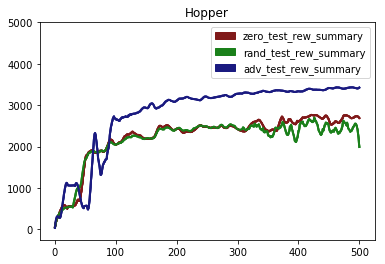

In [15]:
plot_tests = [const_test_rew_summary, rand_test_rew_summary, adv_test_rew_summary]
plot_names = ['zero_test_rew_summary', 'rand_test_rew_summary', 'adv_test_rew_summary']
plot_colors = [(0.5,0.1,0.1), (0.1,0.5,0.1), (0.1,0.1,0.5)]
all_patches = []
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    x = [i for i in range(len(mean_con))]
    plt.plot(x,mean_con,color=plot_colors[i], linewidth=2.0)
    plt.fill_between(x, mean_con-std_con, mean_con+std_con,color=plot_colors[i], alpha=0.5)
    all_patches.append(mpatches.Patch(color=plot_colors[i], label=plot_names[i]))

plt.legend(handles=all_patches)
axes = plt.gca()
axes.set_ylim([-250,5000])
plt.title("Hopper")
plt.show()